In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2_dft'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[dft_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 29:25 - loss: 2.3981

  2/151 [..............................] - ETA: 9s - loss: 2.3977   

  3/151 [..............................] - ETA: 8s - loss: 2.3972

  4/151 [..............................] - ETA: 8s - loss: 2.3965

  5/151 [..............................] - ETA: 8s - loss: 2.3957



  6/151 [>.............................] - ETA: 8s - loss: 2.3946

  7/151 [>.............................] - ETA: 8s - loss: 2.3933

  8/151 [>.............................] - ETA: 8s - loss: 2.3919

  9/151 [>.............................] - ETA: 8s - loss: 2.3902

 10/151 [>.............................] - ETA: 8s - loss: 2.3882

 11/151 [=>............................] - ETA: 8s - loss: 2.3858

 12/151 [=>............................] - ETA: 8s - loss: 2.3831

 13/151 [=>............................] - ETA: 8s - loss: 2.3801

 14/151 [=>............................] - ETA: 8s - loss: 2.3769

 15/151 [=>............................] - ETA: 8s - loss: 2.3734

 16/151 [==>...........................] - ETA: 8s - loss: 2.3696

 17/151 [==>...........................] - ETA: 8s - loss: 2.3656

 18/151 [==>...........................] - ETA: 8s - loss: 2.3612

 19/151 [==>...........................] - ETA: 7s - loss: 2.3567

 20/151 [==>...........................] - ETA: 7s - loss: 2.3520

 21/151 [===>..........................] - ETA: 7s - loss: 2.3471

 22/151 [===>..........................] - ETA: 7s - loss: 2.3421

 23/151 [===>..........................] - ETA: 7s - loss: 2.3371

 24/151 [===>..........................] - ETA: 7s - loss: 2.3320

 25/151 [===>..........................] - ETA: 7s - loss: 2.3267

 26/151 [====>.........................] - ETA: 7s - loss: 2.3215

 27/151 [====>.........................] - ETA: 7s - loss: 2.3163

 28/151 [====>.........................] - ETA: 7s - loss: 2.3110

 29/151 [====>.........................] - ETA: 7s - loss: 2.3060

 30/151 [====>.........................] - ETA: 7s - loss: 2.3009

 31/151 [=====>........................] - ETA: 7s - loss: 2.2959

 32/151 [=====>........................] - ETA: 7s - loss: 2.2910

 33/151 [=====>........................] - ETA: 7s - loss: 2.2863

 34/151 [=====>........................] - ETA: 7s - loss: 2.2816

 35/151 [=====>........................] - ETA: 7s - loss: 2.2769

 36/151 [======>.......................] - ETA: 6s - loss: 2.2724

 37/151 [======>.......................] - ETA: 6s - loss: 2.2678

 38/151 [======>.......................] - ETA: 6s - loss: 2.2634

 39/151 [======>.......................] - ETA: 6s - loss: 2.2591

 40/151 [======>.......................] - ETA: 6s - loss: 2.2548

 41/151 [=======>......................] - ETA: 6s - loss: 2.2506

 42/151 [=======>......................] - ETA: 6s - loss: 2.2464

 43/151 [=======>......................] - ETA: 6s - loss: 2.2423

 44/151 [=======>......................] - ETA: 6s - loss: 2.2383

 45/151 [=======>......................] - ETA: 6s - loss: 2.2344

 46/151 [========>.....................] - ETA: 6s - loss: 2.2305

 47/151 [========>.....................] - ETA: 6s - loss: 2.2267



 48/151 [========>.....................] - ETA: 6s - loss: 2.2229

 49/151 [========>.....................] - ETA: 6s - loss: 2.2193

 50/151 [========>.....................] - ETA: 6s - loss: 2.2157

 51/151 [=========>....................] - ETA: 6s - loss: 2.2121

 52/151 [=========>....................] - ETA: 6s - loss: 2.2087

 53/151 [=========>....................] - ETA: 5s - loss: 2.2053

 54/151 [=========>....................] - ETA: 5s - loss: 2.2019

 55/151 [=========>....................] - ETA: 5s - loss: 2.1986

 56/151 [==========>...................] - ETA: 5s - loss: 2.1954

 57/151 [==========>...................] - ETA: 5s - loss: 2.1922

 58/151 [==========>...................]

 - ETA: 5s - loss: 2.1890

 59/151 [==========>...................] - ETA: 5s - loss: 2.1859

 60/151 [==========>...................] - ETA: 5s - loss: 2.1828

 61/151 [===========>..................] - ETA: 5s - loss: 2.1798

 62/151 [===========>..................] - ETA: 5s - loss: 2.1768

 63/151 [===========>..................] - ETA: 5s - loss: 2.1739

 64/151 [===========>..................] - ETA: 5s - loss: 2.1710

 65/151 [===========>..................] - ETA: 5s - loss: 2.1682

 66/151 [============>.................] - ETA: 5s - loss: 2.1654

 67/151 [============>.................] - ETA: 5s - loss: 2.1626

 68/151 [============>.................] - ETA: 5s - loss: 2.1599

 69/151 [============>.................] - ETA: 4s - loss: 2.1572

 70/151 [============>.................] - ETA: 4s - loss: 2.1545

 71/151 [=============>................] - ETA: 4s - loss: 2.1519



 72/151 [=============>................] - ETA: 4s - loss: 2.1494

 73/151 [=============>................] - ETA: 4s - loss: 2.1469

 74/151 [=============>................] - ETA: 4s - loss: 2.1444

 75/151 [=============>................] - ETA: 4s - loss: 2.1420

 76/151 [==============>...............] - ETA: 4s - loss: 2.1396

 77/151 [==============>...............] - ETA: 4s - loss: 2.1372

 78/151 [==============>...............] - ETA: 4s - loss: 2.1349

 79/151 [==============>...............] - ETA: 4s - loss: 2.1326

 80/151 [==============>...............] - ETA: 4s - loss: 2.1304

 81/151 [===============>..............] - ETA: 4s - loss: 2.1282

 82/151 [===============>..............] - ETA: 4s - loss: 2.1260

 83/151 [===============>..............] - ETA: 4s - loss: 2.1238

 84/151 [===============>..............] - ETA: 4s - loss: 2.1217

 85/151 [===============>..............] - ETA: 4s - loss: 2.1195

 86/151 [================>.............] - ETA: 3s - loss: 2.1175

 87/151 [================>.............] - ETA: 3s - loss: 2.1154

 88/151 [================>.............] - ETA: 3s - loss: 2.1134

 89/151 [================>.............] - ETA: 3s - loss: 2.1113

 90/151 [================>.............] - ETA: 3s - loss: 2.1094

 91/151 [=================>............] - ETA: 3s - loss: 2.1074

 92/151 [=================>............] - ETA: 3s - loss: 2.1054

 93/151 [=================>............] - ETA: 3s - loss: 2.1035

 94/151 [=================>............] - ETA: 3s - loss: 2.1016

 95/151 [=================>............] - ETA: 3s - loss: 2.0998

 96/151 [==================>...........] - ETA: 3s - loss: 2.0979

 97/151 [==================>...........] - ETA: 3s - loss: 2.0961

 98/151 [==================>...........] - ETA: 3s - loss: 2.0943

 99/151 [==================>...........] - ETA: 3s - loss: 2.0926

100/151 [==================>...........] - ETA: 3s - loss: 2.0908

101/151 [===================>..........] - ETA: 3s - loss: 2.0891

102/151 [===================>..........] - ETA: 2s - loss: 2.0874

103/151 [===================>..........] - ETA: 2s - loss: 2.0857

104/151 [===================>..........] - ETA: 2s - loss: 2.0840

105/151 [===================>..........] - ETA: 2s - loss: 2.0824

106/151 [====================>.........] - ETA: 2s - loss: 2.0808

107/151 [====================>.........] - ETA: 2s - loss: 2.0791

108/151 [====================>.........] - ETA: 2s - loss: 2.0776

109/151 [====================>.........] - ETA: 2s - loss: 2.0760

110/151 [====================>.........] - ETA: 2s - loss: 2.0744

111/151 [=====================>........] - ETA: 2s - loss: 2.0729

112/151 [=====================>........] - ETA: 2s - loss: 2.0714

113/151 [=====================>........] - ETA: 2s - loss: 2.0699

114/151 [=====================>........]

 - ETA: 2s - loss: 2.0684

115/151 [=====================>........] - ETA: 2s - loss: 2.0669

116/151 [======================>.......] - ETA: 2s - loss: 2.0655

117/151 [======================>.......] - ETA: 2s - loss: 2.0640

118/151 [======================>.......] - ETA: 2s - loss: 2.0626

119/151 [======================>.......] - ETA: 1s - loss: 2.0612

120/151 [======================>.......] - ETA: 1s - loss: 2.0598

121/151 [=======================>......] - ETA: 1s - loss: 2.0584

122/151 [=======================>......] - ETA: 1s - loss: 2.0571

123/151 [=======================>......] - ETA: 1s - loss: 2.0557

124/151 [=======================>......] - ETA: 1s - loss: 2.0544

125/151 [=======================>......] - ETA: 1s - loss: 2.0530

126/151 [========================>.....] - ETA: 1s - loss: 2.0517

127/151 [========================>.....] - ETA: 1s - loss: 2.0504

128/151 [========================>.....] - ETA: 1s - loss: 2.0491

129/151 [========================>.....] - ETA: 1s - loss: 2.0479

130/151 [========================>.....] - ETA: 1s - loss: 2.0466

131/151 [=========================>....] - ETA: 1s - loss: 2.0453



132/151 [=========================>....] - ETA: 1s - loss: 2.0441

133/151 [=========================>....] - ETA: 1s - loss: 2.0428

134/151 [=========================>....] - ETA: 1s - loss: 2.0416

135/151 [=========================>....] - ETA: 0s - loss: 2.0404

136/151 [==========================>...] - ETA: 0s - loss: 2.0392

137/151 [==========================>...] - ETA: 0s - loss: 2.0380

138/151 [==========================>...] - ETA: 0s - loss: 2.0368

139/151 [==========================>...] - ETA: 0s - loss: 2.0356

140/151 [==========================>...] - ETA: 0s - loss: 2.0345

141/151 [===========================>..] - ETA: 0s - loss: 2.0333

142/151 [===========================>..] - ETA: 0s - loss: 2.0322

143/151 [===========================>..] - ETA: 0s - loss: 2.0311

144/151 [===========================>..] - ETA: 0s - loss: 2.0299

145/151 [===========================>..] - ETA: 0s - loss: 2.0288

146/151 [============================>.] - ETA: 0s - loss: 2.0277

147/151 [============================>.] - ETA: 0s - loss: 2.0266

148/151 [============================>.] - ETA: 0s - loss: 2.0255

149/151 [============================>.] - ETA: 0s - loss: 2.0244

150/151 [============================>.] - ETA: 0s - loss: 2.0234

151/151 [==============================] - ETA: 0s - loss: 2.0223

151/151 [==============================] - 23s 78ms/step - loss: 2.0213 - val_loss: 1.7295


Epoch 2/100
  1/151 [..............................] - ETA: 9s - loss: 1.7497

  2/151 [..............................] - ETA: 8s - loss: 1.7555



  3/151 [..............................] - ETA: 8s - loss: 1.7580

  4/151 [..............................] - ETA: 8s - loss: 1.7569

  5/151 [..............................] - ETA: 8s - loss: 1.7543

  6/151 [>.............................] - ETA: 8s - loss: 1.7518

  7/151 [>.............................] - ETA: 8s - loss: 1.7499

  8/151 [>.............................] - ETA: 8s - loss: 1.7484

  9/151 [>.............................] - ETA: 8s - loss: 1.7470

 10/151 [>.............................] - ETA: 8s - loss: 1.7460

 11/151 [=>............................] - ETA: 8s - loss: 1.7450

 12/151 [=>............................] - ETA: 8s - loss: 1.7445

 13/151 [=>............................] - ETA: 8s - loss: 1.7437

 14/151 [=>............................] - ETA: 8s - loss: 1.7428

 15/151 [=>............................] - ETA: 8s - loss: 1.7421

 16/151 [==>...........................] - ETA: 8s - loss: 1.7413

 17/151 [==>...........................] - ETA: 8s - loss: 1.7405

 18/151 [==>...........................] - ETA: 8s - loss: 1.7397

 19/151 [==>...........................] - ETA: 8s - loss: 1.7390

 20/151 [==>...........................] - ETA: 7s - loss: 1.7383

 21/151 [===>..........................] - ETA: 7s - loss: 1.7377

 22/151 [===>..........................] - ETA: 7s - loss: 1.7373

 23/151 [===>..........................] - ETA: 7s - loss: 1.7368

 24/151 [===>..........................] - ETA: 7s - loss: 1.7364



 25/151 [===>..........................] - ETA: 7s - loss: 1.7360

 26/151 [====>.........................] - ETA: 7s - loss: 1.7356

 27/151 [====>.........................] - ETA: 7s - loss: 1.7352

 28/151 [====>.........................] - ETA: 7s - loss: 1.7348

 29/151 [====>.........................] - ETA: 7s - loss: 1.7345

 30/151 [====>.........................] - ETA: 7s - loss: 1.7341

 31/151 [=====>........................] - ETA: 7s - loss: 1.7338

 32/151 [=====>........................] - ETA: 7s - loss: 1.7335



 33/151 [=====>........................] - ETA: 7s - loss: 1.7332



 34/151 [=====>........................] - ETA: 7s - loss: 1.7329

 35/151 [=====>........................] - ETA: 7s - loss: 1.7327

 36/151 [======>.......................] - ETA: 7s - loss: 1.7325

 37/151 [======>.......................] - ETA: 6s - loss: 1.7322

 38/151 [======>.......................] - ETA: 6s - loss: 1.7320

 39/151 [======>.......................] - ETA: 6s - loss: 1.7318

 40/151 [======>.......................] - ETA: 6s - loss: 1.7316

 41/151 [=======>......................] - ETA: 6s - loss: 1.7315

 42/151 [=======>......................] - ETA: 6s - loss: 1.7313

 43/151 [=======>......................] - ETA: 6s - loss: 1.7311

 44/151 [=======>......................] - ETA: 6s - loss: 1.7309

 45/151 [=======>......................] - ETA: 6s - loss: 1.7308

 46/151 [========>.....................] - ETA: 6s - loss: 1.7306

 47/151 [========>.....................] - ETA: 6s - loss: 1.7304

 48/151 [========>.....................] - ETA: 6s - loss: 1.7303

 49/151 [========>.....................] - ETA: 6s - loss: 1.7301

 50/151 [========>.....................] - ETA: 6s - loss: 1.7300

 51/151 [=========>....................] - ETA: 6s - loss: 1.7298

 52/151 [=========>....................] - ETA: 6s - loss: 1.7297

 53/151 [=========>....................] - ETA: 5s - loss: 1.7295

 54/151 [=========>....................] - ETA: 5s - loss: 1.7294

 55/151 [=========>....................] - ETA: 5s - loss: 1.7292

 56/151 [==========>...................] - ETA: 5s - loss: 1.7290

 57/151 [==========>...................] - ETA: 5s - loss: 1.7289

 58/151 [==========>...................] - ETA: 5s - loss: 1.7287

 59/151 [==========>...................] - ETA: 5s - loss: 1.7286

 60/151 [==========>...................] - ETA: 5s - loss: 1.7284

 61/151 [===========>..................] - ETA: 5s - loss: 1.7282

 62/151 [===========>..................] - ETA: 5s - loss: 1.7281

 63/151 [===========>..................] - ETA: 5s - loss: 1.7279

 64/151 [===========>..................] - ETA: 5s - loss: 1.7277

 65/151 [===========>..................] - ETA: 5s - loss: 1.7276

 66/151 [============>.................]

 - ETA: 5s - loss: 1.7274

 67/151 [============>.................] - ETA: 5s - loss: 1.7272

 68/151 [============>.................] - ETA: 5s - loss: 1.7270

 69/151 [============>.................] - ETA: 5s - loss: 1.7268

 70/151 [============>.................] - ETA: 4s - loss: 1.7266

 71/151 [=============>................] - ETA: 4s - loss: 1.7264

 72/151 [=============>................] - ETA: 4s - loss: 1.7262

 73/151 [=============>................] - ETA: 4s - loss: 1.7260

 74/151 [=============>................] - ETA: 4s - loss: 1.7258

 75/151 [=============>................] - ETA: 4s - loss: 1.7256

 76/151 [==============>...............] - ETA: 4s - loss: 1.7254

 77/151 [==============>...............] - ETA: 4s - loss: 1.7252

 78/151 [==============>...............] - ETA: 4s - loss: 1.7250

 79/151 [==============>...............] - ETA: 4s - loss: 1.7247

 80/151 [==============>...............] - ETA: 4s - loss: 1.7245

 81/151 [===============>..............] - ETA: 4s - loss: 1.7243

 82/151 [===============>..............] - ETA: 4s - loss: 1.7241

 83/151 [===============>..............] - ETA: 4s - loss: 1.7239

 84/151 [===============>..............] - ETA: 4s - loss: 1.7237

 85/151 [===============>..............] - ETA: 4s - loss: 1.7235

 86/151 [================>.............] - ETA: 3s - loss: 1.7233

 87/151 [================>.............] - ETA: 3s - loss: 1.7230

 88/151 [================>.............] - ETA: 3s - loss: 1.7228

 89/151 [================>.............] - ETA: 3s - loss: 1.7226

 90/151 [================>.............] - ETA: 3s - loss: 1.7224

 91/151 [=================>............] - ETA: 3s - loss: 1.7222

 92/151 [=================>............] - ETA: 3s - loss: 1.7219

 93/151 [=================>............] - ETA: 3s - loss: 1.7217

 94/151 [=================>............] - ETA: 3s - loss: 1.7215

 95/151 [=================>............] - ETA: 3s - loss: 1.7213

 96/151 [==================>...........] - ETA: 3s - loss: 1.7210

 97/151 [==================>...........] - ETA: 3s - loss: 1.7208

 98/151 [==================>...........] - ETA: 3s - loss: 1.7206

 99/151 [==================>...........] - ETA: 3s - loss: 1.7204

100/151 [==================>...........] - ETA: 3s - loss: 1.7201

101/151 [===================>..........] - ETA: 3s - loss: 1.7199

102/151 [===================>..........] - ETA: 2s - loss: 1.7197

103/151 [===================>..........] - ETA: 2s - loss: 1.7195

104/151 [===================>..........] - ETA: 2s - loss: 1.7192

105/151 [===================>..........] - ETA: 2s - loss: 1.7190

106/151 [====================>.........] - ETA: 2s - loss: 1.7188

107/151 [====================>.........] - ETA: 2s - loss: 1.7186

108/151 [====================>.........] - ETA: 2s - loss: 1.7184

109/151 [====================>.........] - ETA: 2s - loss: 1.7182

110/151 [====================>.........] - ETA: 2s - loss: 1.7180

111/151 [=====================>........] - ETA: 2s - loss: 1.7177

112/151 [=====================>........] - ETA: 2s - loss: 1.7175

113/151 [=====================>........] - ETA: 2s - loss: 1.7173

114/151 [=====================>........] - ETA: 2s - loss: 1.7171

115/151 [=====================>........] - ETA: 2s - loss: 1.7168

116/151 [======================>.......] - ETA: 2s - loss: 1.7166

117/151 [======================>.......] - ETA: 2s - loss: 1.7164

118/151 [======================>.......] - ETA: 2s - loss: 1.7162

119/151 [======================>.......] - ETA: 1s - loss: 1.7159

120/151 [======================>.......] - ETA: 1s - loss: 1.7157

121/151 [=======================>......] - ETA: 1s - loss: 1.7155

122/151 [=======================>......] - ETA: 1s - loss: 1.7153



123/151 [=======================>......] - ETA: 1s - loss: 1.7150

124/151 [=======================>......] - ETA: 1s - loss: 1.7148

125/151 [=======================>......] - ETA: 1s - loss: 1.7146

126/151 [========================>.....] - ETA: 1s - loss: 1.7144

127/151 [========================>.....] - ETA: 1s - loss: 1.7142

128/151 [========================>.....] - ETA: 1s - loss: 1.7140

129/151 [========================>.....] - ETA: 1s - loss: 1.7138

130/151 [========================>.....] - ETA: 1s - loss: 1.7135

131/151 [=========================>....] - ETA: 1s - loss: 1.7133

132/151 [=========================>....] - ETA: 1s - loss: 1.7131



133/151 [=========================>....] - ETA: 1s - loss: 1.7129

134/151 [=========================>....] - ETA: 1s - loss: 1.7127

135/151 [=========================>....] - ETA: 0s - loss: 1.7125

136/151 [==========================>...] - ETA: 0s - loss: 1.7123

137/151 [==========================>...] - ETA: 0s - loss: 1.7121

138/151 [==========================>...] - ETA: 0s - loss: 1.7119

139/151 [==========================>...] - ETA: 0s - loss: 1.7117

140/151 [==========================>...] - ETA: 0s - loss: 1.7115

141/151 [===========================>..] - ETA: 0s - loss: 1.7112

142/151 [===========================>..] - ETA: 0s - loss: 1.7110

143/151 [===========================>..]

 - ETA: 0s - loss: 1.7108

144/151 [===========================>..] - ETA: 0s - loss: 1.7106

145/151 [===========================>..] - ETA: 0s - loss: 1.7104

146/151 [============================>.] - ETA: 0s - loss: 1.7102

147/151 [============================>.] - ETA: 0s - loss: 1.7100

148/151 [============================>.] - ETA: 0s - loss: 1.7098

149/151 [============================>.] - ETA: 0s - loss: 1.7096

150/151 [============================>.] - ETA: 0s - loss: 1.7094

151/151 [==============================] - 11s 70ms/step - loss: 1.7090 - val_loss: 1.6019


Epoch 3/100
  1/151 [..............................] - ETA: 9s - loss: 1.5770

  2/151 [..............................] - ETA: 9s - loss: 1.5982

  3/151 [..............................] - ETA: 9s - loss: 1.6020

  4/151 [..............................] - ETA: 9s - loss: 1.6031

  5/151 [..............................] - ETA: 8s - loss: 1.6034

  6/151 [>.............................] - ETA: 8s - loss: 1.6031

  7/151 [>.............................] - ETA: 8s - loss: 1.6022

  8/151 [>.............................] - ETA: 8s - loss: 1.6020

  9/151 [>.............................] - ETA: 8s - loss: 1.6017

 10/151 [>.............................] - ETA: 8s - loss: 1.6021

 11/151 [=>............................] - ETA: 8s - loss: 1.6033

 12/151 [=>............................] - ETA: 8s - loss: 1.6040

 13/151 [=>............................] - ETA: 8s - loss: 1.6052

 14/151 [=>............................] - ETA: 8s - loss: 1.6062

 15/151 [=>............................] - ETA: 8s - loss: 1.6074

 16/151 [==>...........................] - ETA: 8s - loss: 1.6085

 17/151 [==>...........................] - ETA: 8s - loss: 1.6093

 18/151 [==>...........................] - ETA: 8s - loss: 1.6103

 19/151 [==>...........................] - ETA: 8s - loss: 1.6111

 20/151 [==>...........................] - ETA: 7s - loss: 1.6118

 21/151 [===>..........................] - ETA: 7s - loss: 1.6123

 22/151 [===>..........................] - ETA: 7s - loss: 1.6129

 23/151 [===>..........................] - ETA: 7s - loss: 1.6134

 24/151 [===>..........................] - ETA: 7s - loss: 1.6138

 25/151 [===>..........................] - ETA: 7s - loss: 1.6142

 26/151 [====>.........................] - ETA: 7s - loss: 1.6146

 27/151 [====>.........................] - ETA: 7s - loss: 1.6148

 28/151 [====>.........................] - ETA: 7s - loss: 1.6150

 29/151 [====>.........................] - ETA: 7s - loss: 1.6152

 30/151 [====>.........................] - ETA: 7s - loss: 1.6155

 31/151 [=====>........................] - ETA: 7s - loss: 1.6156

 32/151 [=====>........................] - ETA: 7s - loss: 1.6158

 33/151 [=====>........................] - ETA: 7s - loss: 1.6160

 34/151 [=====>........................]

 - ETA: 7s - loss: 1.6161

 35/151 [=====>........................] - ETA: 7s - loss: 1.6162

 36/151 [======>.......................] - ETA: 7s - loss: 1.6163

 37/151 [======>.......................] - ETA: 6s - loss: 1.6164

 38/151 [======>.......................] - ETA: 6s - loss: 1.6165

 39/151 [======>.......................] - ETA: 6s - loss: 1.6166

 40/151 [======>.......................] - ETA: 6s - loss: 1.6167

 41/151 [=======>......................] - ETA: 6s - loss: 1.6168

 42/151 [=======>......................] - ETA: 6s - loss: 1.6169

 43/151 [=======>......................] - ETA: 6s - loss: 1.6169

 44/151 [=======>......................] - ETA: 6s - loss: 1.6170

 45/151 [=======>......................] - ETA: 6s - loss: 1.6170



 46/151 [========>.....................] - ETA: 6s - loss: 1.6170

 47/151 [========>.....................] - ETA: 6s - loss: 1.6170

 48/151 [========>.....................] - ETA: 6s - loss: 1.6171

 49/151 [========>.....................] - ETA: 6s - loss: 1.6171

 50/151 [========>.....................] - ETA: 6s - loss: 1.6171

 51/151 [=========>....................] - ETA: 6s - loss: 1.6171

 52/151 [=========>....................] - ETA: 6s - loss: 1.6171

 53/151 [=========>....................] - ETA: 5s - loss: 1.6171

 54/151 [=========>....................] - ETA: 5s - loss: 1.6170

 55/151 [=========>....................] - ETA: 5s - loss: 1.6170

 56/151 [==========>...................] - ETA: 5s - loss: 1.6170

 57/151 [==========>...................] - ETA: 5s - loss: 1.6169



 58/151 [==========>...................] - ETA: 5s - loss: 1.6168

 59/151 [==========>...................] - ETA: 5s - loss: 1.6168

 60/151 [==========>...................] - ETA: 5s - loss: 1.6167

 61/151 [===========>..................] - ETA: 5s - loss: 1.6166

 62/151 [===========>..................] - ETA: 5s - loss: 1.6165

 63/151 [===========>..................] - ETA: 5s - loss: 1.6164

 64/151 [===========>..................] - ETA: 5s - loss: 1.6163

 65/151 [===========>..................] - ETA: 5s - loss: 1.6162

 66/151 [============>.................] - ETA: 5s - loss: 1.6160

 67/151 [============>.................] - ETA: 5s - loss: 1.6159

 68/151 [============>.................] - ETA: 5s - loss: 1.6157

 69/151 [============>.................] - ETA: 5s - loss: 1.6156

 70/151 [============>.................] - ETA: 4s - loss: 1.6154

 71/151 [=============>................] - ETA: 4s - loss: 1.6152

 72/151 [=============>................] - ETA: 4s - loss: 1.6150

 73/151 [=============>................] - ETA: 4s - loss: 1.6149

 74/151 [=============>................] - ETA: 4s - loss: 1.6147

 75/151 [=============>................] - ETA: 4s - loss: 1.6145

 76/151 [==============>...............] - ETA: 4s - loss: 1.6143

 77/151 [==============>...............] - ETA: 4s - loss: 1.6141

 78/151 [==============>...............] - ETA: 4s - loss: 1.6139

 79/151 [==============>...............] - ETA: 4s - loss: 1.6137

 80/151 [==============>...............] - ETA: 4s - loss: 1.6135

 81/151 [===============>..............] - ETA: 4s - loss: 1.6133

 82/151 [===============>..............] - ETA: 4s - loss: 1.6131

 83/151 [===============>..............] - ETA: 4s - loss: 1.6129

 84/151 [===============>..............] - ETA: 4s - loss: 1.6127

 85/151 [===============>..............] - ETA: 4s - loss: 1.6125

 86/151 [================>.............] - ETA: 3s - loss: 1.6123

 87/151 [================>.............] - ETA: 3s - loss: 1.6121

 88/151 [================>.............] - ETA: 3s - loss: 1.6119

 89/151 [================>.............] - ETA: 3s - loss: 1.6117

 90/151 [================>.............] - ETA: 3s - loss: 1.6115

 91/151 [=================>............] - ETA: 3s - loss: 1.6113

 92/151 [=================>............] - ETA: 3s - loss: 1.6110

 93/151 [=================>............] - ETA: 3s - loss: 1.6108

 94/151 [=================>............] - ETA: 3s - loss: 1.6106

 95/151 [=================>............] - ETA: 3s - loss: 1.6104

 96/151 [==================>...........] - ETA: 3s - loss: 1.6102

 97/151 [==================>...........] - ETA: 3s - loss: 1.6100

 98/151 [==================>...........] - ETA: 3s - loss: 1.6098

 99/151 [==================>...........] - ETA: 3s - loss: 1.6096

100/151 [==================>...........] - ETA: 3s - loss: 1.6094

101/151 [===================>..........] - ETA: 3s - loss: 1.6091

102/151 [===================>..........] - ETA: 2s - loss: 1.6089

103/151 [===================>..........] - ETA: 2s - loss: 1.6087

104/151 [===================>..........] - ETA: 2s - loss: 1.6085

105/151 [===================>..........] - ETA: 2s - loss: 1.6083

106/151 [====================>.........] - ETA: 2s - loss: 1.6081

107/151 [====================>.........] - ETA: 2s - loss: 1.6079

108/151 [====================>.........] - ETA: 2s - loss: 1.6077

109/151 [====================>.........] - ETA: 2s - loss: 1.6074

110/151 [====================>.........] - ETA: 2s - loss: 1.6072

111/151 [=====================>........] - ETA: 2s - loss: 1.6070

112/151 [=====================>........] - ETA: 2s - loss: 1.6068

113/151 [=====================>........] - ETA: 2s - loss: 1.6066

114/151 [=====================>........] - ETA: 2s - loss: 1.6064

115/151 [=====================>........] - ETA: 2s - loss: 1.6061

116/151 [======================>.......] - ETA: 2s - loss: 1.6059

117/151 [======================>.......] - ETA: 2s - loss: 1.6057

118/151 [======================>.......] - ETA: 2s - loss: 1.6055

119/151 [======================>.......] - ETA: 1s - loss: 1.6053

120/151 [======================>.......] - ETA: 1s - loss: 1.6051

121/151 [=======================>......] - ETA: 1s - loss: 1.6049

122/151 [=======================>......] - ETA: 1s - loss: 1.6047

123/151 [=======================>......] - ETA: 1s - loss: 1.6044

124/151 [=======================>......] - ETA: 1s - loss: 1.6042

125/151 [=======================>......] - ETA: 1s - loss: 1.6040

126/151 [========================>.....] - ETA: 1s - loss: 1.6038

127/151 [========================>.....] - ETA: 1s - loss: 1.6036

128/151 [========================>.....] - ETA: 1s - loss: 1.6034

129/151 [========================>.....] - ETA: 1s - loss: 1.6032

130/151 [========================>.....] - ETA: 1s - loss: 1.6030

131/151 [=========================>....] - ETA: 1s - loss: 1.6028

132/151 [=========================>....] - ETA: 1s - loss: 1.6026

133/151 [=========================>....] - ETA: 1s - loss: 1.6024

134/151 [=========================>....] - ETA: 1s - loss: 1.6022

135/151 [=========================>....] - ETA: 0s - loss: 1.6020

136/151 [==========================>...] - ETA: 0s - loss: 1.6018

137/151 [==========================>...] - ETA: 0s - loss: 1.6016

138/151 [==========================>...] - ETA: 0s - loss: 1.6014

139/151 [==========================>...] - ETA: 0s - loss: 1.6012

140/151 [==========================>...] - ETA: 0s - loss: 1.6011

141/151 [===========================>..] - ETA: 0s - loss: 1.6009

142/151 [===========================>..] - ETA: 0s - loss: 1.6007

143/151 [===========================>..] - ETA: 0s - loss: 1.6005

144/151 [===========================>..] - ETA: 0s - loss: 1.6004

145/151 [===========================>..] - ETA: 0s - loss: 1.6002

146/151 [============================>.] - ETA: 0s - loss: 1.6000

147/151 [============================>.] - ETA: 0s - loss: 1.5998

148/151 [============================>.] - ETA: 0s - loss: 1.5997

149/151 [============================>.] - ETA: 0s - loss: 1.5995

150/151 [============================>.] - ETA: 0s - loss: 1.5993

151/151 [==============================] - 11s 70ms/step - loss: 1.5990 - val_loss: 1.6832


Epoch 4/100
  1/151 [..............................] - ETA: 8s - loss: 1.6802

  2/151 [..............................] - ETA: 9s - loss: 1.6361

  3/151 [..............................] - ETA: 8s - loss: 1.6245

  4/151 [..............................] - ETA: 8s - loss: 1.6170

  5/151 [..............................] - ETA: 8s - loss: 1.6119

  6/151 [>.............................] - ETA: 8s - loss: 1.6066

  7/151 [>.............................] - ETA: 8s - loss: 1.6017

  8/151 [>.............................] - ETA: 8s - loss: 1.5962

  9/151 [>.............................] - ETA: 8s - loss: 1.5923

 10/151 [>.............................] - ETA: 8s - loss: 1.5897

 11/151 [=>............................] - ETA: 8s - loss: 1.5872

 12/151 [=>............................] - ETA: 8s - loss: 1.5849

 13/151 [=>............................] - ETA: 8s - loss: 1.5829

 14/151 [=>............................] - ETA: 8s - loss: 1.5811

 15/151 [=>............................] - ETA: 8s - loss: 1.5792



 16/151 [==>...........................] - ETA: 8s - loss: 1.5774

 17/151 [==>...........................] - ETA: 8s - loss: 1.5756

 18/151 [==>...........................] - ETA: 8s - loss: 1.5738

 19/151 [==>...........................] - ETA: 8s - loss: 1.5722

 20/151 [==>...........................] - ETA: 8s - loss: 1.5707

 21/151 [===>..........................] - ETA: 7s - loss: 1.5692

 22/151 [===>..........................] - ETA: 7s - loss: 1.5679

 23/151 [===>..........................] - ETA: 7s - loss: 1.5666

 24/151 [===>..........................] - ETA: 7s - loss: 1.5654

 25/151 [===>..........................] - ETA: 7s - loss: 1.5643

 26/151 [====>.........................] - ETA: 7s - loss: 1.5631

 27/151 [====>.........................] - ETA: 7s - loss: 1.5619

 28/151 [====>.........................] - ETA: 7s - loss: 1.5608

 29/151 [====>.........................] - ETA: 7s - loss: 1.5598

 30/151 [====>.........................] - ETA: 7s - loss: 1.5589

 31/151 [=====>........................] - ETA: 7s - loss: 1.5580

 32/151 [=====>........................] - ETA: 7s - loss: 1.5571

 33/151 [=====>........................] - ETA: 7s - loss: 1.5564

 34/151 [=====>........................] - ETA: 7s - loss: 1.5557

 35/151 [=====>........................] - ETA: 7s - loss: 1.5550

 36/151 [======>.......................] - ETA: 7s - loss: 1.5544

 37/151 [======>.......................] - ETA: 6s - loss: 1.5537

 38/151 [======>.......................] - ETA: 6s - loss: 1.5531

 39/151 [======>.......................] - ETA: 6s - loss: 1.5526

 40/151 [======>.......................] - ETA: 6s - loss: 1.5521

 41/151 [=======>......................] - ETA: 6s - loss: 1.5515



 42/151 [=======>......................] - ETA: 6s - loss: 1.5510

 43/151 [=======>......................] - ETA: 6s - loss: 1.5506

 44/151 [=======>......................] - ETA: 6s - loss: 1.5501

 45/151 [=======>......................] - ETA: 6s - loss: 1.5497

 46/151 [========>.....................] - ETA: 6s - loss: 1.5492

 47/151 [========>.....................] - ETA: 6s - loss: 1.5488

 48/151 [========>.....................] - ETA: 6s - loss: 1.5484

 49/151 [========>.....................] - ETA: 6s - loss: 1.5480

 50/151 [========>.....................] - ETA: 6s - loss: 1.5476

 51/151 [=========>....................] - ETA: 6s - loss: 1.5472

 52/151 [=========>....................] - ETA: 6s - loss: 1.5468

 53/151 [=========>....................] - ETA: 5s - loss: 1.5464

 54/151 [=========>....................] - ETA: 5s - loss: 1.5460

 55/151 [=========>....................] - ETA: 5s - loss: 1.5456

 56/151 [==========>...................] - ETA: 5s - loss: 1.5452

 57/151 [==========>...................] - ETA: 5s - loss: 1.5449

 58/151 [==========>...................] - ETA: 5s - loss: 1.5445

 59/151 [==========>...................] - ETA: 5s - loss: 1.5441

 60/151 [==========>...................] - ETA: 5s - loss: 1.5437

 61/151 [===========>..................] - ETA: 5s - loss: 1.5434

 62/151 [===========>..................] - ETA: 5s - loss: 1.5431

 63/151 [===========>..................] - ETA: 5s - loss: 1.5427

 64/151 [===========>..................] - ETA: 5s - loss: 1.5424

 65/151 [===========>..................] - ETA: 5s - loss: 1.5421

 66/151 [============>.................] - ETA: 5s - loss: 1.5418

 67/151 [============>.................] - ETA: 5s - loss: 1.5415

 68/151 [============>.................] - ETA: 5s - loss: 1.5412

 69/151 [============>.................] - ETA: 5s - loss: 1.5409

 70/151 [============>.................] - ETA: 4s - loss: 1.5406

 71/151 [=============>................] - ETA: 4s - loss: 1.5403

 72/151 [=============>................] - ETA: 4s - loss: 1.5400

 73/151 [=============>................] - ETA: 4s - loss: 1.5398

 74/151 [=============>................] - ETA: 4s - loss: 1.5395

 75/151 [=============>................] - ETA: 4s - loss: 1.5393

 76/151 [==============>...............] - ETA: 4s - loss: 1.5390

 77/151 [==============>...............] - ETA: 4s - loss: 1.5388

 78/151 [==============>...............] - ETA: 4s - loss: 1.5386

 79/151 [==============>...............] - ETA: 4s - loss: 1.5384

 80/151 [==============>...............] - ETA: 4s - loss: 1.5382

 81/151 [===============>..............] - ETA: 4s - loss: 1.5380

 82/151 [===============>..............] - ETA: 4s - loss: 1.5378

 83/151 [===============>..............] - ETA: 4s - loss: 1.5376

 84/151 [===============>..............] - ETA: 4s - loss: 1.5374

 85/151 [===============>..............] - ETA: 4s - loss: 1.5372

 86/151 [================>.............] - ETA: 3s - loss: 1.5370

 87/151 [================>.............] - ETA: 3s - loss: 1.5368

 88/151 [================>.............] - ETA: 3s - loss: 1.5366

 89/151 [================>.............] - ETA: 3s - loss: 1.5364

 90/151 [================>.............] - ETA: 3s - loss: 1.5363



 91/151 [=================>............] - ETA: 3s - loss: 1.5361

 92/151 [=================>............] - ETA: 3s - loss: 1.5359

 93/151 [=================>............] - ETA: 3s - loss: 1.5357

 94/151 [=================>............] - ETA: 3s - loss: 1.5356

 95/151 [=================>............] - ETA: 3s - loss: 1.5354

 96/151 [==================>...........] - ETA: 3s - loss: 1.5353

 97/151 [==================>...........] - ETA: 3s - loss: 1.5351

 98/151 [==================>...........] - ETA: 3s - loss: 1.5350

 99/151 [==================>...........] - ETA: 3s - loss: 1.5349

100/151 [==================>...........] - ETA: 3s - loss: 1.5347

101/151 [===================>..........] - ETA: 3s - loss: 1.5346

102/151 [===================>..........] - ETA: 2s - loss: 1.5344

103/151 [===================>..........] - ETA: 2s - loss: 1.5343

104/151 [===================>..........] - ETA: 2s - loss: 1.5341

105/151 [===================>..........] - ETA: 2s - loss: 1.5340

106/151 [====================>.........] - ETA: 2s - loss: 1.5338

107/151 [====================>.........] - ETA: 2s - loss: 1.5337

108/151 [====================>.........] - ETA: 2s - loss: 1.5335

109/151 [====================>.........] - ETA: 2s - loss: 1.5334

110/151 [====================>.........] - ETA: 2s - loss: 1.5333

111/151 [=====================>........] - ETA: 2s - loss: 1.5331

112/151 [=====================>........] - ETA: 2s - loss: 1.5330

113/151 [=====================>........] - ETA: 2s - loss: 1.5329

114/151 [=====================>........] - ETA: 2s - loss: 1.5327

115/151 [=====================>........] - ETA: 2s - loss: 1.5326

116/151 [======================>.......] - ETA: 2s - loss: 1.5325

117/151 [======================>.......] - ETA: 2s - loss: 1.5323

118/151 [======================>.......] - ETA: 2s - loss: 1.5322

119/151 [======================>.......] - ETA: 1s - loss: 1.5321

120/151 [======================>.......] - ETA: 1s - loss: 1.5320

121/151 [=======================>......] - ETA: 1s - loss: 1.5318

122/151 [=======================>......] - ETA: 1s - loss: 1.5317

123/151 [=======================>......] - ETA: 1s - loss: 1.5316

124/151 [=======================>......] - ETA: 1s - loss: 1.5315

125/151 [=======================>......] - ETA: 1s - loss: 1.5314

126/151 [========================>.....] - ETA: 1s - loss: 1.5313

127/151 [========================>.....] - ETA: 1s - loss: 1.5311

128/151 [========================>.....] - ETA: 1s - loss: 1.5310

129/151 [========================>.....] - ETA: 1s - loss: 1.5309

130/151 [========================>.....] - ETA: 1s - loss: 1.5308

131/151 [=========================>....] - ETA: 1s - loss: 1.5307

132/151 [=========================>....] - ETA: 1s - loss: 1.5306



133/151 [=========================>....] - ETA: 1s - loss: 1.5305

134/151 [=========================>....] - ETA: 1s - loss: 1.5304

135/151 [=========================>....] - ETA: 0s - loss: 1.5304

136/151 [==========================>...] - ETA: 0s - loss: 1.5303

137/151 [==========================>...] - ETA: 0s - loss: 1.5302

138/151 [==========================>...] - ETA: 0s - loss: 1.5301

139/151 [==========================>...] - ETA: 0s - loss: 1.5300

140/151 [==========================>...] - ETA: 0s - loss: 1.5300

141/151 [===========================>..] - ETA: 0s - loss: 1.5299

142/151 [===========================>..] - ETA: 0s - loss: 1.5298

143/151 [===========================>..] - ETA: 0s - loss: 1.5297

144/151 [===========================>..] - ETA: 0s - loss: 1.5296

145/151 [===========================>..] - ETA: 0s - loss: 1.5295

146/151 [============================>.] - ETA: 0s - loss: 1.5295

147/151 [============================>.] - ETA: 0s - loss: 1.5294

148/151 [============================>.] - ETA: 0s - loss: 1.5293

149/151 [============================>.] - ETA: 0s - loss: 1.5292

150/151 [============================>.] - ETA: 0s - loss: 1.5291

151/151 [==============================] - 11s 70ms/step - loss: 1.5290 - val_loss: 1.5016


Epoch 5/100
  1/151 [..............................] - ETA: 9s - loss: 1.4660

  2/151 [..............................] - ETA: 9s - loss: 1.4712

  3/151 [..............................] - ETA: 9s - loss: 1.4700

  4/151 [..............................] - ETA: 9s - loss: 1.4678

  5/151 [..............................] - ETA: 8s - loss: 1.4679

  6/151 [>.............................] - ETA: 8s - loss: 1.4688

  7/151 [>.............................] - ETA: 8s - loss: 1.4692

  8/151 [>.............................] - ETA: 8s - loss: 1.4692

  9/151 [>.............................] - ETA: 8s - loss: 1.4697

 10/151 [>.............................] - ETA: 8s - loss: 1.4708

 11/151 [=>............................] - ETA: 8s - loss: 1.4721

 12/151 [=>............................] - ETA: 8s - loss: 1.4732

 13/151 [=>............................] - ETA: 8s - loss: 1.4745

 14/151 [=>............................] - ETA: 8s - loss: 1.4757

 15/151 [=>............................] - ETA: 8s - loss: 1.4768

 16/151 [==>...........................] - ETA: 8s - loss: 1.4776

 17/151 [==>...........................] - ETA: 8s - loss: 1.4786

 18/151 [==>...........................] - ETA: 8s - loss: 1.4793

 19/151 [==>...........................] - ETA: 8s - loss: 1.4800

 20/151 [==>...........................] - ETA: 8s - loss: 1.4805

 21/151 [===>..........................] - ETA: 7s - loss: 1.4808

 22/151 [===>..........................] - ETA: 7s - loss: 1.4812

 23/151 [===>..........................] - ETA: 7s - loss: 1.4815

 24/151 [===>..........................] - ETA: 7s - loss: 1.4818

 25/151 [===>..........................] - ETA: 7s - loss: 1.4821

 26/151 [====>.........................] - ETA: 7s - loss: 1.4824

 27/151 [====>.........................] - ETA: 7s - loss: 1.4827

 28/151 [====>.........................] - ETA: 7s - loss: 1.4830

 29/151 [====>.........................] - ETA: 7s - loss: 1.4833

 30/151 [====>.........................] - ETA: 7s - loss: 1.4836

 31/151 [=====>........................] - ETA: 7s - loss: 1.4839

 32/151 [=====>........................] - ETA: 7s - loss: 1.4841

 33/151 [=====>........................] - ETA: 7s - loss: 1.4843

 34/151 [=====>........................] - ETA: 7s - loss: 1.4845



 35/151 [=====>........................] - ETA: 7s - loss: 1.4845

 36/151 [======>.......................] - ETA: 7s - loss: 1.4846

 37/151 [======>.......................] - ETA: 7s - loss: 1.4847

 38/151 [======>.......................] - ETA: 6s - loss: 1.4847

 39/151 [======>.......................] - ETA: 6s - loss: 1.4848

 40/151 [======>.......................] - ETA: 6s - loss: 1.4848

 41/151 [=======>......................] - ETA: 6s - loss: 1.4848

 42/151 [=======>......................] - ETA: 6s - loss: 1.4847

 43/151 [=======>......................] - ETA: 6s - loss: 1.4847

 44/151 [=======>......................] - ETA: 6s - loss: 1.4847

 45/151 [=======>......................] - ETA: 6s - loss: 1.4847

 46/151 [========>.....................] - ETA: 6s - loss: 1.4847

 47/151 [========>.....................] - ETA: 6s - loss: 1.4847

 48/151 [========>.....................] - ETA: 6s - loss: 1.4846

 49/151 [========>.....................]

 - ETA: 6s - loss: 1.4847

 50/151 [========>.....................]

 - ETA: 6s - loss: 1.4847

 51/151 [=========>....................] - ETA: 6s - loss: 1.4847

 52/151 [=========>....................] - ETA: 6s - loss: 1.4847

 53/151 [=========>....................] - ETA: 6s - loss: 1.4847

 54/151 [=========>....................] - ETA: 5s - loss: 1.4848

 55/151 [=========>....................] - ETA: 5s - loss: 1.4848

 56/151 [==========>...................] - ETA: 5s - loss: 1.4848

 57/151 [==========>...................] - ETA: 5s - loss: 1.4848

 58/151 [==========>...................] - ETA: 5s - loss: 1.4849

 59/151 [==========>...................] - ETA: 5s - loss: 1.4849

 60/151 [==========>...................] - ETA: 5s - loss: 1.4849

 61/151 [===========>..................] - ETA: 5s - loss: 1.4849

 62/151 [===========>..................] - ETA: 5s - loss: 1.4850

 63/151 [===========>..................] - ETA: 5s - loss: 1.4850

 64/151 [===========>..................] - ETA: 5s - loss: 1.4850

 65/151 [===========>..................] - ETA: 5s - loss: 1.4850

 66/151 [============>.................] - ETA: 5s - loss: 1.4850

 67/151 [============>.................] - ETA: 5s - loss: 1.4850

 68/151 [============>.................] - ETA: 5s - loss: 1.4851

 69/151 [============>.................]

 - ETA: 5s - loss: 1.4851

 70/151 [============>.................] - ETA: 4s - loss: 1.4851

 71/151 [=============>................] - ETA: 4s - loss: 1.4851

 72/151 [=============>................] - ETA: 4s - loss: 1.4851

 73/151 [=============>................] - ETA: 4s - loss: 1.4851

 74/151 [=============>................] - ETA: 4s - loss: 1.4851

 75/151 [=============>................] - ETA: 4s - loss: 1.4851

 76/151 [==============>...............] - ETA: 4s - loss: 1.4851

 77/151 [==============>...............] - ETA: 4s - loss: 1.4852

 78/151 [==============>...............] - ETA: 4s - loss: 1.4852

 79/151 [==============>...............] - ETA: 4s - loss: 1.4852

 80/151 [==============>...............] - ETA: 4s - loss: 1.4852

 81/151 [===============>..............] - ETA: 4s - loss: 1.4851

 82/151 [===============>..............] - ETA: 4s - loss: 1.4851

 83/151 [===============>..............] - ETA: 4s - loss: 1.4851

 84/151 [===============>..............] - ETA: 4s - loss: 1.4851

 85/151 [===============>..............] - ETA: 4s - loss: 1.4851

 86/151 [================>.............] - ETA: 3s - loss: 1.4851

 87/151 [================>.............] - ETA: 3s - loss: 1.4851

 88/151 [================>.............] - ETA: 3s - loss: 1.4851

 89/151 [================>.............] - ETA: 3s - loss: 1.4850

 90/151 [================>.............] - ETA: 3s - loss: 1.4850

 91/151 [=================>............] - ETA: 3s - loss: 1.4850

 92/151 [=================>............] - ETA: 3s - loss: 1.4850

 93/151 [=================>............] - ETA: 3s - loss: 1.4850

 94/151 [=================>............] - ETA: 3s - loss: 1.4849

 95/151 [=================>............] - ETA: 3s - loss: 1.4849

 96/151 [==================>...........] - ETA: 3s - loss: 1.4849

 97/151 [==================>...........] - ETA: 3s - loss: 1.4849

 98/151 [==================>...........] - ETA: 3s - loss: 1.4849

 99/151 [==================>...........] - ETA: 3s - loss: 1.4849

100/151 [==================>...........] - ETA: 3s - loss: 1.4849

101/151 [===================>..........] - ETA: 3s - loss: 1.4849

102/151 [===================>..........] - ETA: 3s - loss: 1.4849

103/151 [===================>..........] - ETA: 2s - loss: 1.4848

104/151 [===================>..........] - ETA: 2s - loss: 1.4848

105/151 [===================>..........] - ETA: 2s - loss: 1.4848

106/151 [====================>.........] - ETA: 2s - loss: 1.4848

107/151 [====================>.........] - ETA: 2s - loss: 1.4848

108/151 [====================>.........] - ETA: 2s - loss: 1.4848

109/151 [====================>.........] - ETA: 2s - loss: 1.4847

110/151 [====================>.........] - ETA: 2s - loss: 1.4847

111/151 [=====================>........] - ETA: 2s - loss: 1.4847

112/151 [=====================>........] - ETA: 2s - loss: 1.4847

113/151 [=====================>........] - ETA: 2s - loss: 1.4846

114/151 [=====================>........] - ETA: 2s - loss: 1.4846

115/151 [=====================>........] - ETA: 2s - loss: 1.4846

116/151 [======================>.......] - ETA: 2s - loss: 1.4846

117/151 [======================>.......] - ETA: 2s - loss: 1.4845

118/151 [======================>.......] - ETA: 2s - loss: 1.4845

119/151 [======================>.......] - ETA: 1s - loss: 1.4845

120/151 [======================>.......] - ETA: 1s - loss: 1.4845

121/151 [=======================>......] - ETA: 1s - loss: 1.4844

122/151 [=======================>......] - ETA: 1s - loss: 1.4844

123/151 [=======================>......] - ETA: 1s - loss: 1.4844

124/151 [=======================>......] - ETA: 1s - loss: 1.4843

125/151 [=======================>......] - ETA: 1s - loss: 1.4843

126/151 [========================>.....] - ETA: 1s - loss: 1.4843

127/151 [========================>.....] - ETA: 1s - loss: 1.4842

128/151 [========================>.....] - ETA: 1s - loss: 1.4842

129/151 [========================>.....] - ETA: 1s - loss: 1.4842

130/151 [========================>.....] - ETA: 1s - loss: 1.4841

131/151 [=========================>....] - ETA: 1s - loss: 1.4841

132/151 [=========================>....] - ETA: 1s - loss: 1.4841

133/151 [=========================>....] - ETA: 1s - loss: 1.4840

134/151 [=========================>....] - ETA: 1s - loss: 1.4840

135/151 [=========================>....] - ETA: 0s - loss: 1.4840

136/151 [==========================>...] - ETA: 0s - loss: 1.4840

137/151 [==========================>...] - ETA: 0s - loss: 1.4839

138/151 [==========================>...] - ETA: 0s - loss: 1.4839

139/151 [==========================>...] - ETA: 0s - loss: 1.4839

140/151 [==========================>...] - ETA: 0s - loss: 1.4838

141/151 [===========================>..] - ETA: 0s - loss: 1.4838

142/151 [===========================>..] - ETA: 0s - loss: 1.4838

143/151 [===========================>..] - ETA: 0s - loss: 1.4838

144/151 [===========================>..] - ETA: 0s - loss: 1.4837

145/151 [===========================>..] - ETA: 0s - loss: 1.4837

146/151 [============================>.] - ETA: 0s - loss: 1.4837

147/151 [============================>.] - ETA: 0s - loss: 1.4837

148/151 [============================>.] - ETA: 0s - loss: 1.4836

149/151 [============================>.] - ETA: 0s - loss: 1.4836

150/151 [============================>.] - ETA: 0s - loss: 1.4836

151/151 [==============================] - 11s 70ms/step - loss: 1.4835 - val_loss: 1.4619


Epoch 6/100
  1/151 [..............................] - ETA: 9s - loss: 1.4587

  2/151 [..............................] - ETA: 9s - loss: 1.4678

  3/151 [..............................] - ETA: 9s - loss: 1.4694

  4/151 [..............................] - ETA: 9s - loss: 1.4687

  5/151 [..............................] - ETA: 8s - loss: 1.4685

  6/151 [>.............................] - ETA: 8s - loss: 1.4684

  7/151 [>.............................] - ETA: 8s - loss: 1.4671

  8/151 [>.............................] - ETA: 8s - loss: 1.4656



  9/151 [>.............................] - ETA: 8s - loss: 1.4644

 10/151 [>.............................] - ETA: 8s - loss: 1.4634

 11/151 [=>............................] - ETA: 8s - loss: 1.4626

 12/151 [=>............................] - ETA: 8s - loss: 1.4620



 13/151 [=>............................] - ETA: 8s - loss: 1.4616



 14/151 [=>............................] - ETA: 8s - loss: 1.4612

 15/151 [=>............................] - ETA: 8s - loss: 1.4607

 16/151 [==>...........................] - ETA: 8s - loss: 1.4601

 17/151 [==>...........................] - ETA: 8s - loss: 1.4597

 18/151 [==>...........................] - ETA: 8s - loss: 1.4593

 19/151 [==>...........................] - ETA: 8s - loss: 1.4590

 20/151 [==>...........................] - ETA: 8s - loss: 1.4586

 21/151 [===>..........................] - ETA: 7s - loss: 1.4583

 22/151 [===>..........................] - ETA: 7s - loss: 1.4580

 23/151 [===>..........................] - ETA: 7s - loss: 1.4578

 24/151 [===>..........................] - ETA: 7s - loss: 1.4576

 25/151 [===>..........................] - ETA: 7s - loss: 1.4574

 26/151 [====>.........................] - ETA: 7s - loss: 1.4573



 27/151 [====>.........................] - ETA: 7s - loss: 1.4572

 28/151 [====>.........................] - ETA: 7s - loss: 1.4571

 29/151 [====>.........................] - ETA: 7s - loss: 1.4570

 30/151 [====>.........................] - ETA: 7s - loss: 1.4569

 31/151 [=====>........................] - ETA: 7s - loss: 1.4568

 32/151 [=====>........................] - ETA: 7s - loss: 1.4568

 33/151 [=====>........................] - ETA: 7s - loss: 1.4567

 34/151 [=====>........................] - ETA: 7s - loss: 1.4567

 35/151 [=====>........................] - ETA: 7s - loss: 1.4566

 36/151 [======>.......................] - ETA: 7s - loss: 1.4565

 37/151 [======>.......................] - ETA: 6s - loss: 1.4565



 38/151 [======>.......................] - ETA: 6s - loss: 1.4565

 39/151 [======>.......................] - ETA: 6s - loss: 1.4565



 40/151 [======>.......................] - ETA: 6s - loss: 1.4564

 41/151 [=======>......................] - ETA: 6s - loss: 1.4564

 42/151 [=======>......................] - ETA: 6s - loss: 1.4564

 43/151 [=======>......................] - ETA: 6s - loss: 1.4564

 44/151 [=======>......................] - ETA: 6s - loss: 1.4564

 45/151 [=======>......................] - ETA: 6s - loss: 1.4564

 46/151 [========>.....................] - ETA: 6s - loss: 1.4564

 47/151 [========>.....................] - ETA: 6s - loss: 1.4564



 48/151 [========>.....................] - ETA: 6s - loss: 1.4564



 49/151 [========>.....................] - ETA: 6s - loss: 1.4565

 50/151 [========>.....................] - ETA: 6s - loss: 1.4565

 51/151 [=========>....................] - ETA: 6s - loss: 1.4565

 52/151 [=========>....................] - ETA: 6s - loss: 1.4565

 53/151 [=========>....................] - ETA: 6s - loss: 1.4565

 54/151 [=========>....................] - ETA: 5s - loss: 1.4565

 55/151 [=========>....................] - ETA: 5s - loss: 1.4565

 56/151 [==========>...................] - ETA: 5s - loss: 1.4564

 57/151 [==========>...................] - ETA: 5s - loss: 1.4564



 58/151 [==========>...................] - ETA: 5s - loss: 1.4564

 59/151 [==========>...................] - ETA: 5s - loss: 1.4563

 60/151 [==========>...................] - ETA: 5s - loss: 1.4563



 61/151 [===========>..................] - ETA: 5s - loss: 1.4562

 62/151 [===========>..................] - ETA: 5s - loss: 1.4561

 63/151 [===========>..................] - ETA: 5s - loss: 1.4561

 64/151 [===========>..................] - ETA: 5s - loss: 1.4560

 65/151 [===========>..................] - ETA: 5s - loss: 1.4560

 66/151 [============>.................] - ETA: 5s - loss: 1.4559

 67/151 [============>.................] - ETA: 5s - loss: 1.4559

 68/151 [============>.................] - ETA: 5s - loss: 1.4558

 69/151 [============>.................] - ETA: 5s - loss: 1.4558



 70/151 [============>.................] - ETA: 4s - loss: 1.4557

 71/151 [=============>................] - ETA: 4s - loss: 1.4557

 72/151 [=============>................] - ETA: 4s - loss: 1.4557

 73/151 [=============>................] - ETA: 4s - loss: 1.4556

 74/151 [=============>................] - ETA: 4s - loss: 1.4556

 75/151 [=============>................] - ETA: 4s - loss: 1.4555

 76/151 [==============>...............] - ETA: 4s - loss: 1.4555

 77/151 [==============>...............] - ETA: 4s - loss: 1.4554

 78/151 [==============>...............] - ETA: 4s - loss: 1.4554

 79/151 [==============>...............] - ETA: 4s - loss: 1.4553



 80/151 [==============>...............] - ETA: 4s - loss: 1.4553

 81/151 [===============>..............] - ETA: 4s - loss: 1.4553

 82/151 [===============>..............] - ETA: 4s - loss: 1.4552

 83/151 [===============>..............] - ETA: 4s - loss: 1.4552

 84/151 [===============>..............] - ETA: 4s - loss: 1.4551

 85/151 [===============>..............] - ETA: 4s - loss: 1.4551

 86/151 [================>.............] - ETA: 3s - loss: 1.4551



 87/151 [================>.............] - ETA: 3s - loss: 1.4550

 88/151 [================>.............] - ETA: 3s - loss: 1.4550

 89/151 [================>.............] - ETA: 3s - loss: 1.4550

 90/151 [================>.............] - ETA: 3s - loss: 1.4550

 91/151 [=================>............] - ETA: 3s - loss: 1.4549

 92/151 [=================>............] - ETA: 3s - loss: 1.4549

 93/151 [=================>............] - ETA: 3s - loss: 1.4549

 94/151 [=================>............] - ETA: 3s - loss: 1.4549



 95/151 [=================>............] - ETA: 3s - loss: 1.4549



 96/151 [==================>...........] - ETA: 3s - loss: 1.4548

 97/151 [==================>...........] - ETA: 3s - loss: 1.4548



 98/151 [==================>...........] - ETA: 3s - loss: 1.4548

 99/151 [==================>...........] - ETA: 3s - loss: 1.4548

100/151 [==================>...........] - ETA: 3s - loss: 1.4548

101/151 [===================>..........] - ETA: 3s - loss: 1.4547

102/151 [===================>..........] - ETA: 3s - loss: 1.4547

103/151 [===================>..........] - ETA: 2s - loss: 1.4547

104/151 [===================>..........] - ETA: 2s - loss: 1.4547

105/151 [===================>..........] - ETA: 2s - loss: 1.4546

106/151 [====================>.........] - ETA: 2s - loss: 1.4546

107/151 [====================>.........] - ETA: 2s - loss: 1.4546

108/151 [====================>.........] - ETA: 2s - loss: 1.4545

109/151 [====================>.........] - ETA: 2s - loss: 1.4545

110/151 [====================>.........] - ETA: 2s - loss: 1.4545

111/151 [=====================>........] - ETA: 2s - loss: 1.4545

112/151 [=====================>........] - ETA: 2s - loss: 1.4544

113/151 [=====================>........]

 - ETA: 2s - loss: 1.4544

114/151 [=====================>........] - ETA: 2s - loss: 1.4544

115/151 [=====================>........] - ETA: 2s - loss: 1.4543

116/151 [======================>.......] - ETA: 2s - loss: 1.4543

117/151 [======================>.......] - ETA: 2s - loss: 1.4543

118/151 [======================>.......] - ETA: 2s - loss: 1.4543

119/151 [======================>.......] - ETA: 1s - loss: 1.4543

120/151 [======================>.......] - ETA: 1s - loss: 1.4542

121/151 [=======================>......] - ETA: 1s - loss: 1.4542

122/151 [=======================>......] - ETA: 1s - loss: 1.4542

123/151 [=======================>......] - ETA: 1s - loss: 1.4542

124/151 [=======================>......] - ETA: 1s - loss: 1.4541



125/151 [=======================>......] - ETA: 1s - loss: 1.4541



126/151 [========================>.....] - ETA: 1s - loss: 1.4541

127/151 [========================>.....] - ETA: 1s - loss: 1.4541



128/151 [========================>.....] - ETA: 1s - loss: 1.4541

129/151 [========================>.....] - ETA: 1s - loss: 1.4540

130/151 [========================>.....] - ETA: 1s - loss: 1.4540

131/151 [=========================>....] - ETA: 1s - loss: 1.4540

132/151 [=========================>....] - ETA: 1s - loss: 1.4540

133/151 [=========================>....] - ETA: 1s - loss: 1.4540

134/151 [=========================>....] - ETA: 1s - loss: 1.4540

135/151 [=========================>....] - ETA: 0s - loss: 1.4539

136/151 [==========================>...] - ETA: 0s - loss: 1.4539

137/151 [==========================>...] - ETA: 0s - loss: 1.4539

138/151 [==========================>...] - ETA: 0s - loss: 1.4539

139/151 [==========================>...] - ETA: 0s - loss: 1.4539

140/151 [==========================>...] - ETA: 0s - loss: 1.4538

141/151 [===========================>..] - ETA: 0s - loss: 1.4538

142/151 [===========================>..] - ETA: 0s - loss: 1.4538

143/151 [===========================>..] - ETA: 0s - loss: 1.4538

144/151 [===========================>..] - ETA: 0s - loss: 1.4538

145/151 [===========================>..] - ETA: 0s - loss: 1.4537

146/151 [============================>.] - ETA: 0s - loss: 1.4537

147/151 [============================>.] - ETA: 0s - loss: 1.4537

148/151 [============================>.] - ETA: 0s - loss: 1.4537

149/151 [============================>.] - ETA: 0s - loss: 1.4537

150/151 [============================>.] - ETA: 0s - loss: 1.4536

151/151 [==============================] - 11s 70ms/step - loss: 1.4536 - val_loss: 1.4996


Epoch 7/100
  1/151 [..............................] - ETA: 9s - loss: 1.4543

  2/151 [..............................] - ETA: 8s - loss: 1.4230

  3/151 [..............................] - ETA: 8s - loss: 1.4175

  4/151 [..............................] - ETA: 8s - loss: 1.4148



  5/151 [..............................] - ETA: 8s - loss: 1.4134

  6/151 [>.............................] - ETA: 8s - loss: 1.4122

  7/151 [>.............................] - ETA: 8s - loss: 1.4118

  8/151 [>.............................] - ETA: 8s - loss: 1.4111

  9/151 [>.............................] - ETA: 8s - loss: 1.4111

 10/151 [>.............................] - ETA: 8s - loss: 1.4110

 11/151 [=>............................] - ETA: 8s - loss: 1.4113

 12/151 [=>............................] - ETA: 8s - loss: 1.4120

 13/151 [=>............................] - ETA: 8s - loss: 1.4131

 14/151 [=>............................] - ETA: 8s - loss: 1.4142

 15/151 [=>............................] - ETA: 8s - loss: 1.4151

 16/151 [==>...........................] - ETA: 8s - loss: 1.4162

 17/151 [==>...........................] - ETA: 8s - loss: 1.4171

 18/151 [==>...........................] - ETA: 8s - loss: 1.4179

 19/151 [==>...........................] - ETA: 8s - loss: 1.4187

 20/151 [==>...........................] - ETA: 8s - loss: 1.4195

 21/151 [===>..........................] - ETA: 8s - loss: 1.4204

 22/151 [===>..........................] - ETA: 7s - loss: 1.4212

 23/151 [===>..........................] - ETA: 7s - loss: 1.4219

 24/151 [===>..........................] - ETA: 7s - loss: 1.4225

 25/151 [===>..........................] - ETA: 7s - loss: 1.4231

 26/151 [====>.........................] - ETA: 7s - loss: 1.4236

 27/151 [====>.........................] - ETA: 7s - loss: 1.4240

 28/151 [====>.........................] - ETA: 7s - loss: 1.4243

 29/151 [====>.........................] - ETA: 7s - loss: 1.4247



 30/151 [====>.........................] - ETA: 7s - loss: 1.4250

 31/151 [=====>........................] - ETA: 7s - loss: 1.4253

 32/151 [=====>........................] - ETA: 7s - loss: 1.4256



 33/151 [=====>........................] - ETA: 7s - loss: 1.4260

 34/151 [=====>........................] - ETA: 7s - loss: 1.4263

 35/151 [=====>........................] - ETA: 7s - loss: 1.4265

 36/151 [======>.......................] - ETA: 7s - loss: 1.4268

 37/151 [======>.......................] - ETA: 7s - loss: 1.4270

 38/151 [======>.......................] - ETA: 6s - loss: 1.4271

 39/151 [======>.......................] - ETA: 6s - loss: 1.4273

 40/151 [======>.......................] - ETA: 6s - loss: 1.4275

 41/151 [=======>......................] - ETA: 6s - loss: 1.4277

 42/151 [=======>......................] - ETA: 6s - loss: 1.4279

 43/151 [=======>......................] - ETA: 6s - loss: 1.4281

 44/151 [=======>......................] - ETA: 6s - loss: 1.4284

 45/151 [=======>......................] - ETA: 6s - loss: 1.4286

 46/151 [========>.....................] - ETA: 6s - loss: 1.4287

 47/151 [========>.....................] - ETA: 6s - loss: 1.4289



 48/151 [========>.....................] - ETA: 6s - loss: 1.4291

 49/151 [========>.....................] - ETA: 6s - loss: 1.4292

 50/151 [========>.....................] - ETA: 6s - loss: 1.4294

 51/151 [=========>....................] - ETA: 6s - loss: 1.4296



 52/151 [=========>....................] - ETA: 6s - loss: 1.4297

 53/151 [=========>....................] - ETA: 6s - loss: 1.4299

 54/151 [=========>....................] - ETA: 6s - loss: 1.4301



 55/151 [=========>....................] - ETA: 5s - loss: 1.4302

 56/151 [==========>...................] - ETA: 5s - loss: 1.4303

 57/151 [==========>...................] - ETA: 5s - loss: 1.4305

 58/151 [==========>...................] - ETA: 5s - loss: 1.4306

 59/151 [==========>...................] - ETA: 5s - loss: 1.4307

 60/151 [==========>...................] - ETA: 5s - loss: 1.4309

 61/151 [===========>..................] - ETA: 5s - loss: 1.4310

 62/151 [===========>..................] - ETA: 5s - loss: 1.4311

 63/151 [===========>..................] - ETA: 5s - loss: 1.4312

 64/151 [===========>..................] - ETA: 5s - loss: 1.4314

 65/151 [===========>..................] - ETA: 5s - loss: 1.4315

 66/151 [============>.................] - ETA: 5s - loss: 1.4316

 67/151 [============>.................] - ETA: 5s - loss: 1.4317

 68/151 [============>.................] - ETA: 5s - loss: 1.4317



 69/151 [============>.................] - ETA: 5s - loss: 1.4318

 70/151 [============>.................] - ETA: 5s - loss: 1.4319

 71/151 [=============>................] - ETA: 4s - loss: 1.4320

 72/151 [=============>................] - ETA: 4s - loss: 1.4320



 73/151 [=============>................] - ETA: 4s - loss: 1.4321

 74/151 [=============>................] - ETA: 4s - loss: 1.4321

 75/151 [=============>................] - ETA: 4s - loss: 1.4322

 76/151 [==============>...............] - ETA: 4s - loss: 1.4322

 77/151 [==============>...............] - ETA: 4s - loss: 1.4323

 78/151 [==============>...............] - ETA: 4s - loss: 1.4324

 79/151 [==============>...............] - ETA: 4s - loss: 1.4324

 80/151 [==============>...............] - ETA: 4s - loss: 1.4325

 81/151 [===============>..............] - ETA: 4s - loss: 1.4325

 82/151 [===============>..............] - ETA: 4s - loss: 1.4326

 83/151 [===============>..............] - ETA: 4s - loss: 1.4326

 84/151 [===============>..............] - ETA: 4s - loss: 1.4326

 85/151 [===============>..............] - ETA: 4s - loss: 1.4327

 86/151 [================>.............] - ETA: 4s - loss: 1.4327

 87/151 [================>.............] - ETA: 3s - loss: 1.4328

 88/151 [================>.............] - ETA: 3s - loss: 1.4328

 89/151 [================>.............] - ETA: 3s - loss: 1.4329

 90/151 [================>.............] - ETA: 3s - loss: 1.4329

 91/151 [=================>............] - ETA: 3s - loss: 1.4330

 92/151 [=================>............] - ETA: 3s - loss: 1.4330

 93/151 [=================>............] - ETA: 3s - loss: 1.4331

 94/151 [=================>............] - ETA: 3s - loss: 1.4331

 95/151 [=================>............] - ETA: 3s - loss: 1.4332

 96/151 [==================>...........] - ETA: 3s - loss: 1.4332

 97/151 [==================>...........] - ETA: 3s - loss: 1.4333



 98/151 [==================>...........] - ETA: 3s - loss: 1.4333

 99/151 [==================>...........] - ETA: 3s - loss: 1.4334

100/151 [==================>...........] - ETA: 3s - loss: 1.4334

101/151 [===================>..........] - ETA: 3s - loss: 1.4335

102/151 [===================>..........] - ETA: 3s - loss: 1.4335

103/151 [===================>..........] - ETA: 2s - loss: 1.4336

104/151 [===================>..........] - ETA: 2s - loss: 1.4336

105/151 [===================>..........] - ETA: 2s - loss: 1.4337

106/151 [====================>.........] - ETA: 2s - loss: 1.4337

107/151 [====================>.........] - ETA: 2s - loss: 1.4337

108/151 [====================>.........] - ETA: 2s - loss: 1.4338

109/151 [====================>.........] - ETA: 2s - loss: 1.4338

110/151 [====================>.........] - ETA: 2s - loss: 1.4339

111/151 [=====================>........] - ETA: 2s - loss: 1.4339

112/151 [=====================>........] - ETA: 2s - loss: 1.4340

113/151 [=====================>........] - ETA: 2s - loss: 1.4340

114/151 [=====================>........] - ETA: 2s - loss: 1.4340

115/151 [=====================>........] - ETA: 2s - loss: 1.4341

116/151 [======================>.......] - ETA: 2s - loss: 1.4341

117/151 [======================>.......] - ETA: 2s - loss: 1.4341

118/151 [======================>.......] - ETA: 2s - loss: 1.4342

119/151 [======================>.......] - ETA: 1s - loss: 1.4342

120/151 [======================>.......] - ETA: 1s - loss: 1.4342

121/151 [=======================>......] - ETA: 1s - loss: 1.4343

122/151 [=======================>......] - ETA: 1s - loss: 1.4343

123/151 [=======================>......] - ETA: 1s - loss: 1.4343

124/151 [=======================>......] - ETA: 1s - loss: 1.4344

125/151 [=======================>......] - ETA: 1s - loss: 1.4344

126/151 [========================>.....] - ETA: 1s - loss: 1.4344

127/151 [========================>.....] - ETA: 1s - loss: 1.4344

128/151 [========================>.....] - ETA: 1s - loss: 1.4345

129/151 [========================>.....] - ETA: 1s - loss: 1.4345

130/151 [========================>.....] - ETA: 1s - loss: 1.4345

131/151 [=========================>....] - ETA: 1s - loss: 1.4345

132/151 [=========================>....] - ETA: 1s - loss: 1.4345

133/151 [=========================>....] - ETA: 1s - loss: 1.4345

134/151 [=========================>....] - ETA: 1s - loss: 1.4346

135/151 [=========================>....] - ETA: 0s - loss: 1.4346

136/151 [==========================>...] - ETA: 0s - loss: 1.4346

137/151 [==========================>...] - ETA: 0s - loss: 1.4346

138/151 [==========================>...] - ETA: 0s - loss: 1.4346

139/151 [==========================>...] - ETA: 0s - loss: 1.4346

140/151 [==========================>...] - ETA: 0s - loss: 1.4346

141/151 [===========================>..] - ETA: 0s - loss: 1.4346

142/151 [===========================>..] - ETA: 0s - loss: 1.4346

143/151 [===========================>..] - ETA: 0s - loss: 1.4346

144/151 [===========================>..] - ETA: 0s - loss: 1.4347

145/151 [===========================>..] - ETA: 0s - loss: 1.4347

146/151 [============================>.] - ETA: 0s - loss: 1.4347

147/151 [============================>.] - ETA: 0s - loss: 1.4347

148/151 [============================>.] - ETA: 0s - loss: 1.4347

149/151 [============================>.] - ETA: 0s - loss: 1.4347

150/151 [============================>.] - ETA: 0s - loss: 1.4348

151/151 [==============================] - 11s 71ms/step - loss: 1.4348 - val_loss: 1.4544


Epoch 8/100
  1/151 [..............................] - ETA: 8s - loss: 1.4000

  2/151 [..............................] - ETA: 9s - loss: 1.4215

  3/151 [..............................] - ETA: 9s - loss: 1.4243

  4/151 [..............................] - ETA: 9s - loss: 1.4242

  5/151 [..............................] - ETA: 8s - loss: 1.4239

  6/151 [>.............................] - ETA: 8s - loss: 1.4260

  7/151 [>.............................] - ETA: 8s - loss: 1.4280

  8/151 [>.............................] - ETA: 8s - loss: 1.4302

  9/151 [>.............................] - ETA: 8s - loss: 1.4322

 10/151 [>.............................] - ETA: 8s - loss: 1.4347



 11/151 [=>............................] - ETA: 8s - loss: 1.4367



 12/151 [=>............................] - ETA: 8s - loss: 1.4387

 13/151 [=>............................] - ETA: 8s - loss: 1.4405

 14/151 [=>............................] - ETA: 8s - loss: 1.4416

 15/151 [=>............................] - ETA: 8s - loss: 1.4427

 16/151 [==>...........................] - ETA: 8s - loss: 1.4435

 17/151 [==>...........................] - ETA: 8s - loss: 1.4442

 18/151 [==>...........................] - ETA: 8s - loss: 1.4446

 19/151 [==>...........................] - ETA: 8s - loss: 1.4448

 20/151 [==>...........................] - ETA: 8s - loss: 1.4447

 21/151 [===>..........................] - ETA: 7s - loss: 1.4447

 22/151 [===>..........................] - ETA: 7s - loss: 1.4446

 23/151 [===>..........................] - ETA: 7s - loss: 1.4444

 24/151 [===>..........................] - ETA: 7s - loss: 1.4440

 25/151 [===>..........................] - ETA: 7s - loss: 1.4438

 26/151 [====>.........................] - ETA: 7s - loss: 1.4435

 27/151 [====>.........................] - ETA: 7s - loss: 1.4430

 28/151 [====>.........................] - ETA: 7s - loss: 1.4426

 29/151 [====>.........................] - ETA: 7s - loss: 1.4423

 30/151 [====>.........................] - ETA: 7s - loss: 1.4420

 31/151 [=====>........................] - ETA: 7s - loss: 1.4418

 32/151 [=====>........................] - ETA: 7s - loss: 1.4415

 33/151 [=====>........................] - ETA: 7s - loss: 1.4412

 34/151 [=====>........................] - ETA: 7s - loss: 1.4410

 35/151 [=====>........................] - ETA: 7s - loss: 1.4408

 36/151 [======>.......................] - ETA: 7s - loss: 1.4406

 37/151 [======>.......................] - ETA: 6s - loss: 1.4404

 38/151 [======>.......................] - ETA: 6s - loss: 1.4403

 39/151 [======>.......................] - ETA: 6s - loss: 1.4401

 40/151 [======>.......................] - ETA: 6s - loss: 1.4400

 41/151 [=======>......................] - ETA: 6s - loss: 1.4398

 42/151 [=======>......................] - ETA: 6s - loss: 1.4397

 43/151 [=======>......................] - ETA: 6s - loss: 1.4395

 44/151 [=======>......................] - ETA: 6s - loss: 1.4394

 45/151 [=======>......................] - ETA: 6s - loss: 1.4392

 46/151 [========>.....................] - ETA: 6s - loss: 1.4391

 47/151 [========>.....................] - ETA: 6s - loss: 1.4390

 48/151 [========>.....................] - ETA: 6s - loss: 1.4389

 49/151 [========>.....................] - ETA: 6s - loss: 1.4387

 50/151 [========>.....................] - ETA: 6s - loss: 1.4386

 51/151 [=========>....................] - ETA: 6s - loss: 1.4385



 52/151 [=========>....................] - ETA: 6s - loss: 1.4384

 53/151 [=========>....................] - ETA: 6s - loss: 1.4382

 54/151 [=========>....................] - ETA: 5s - loss: 1.4381

 55/151 [=========>....................] - ETA: 5s - loss: 1.4380

 56/151 [==========>...................] - ETA: 5s - loss: 1.4379

 57/151 [==========>...................] - ETA: 5s - loss: 1.4377

 58/151 [==========>...................] - ETA: 5s - loss: 1.4376

 59/151 [==========>...................] - ETA: 5s - loss: 1.4374

 60/151 [==========>...................] - ETA: 5s - loss: 1.4373

 61/151 [===========>..................] - ETA: 5s - loss: 1.4372



 62/151 [===========>..................] - ETA: 5s - loss: 1.4370



 63/151 [===========>..................] - ETA: 5s - loss: 1.4369

 64/151 [===========>..................] - ETA: 5s - loss: 1.4367

 65/151 [===========>..................] - ETA: 5s - loss: 1.4366

 66/151 [============>.................] - ETA: 5s - loss: 1.4364



 67/151 [============>.................] - ETA: 5s - loss: 1.4363



 68/151 [============>.................] - ETA: 5s - loss: 1.4362

 69/151 [============>.................] - ETA: 5s - loss: 1.4361

 70/151 [============>.................] - ETA: 4s - loss: 1.4360

 71/151 [=============>................] - ETA: 4s - loss: 1.4358

 72/151 [=============>................] - ETA: 4s - loss: 1.4357

 73/151 [=============>................] - ETA: 4s - loss: 1.4356

 74/151 [=============>................] - ETA: 4s - loss: 1.4355

 75/151 [=============>................] - ETA: 4s - loss: 1.4354

 76/151 [==============>...............] - ETA: 4s - loss: 1.4353

 77/151 [==============>...............] - ETA: 4s - loss: 1.4352

 78/151 [==============>...............] - ETA: 4s - loss: 1.4351

 79/151 [==============>...............] - ETA: 4s - loss: 1.4350

 80/151 [==============>...............] - ETA: 4s - loss: 1.4349

 81/151 [===============>..............] - ETA: 4s - loss: 1.4348

 82/151 [===============>..............] - ETA: 4s - loss: 1.4348

 83/151 [===============>..............] - ETA: 4s - loss: 1.4347

 84/151 [===============>..............] - ETA: 4s - loss: 1.4346

 85/151 [===============>..............] - ETA: 4s - loss: 1.4345

 86/151 [================>.............] - ETA: 4s - loss: 1.4344

 87/151 [================>.............] - ETA: 4s - loss: 1.4343

 88/151 [================>.............] - ETA: 3s - loss: 1.4342

 89/151 [================>.............] - ETA: 3s - loss: 1.4342

 90/151 [================>.............] - ETA: 3s - loss: 1.4341

 91/151 [=================>............] - ETA: 3s - loss: 1.4340

 92/151 [=================>............] - ETA: 3s - loss: 1.4339

 93/151 [=================>............] - ETA: 3s - loss: 1.4338

 94/151 [=================>............] - ETA: 3s - loss: 1.4338

 95/151 [=================>............] - ETA: 3s - loss: 1.4337

 96/151 [==================>...........] - ETA: 3s - loss: 1.4336

 97/151 [==================>...........] - ETA: 3s - loss: 1.4336

 98/151 [==================>...........] - ETA: 3s - loss: 1.4335

 99/151 [==================>...........] - ETA: 3s - loss: 1.4334

100/151 [==================>...........] - ETA: 3s - loss: 1.4333

101/151 [===================>..........] - ETA: 3s - loss: 1.4333

102/151 [===================>..........] - ETA: 3s - loss: 1.4332

103/151 [===================>..........] - ETA: 3s - loss: 1.4331

104/151 [===================>..........] - ETA: 2s - loss: 1.4330

105/151 [===================>..........] - ETA: 2s - loss: 1.4330

106/151 [====================>.........] - ETA: 2s - loss: 1.4329

107/151 [====================>.........] - ETA: 2s - loss: 1.4328

108/151 [====================>.........] - ETA: 2s - loss: 1.4327

109/151 [====================>.........] - ETA: 2s - loss: 1.4327

110/151 [====================>.........] - ETA: 2s - loss: 1.4326

111/151 [=====================>........] - ETA: 2s - loss: 1.4325

112/151 [=====================>........] - ETA: 2s - loss: 1.4324

113/151 [=====================>........] - ETA: 2s - loss: 1.4324

114/151 [=====================>........] - ETA: 2s - loss: 1.4323

115/151 [=====================>........] - ETA: 2s - loss: 1.4322



116/151 [======================>.......] - ETA: 2s - loss: 1.4321

117/151 [======================>.......] - ETA: 2s - loss: 1.4320

118/151 [======================>.......] - ETA: 2s - loss: 1.4320

119/151 [======================>.......] - ETA: 2s - loss: 1.4319



120/151 [======================>.......] - ETA: 2s - loss: 1.4318



121/151 [=======================>......] - ETA: 1s - loss: 1.4317

122/151 [=======================>......] - ETA: 1s - loss: 1.4316

123/151 [=======================>......] - ETA: 1s - loss: 1.4316



124/151 [=======================>......] - ETA: 1s - loss: 1.4315

125/151 [=======================>......] - ETA: 1s - loss: 1.4314

126/151 [========================>.....] - ETA: 1s - loss: 1.4313



127/151 [========================>.....] - ETA: 1s - loss: 1.4313



128/151 [========================>.....] - ETA: 1s - loss: 1.4312

129/151 [========================>.....] - ETA: 1s - loss: 1.4311

130/151 [========================>.....] - ETA: 1s - loss: 1.4311

131/151 [=========================>....] - ETA: 1s - loss: 1.4310

132/151 [=========================>....] - ETA: 1s - loss: 1.4309

133/151 [=========================>....] - ETA: 1s - loss: 1.4309

134/151 [=========================>....] - ETA: 1s - loss: 1.4308

135/151 [=========================>....] - ETA: 1s - loss: 1.4307

136/151 [==========================>...] - ETA: 0s - loss: 1.4307

137/151 [==========================>...] - ETA: 0s - loss: 1.4306



138/151 [==========================>...] - ETA: 0s - loss: 1.4305

139/151 [==========================>...] - ETA: 0s - loss: 1.4305

140/151 [==========================>...] - ETA: 0s - loss: 1.4304

141/151 [===========================>..] - ETA: 0s - loss: 1.4303

142/151 [===========================>..] - ETA: 0s - loss: 1.4303

143/151 [===========================>..] - ETA: 0s - loss: 1.4302

144/151 [===========================>..] - ETA: 0s - loss: 1.4301

145/151 [===========================>..] - ETA: 0s - loss: 1.4301



146/151 [============================>.] - ETA: 0s - loss: 1.4300



147/151 [============================>.] - ETA: 0s - loss: 1.4299

148/151 [============================>.] - ETA: 0s - loss: 1.4299

149/151 [============================>.] - ETA: 0s - loss: 1.4298

150/151 [============================>.] - ETA: 0s - loss: 1.4297

151/151 [==============================] - 12s 78ms/step - loss: 1.4296 - val_loss: 1.4383


Epoch 9/100
  1/151 [..............................] - ETA: 11s - loss: 1.3878

  2/151 [..............................] - ETA: 10s - loss: 1.3964

  3/151 [..............................] - ETA: 10s - loss: 1.4000

  4/151 [..............................] - ETA: 10s - loss: 1.4007

  5/151 [..............................] - ETA: 10s - loss: 1.4024

  6/151 [>.............................] - ETA: 10s - loss: 1.4046

  7/151 [>.............................] - ETA: 10s - loss: 1.4067

  8/151 [>.............................] - ETA: 10s - loss: 1.4077

  9/151 [>.............................] - ETA: 10s - loss: 1.4083

 10/151 [>.............................] - ETA: 10s - loss: 1.4080

 11/151 [=>............................] - ETA: 9s - loss: 1.4079 

 12/151 [=>............................] - ETA: 9s - loss: 1.4082

 13/151 [=>............................] - ETA: 9s - loss: 1.4082

 14/151 [=>............................] - ETA: 9s - loss: 1.4079

 15/151 [=>............................] - ETA: 9s - loss: 1.4073

 16/151 [==>...........................] - ETA: 9s - loss: 1.4067

 17/151 [==>...........................] - ETA: 9s - loss: 1.4061

 18/151 [==>...........................] - ETA: 8s - loss: 1.4054

 19/151 [==>...........................] - ETA: 8s - loss: 1.4048

 20/151 [==>...........................] - ETA: 8s - loss: 1.4043

 21/151 [===>..........................] - ETA: 8s - loss: 1.4041

 22/151 [===>..........................] - ETA: 8s - loss: 1.4039

 23/151 [===>..........................] - ETA: 8s - loss: 1.4037

 24/151 [===>..........................] - ETA: 8s - loss: 1.4035

 25/151 [===>..........................] - ETA: 8s - loss: 1.4034

 26/151 [====>.........................] - ETA: 8s - loss: 1.4033

 27/151 [====>.........................] - ETA: 8s - loss: 1.4032

 28/151 [====>.........................] - ETA: 8s - loss: 1.4031

 29/151 [====>.........................] - ETA: 7s - loss: 1.4031

 30/151 [====>.........................] - ETA: 7s - loss: 1.4032

 31/151 [=====>........................] - ETA: 7s - loss: 1.4032

 32/151 [=====>........................] - ETA: 7s - loss: 1.4032

 33/151 [=====>........................] - ETA: 7s - loss: 1.4033

 34/151 [=====>........................] - ETA: 7s - loss: 1.4033



 35/151 [=====>........................] - ETA: 7s - loss: 1.4033



 36/151 [======>.......................] - ETA: 7s - loss: 1.4034

 37/151 [======>.......................] - ETA: 7s - loss: 1.4034

 38/151 [======>.......................] - ETA: 7s - loss: 1.4034

 39/151 [======>.......................] - ETA: 7s - loss: 1.4034

 40/151 [======>.......................] - ETA: 7s - loss: 1.4034

 41/151 [=======>......................] - ETA: 7s - loss: 1.4035

 42/151 [=======>......................] - ETA: 6s - loss: 1.4034

 43/151 [=======>......................] - ETA: 6s - loss: 1.4034

 44/151 [=======>......................] - ETA: 6s - loss: 1.4034



 45/151 [=======>......................] - ETA: 6s - loss: 1.4033

 46/151 [========>.....................] - ETA: 6s - loss: 1.4032

 47/151 [========>.....................] - ETA: 6s - loss: 1.4031

 48/151 [========>.....................] - ETA: 6s - loss: 1.4030



 49/151 [========>.....................] - ETA: 6s - loss: 1.4029

 50/151 [========>.....................] - ETA: 6s - loss: 1.4029

 51/151 [=========>....................] - ETA: 6s - loss: 1.4028

 52/151 [=========>....................] - ETA: 6s - loss: 1.4027

 53/151 [=========>....................] - ETA: 6s - loss: 1.4027

 54/151 [=========>....................] - ETA: 6s - loss: 1.4026

 55/151 [=========>....................] - ETA: 6s - loss: 1.4025

 56/151 [==========>...................] - ETA: 6s - loss: 1.4025

 57/151 [==========>...................] - ETA: 6s - loss: 1.4024

 58/151 [==========>...................] - ETA: 5s - loss: 1.4024

 59/151 [==========>...................] - ETA: 5s - loss: 1.4023

 60/151 [==========>...................] - ETA: 5s - loss: 1.4023

 61/151 [===========>..................] - ETA: 5s - loss: 1.4023

 62/151 [===========>..................] - ETA: 5s - loss: 1.4022



 63/151 [===========>..................] - ETA: 5s - loss: 1.4022

 64/151 [===========>..................] - ETA: 5s - loss: 1.4022

 65/151 [===========>..................] - ETA: 5s - loss: 1.4022

 66/151 [============>.................] - ETA: 5s - loss: 1.4021

 67/151 [============>.................] - ETA: 5s - loss: 1.4021

 68/151 [============>.................] - ETA: 5s - loss: 1.4021

 69/151 [============>.................] - ETA: 5s - loss: 1.4021

 70/151 [============>.................] - ETA: 5s - loss: 1.4021

 71/151 [=============>................] - ETA: 5s - loss: 1.4021

 72/151 [=============>................] - ETA: 5s - loss: 1.4021

 73/151 [=============>................] - ETA: 4s - loss: 1.4021

 74/151 [=============>................] - ETA: 4s - loss: 1.4021

 75/151 [=============>................] - ETA: 4s - loss: 1.4021

 76/151 [==============>...............]

 - ETA: 4s - loss: 1.4021



 77/151 [==============>...............] - ETA: 4s - loss: 1.4021

 78/151 [==============>...............] - ETA: 4s - loss: 1.4021

 79/151 [==============>...............] - ETA: 4s - loss: 1.4022



 80/151 [==============>...............] - ETA: 4s - loss: 1.4022

 81/151 [===============>..............] - ETA: 4s - loss: 1.4022

 82/151 [===============>..............] - ETA: 4s - loss: 1.4022

 83/151 [===============>..............] - ETA: 4s - loss: 1.4022

 84/151 [===============>..............] - ETA: 4s - loss: 1.4022

 85/151 [===============>..............] - ETA: 4s - loss: 1.4022

 86/151 [================>.............] - ETA: 4s - loss: 1.4023

 87/151 [================>.............] - ETA: 4s - loss: 1.4023

 88/151 [================>.............] - ETA: 4s - loss: 1.4023

 89/151 [================>.............] - ETA: 3s - loss: 1.4023

 90/151 [================>.............] - ETA: 3s - loss: 1.4023

 91/151 [=================>............] - ETA: 3s - loss: 1.4023

 92/151 [=================>............] - ETA: 3s - loss: 1.4024

 93/151 [=================>............] - ETA: 3s - loss: 1.4024

 94/151 [=================>............] - ETA: 3s - loss: 1.4024

 95/151 [=================>............] - ETA: 3s - loss: 1.4024

 96/151 [==================>...........]

 - ETA: 3s - loss: 1.4024



 97/151 [==================>...........] - ETA: 3s - loss: 1.4024

 98/151 [==================>...........] - ETA: 3s - loss: 1.4024

 99/151 [==================>...........] - ETA: 3s - loss: 1.4024

100/151 [==================>...........] - ETA: 3s - loss: 1.4024

101/151 [===================>..........] - ETA: 3s - loss: 1.4024

102/151 [===================>..........] - ETA: 3s - loss: 1.4024

103/151 [===================>..........] - ETA: 3s - loss: 1.4024

104/151 [===================>..........] - ETA: 3s - loss: 1.4025

105/151 [===================>..........] - ETA: 2s - loss: 1.4025

106/151 [====================>.........] - ETA: 2s - loss: 1.4025

107/151 [====================>.........] - ETA: 2s - loss: 1.4024

108/151 [====================>.........] - ETA: 2s - loss: 1.4024

109/151 [====================>.........] - ETA: 2s - loss: 1.4024

110/151 [====================>.........] - ETA: 2s - loss: 1.4024

111/151 [=====================>........] - ETA: 2s - loss: 1.4024

112/151 [=====================>........] - ETA: 2s - loss: 1.4024

113/151 [=====================>........] - ETA: 2s - loss: 1.4024

114/151 [=====================>........] - ETA: 2s - loss: 1.4024

115/151 [=====================>........] - ETA: 2s - loss: 1.4024

116/151 [======================>.......] - ETA: 2s - loss: 1.4023

117/151 [======================>.......] - ETA: 2s - loss: 1.4023

118/151 [======================>.......] - ETA: 2s - loss: 1.4023

119/151 [======================>.......] - ETA: 2s - loss: 1.4023

120/151 [======================>.......] - ETA: 1s - loss: 1.4023

121/151 [=======================>......] - ETA: 1s - loss: 1.4023

122/151 [=======================>......] - ETA: 1s - loss: 1.4022

123/151 [=======================>......] - ETA: 1s - loss: 1.4022

124/151 [=======================>......] - ETA: 1s - loss: 1.4022

125/151 [=======================>......] - ETA: 1s - loss: 1.4022

126/151 [========================>.....] - ETA: 1s - loss: 1.4022

127/151 [========================>.....] - ETA: 1s - loss: 1.4022



128/151 [========================>.....] - ETA: 1s - loss: 1.4022

129/151 [========================>.....] - ETA: 1s - loss: 1.4022

130/151 [========================>.....] - ETA: 1s - loss: 1.4021

131/151 [=========================>....] - ETA: 1s - loss: 1.4021

132/151 [=========================>....] - ETA: 1s - loss: 1.4021

133/151 [=========================>....] - ETA: 1s - loss: 1.4021

134/151 [=========================>....] - ETA: 1s - loss: 1.4021

135/151 [=========================>....] - ETA: 1s - loss: 1.4020

136/151 [==========================>...] - ETA: 0s - loss: 1.4020

137/151 [==========================>...] - ETA: 0s - loss: 1.4020

138/151 [==========================>...] - ETA: 0s - loss: 1.4020

139/151 [==========================>...] - ETA: 0s - loss: 1.4019

140/151 [==========================>...] - ETA: 0s - loss: 1.4019



141/151 [===========================>..] - ETA: 0s - loss: 1.4019

142/151 [===========================>..] - ETA: 0s - loss: 1.4018



143/151 [===========================>..] - ETA: 0s - loss: 1.4018



144/151 [===========================>..] - ETA: 0s - loss: 1.4017

145/151 [===========================>..] - ETA: 0s - loss: 1.4017

146/151 [============================>.] - ETA: 0s - loss: 1.4017

147/151 [============================>.] - ETA: 0s - loss: 1.4016

148/151 [============================>.] - ETA: 0s - loss: 1.4016



149/151 [============================>.] - ETA: 0s - loss: 1.4016

150/151 [============================>.] - ETA: 0s - loss: 1.4015

151/151 [==============================] - 11s 74ms/step - loss: 1.4014 - val_loss: 1.4014


Epoch 10/100
  1/151 [..............................] - ETA: 9s - loss: 1.4195

  2/151 [..............................] - ETA: 9s - loss: 1.3955

  3/151 [..............................] - ETA: 9s - loss: 1.3923

  4/151 [..............................] - ETA: 8s - loss: 1.3923

  5/151 [..............................] - ETA: 8s - loss: 1.3923

  6/151 [>.............................] - ETA: 8s - loss: 1.3914

  7/151 [>.............................] - ETA: 8s - loss: 1.3909

  8/151 [>.............................] - ETA: 8s - loss: 1.3902

  9/151 [>.............................] - ETA: 8s - loss: 1.3898

 10/151 [>.............................] - ETA: 8s - loss: 1.3889

 11/151 [=>............................] - ETA: 8s - loss: 1.3885

 12/151 [=>............................] - ETA: 8s - loss: 1.3880

 13/151 [=>............................] - ETA: 8s - loss: 1.3874

 14/151 [=>............................] - ETA: 8s - loss: 1.3871

 15/151 [=>............................] - ETA: 8s - loss: 1.3870

 16/151 [==>...........................] - ETA: 8s - loss: 1.3870

 17/151 [==>...........................] - ETA: 8s - loss: 1.3868

 18/151 [==>...........................] - ETA: 8s - loss: 1.3867

 19/151 [==>...........................] - ETA: 8s - loss: 1.3864



 20/151 [==>...........................] - ETA: 8s - loss: 1.3862

 21/151 [===>..........................] - ETA: 8s - loss: 1.3858

 22/151 [===>..........................] - ETA: 8s - loss: 1.3855

 23/151 [===>..........................] - ETA: 7s - loss: 1.3851

 24/151 [===>..........................] - ETA: 7s - loss: 1.3847

 25/151 [===>..........................] - ETA: 7s - loss: 1.3842

 26/151 [====>.........................] - ETA: 7s - loss: 1.3837

 27/151 [====>.........................] - ETA: 7s - loss: 1.3833



 28/151 [====>.........................] - ETA: 7s - loss: 1.3829

 29/151 [====>.........................] - ETA: 7s - loss: 1.3825

 30/151 [====>.........................] - ETA: 7s - loss: 1.3822

 31/151 [=====>........................] - ETA: 7s - loss: 1.3821

 32/151 [=====>........................] - ETA: 7s - loss: 1.3820

 33/151 [=====>........................] - ETA: 7s - loss: 1.3819

 34/151 [=====>........................] - ETA: 7s - loss: 1.3818

 35/151 [=====>........................] - ETA: 7s - loss: 1.3817

 36/151 [======>.......................] - ETA: 7s - loss: 1.3817

 37/151 [======>.......................] - ETA: 7s - loss: 1.3816

 38/151 [======>.......................] - ETA: 7s - loss: 1.3816

 39/151 [======>.......................] - ETA: 7s - loss: 1.3816

 40/151 [======>.......................] - ETA: 6s - loss: 1.3816

 41/151 [=======>......................] - ETA: 6s - loss: 1.3817

 42/151 [=======>......................] - ETA: 6s - loss: 1.3817

 43/151 [=======>......................] - ETA: 6s - loss: 1.3817

 44/151 [=======>......................] - ETA: 6s - loss: 1.3817

 45/151 [=======>......................] - ETA: 6s - loss: 1.3818

 46/151 [========>.....................] - ETA: 6s - loss: 1.3818



 47/151 [========>.....................] - ETA: 6s - loss: 1.3818

 48/151 [========>.....................] - ETA: 6s - loss: 1.3818

 49/151 [========>.....................] - ETA: 6s - loss: 1.3818

 50/151 [========>.....................] - ETA: 6s - loss: 1.3818

 51/151 [=========>....................] - ETA: 6s - loss: 1.3818

 52/151 [=========>....................] - ETA: 6s - loss: 1.3819

 53/151 [=========>....................] - ETA: 6s - loss: 1.3819

 54/151 [=========>....................] - ETA: 6s - loss: 1.3819

 55/151 [=========>....................] - ETA: 6s - loss: 1.3820

 56/151 [==========>...................] - ETA: 6s - loss: 1.3820

 57/151 [==========>...................] - ETA: 6s - loss: 1.3820

 58/151 [==========>...................] - ETA: 6s - loss: 1.3820

 59/151 [==========>...................] - ETA: 6s - loss: 1.3821

 60/151 [==========>...................] - ETA: 6s - loss: 1.3821

 61/151 [===========>..................] - ETA: 6s - loss: 1.3821

 62/151 [===========>..................] - ETA: 5s - loss: 1.3821

 63/151 [===========>..................] - ETA: 5s - loss: 1.3822

 64/151 [===========>..................] - ETA: 5s - loss: 1.3822

 65/151 [===========>..................] - ETA: 5s - loss: 1.3822

 66/151 [============>.................] - ETA: 5s - loss: 1.3822

 67/151 [============>.................] - ETA: 5s - loss: 1.3823



 68/151 [============>.................] - ETA: 5s - loss: 1.3823

 69/151 [============>.................] - ETA: 5s - loss: 1.3823



 70/151 [============>.................] - ETA: 5s - loss: 1.3823

 71/151 [=============>................] - ETA: 5s - loss: 1.3824

 72/151 [=============>................] - ETA: 5s - loss: 1.3824

 73/151 [=============>................] - ETA: 5s - loss: 1.3824

 74/151 [=============>................] - ETA: 5s - loss: 1.3825

 75/151 [=============>................] - ETA: 5s - loss: 1.3825

 76/151 [==============>...............] - ETA: 4s - loss: 1.3825

 77/151 [==============>...............] - ETA: 4s - loss: 1.3825

 78/151 [==============>...............] - ETA: 4s - loss: 1.3826

 79/151 [==============>...............] - ETA: 4s - loss: 1.3826

 80/151 [==============>...............] - ETA: 4s - loss: 1.3826



 81/151 [===============>..............] - ETA: 4s - loss: 1.3827

 82/151 [===============>..............] - ETA: 4s - loss: 1.3827

 83/151 [===============>..............] - ETA: 4s - loss: 1.3827

 84/151 [===============>..............] - ETA: 4s - loss: 1.3828

 85/151 [===============>..............] - ETA: 4s - loss: 1.3828



 86/151 [================>.............] - ETA: 4s - loss: 1.3828

 87/151 [================>.............] - ETA: 4s - loss: 1.3828

 88/151 [================>.............] - ETA: 4s - loss: 1.3829

 89/151 [================>.............] - ETA: 4s - loss: 1.3829

 90/151 [================>.............] - ETA: 3s - loss: 1.3829

 91/151 [=================>............] - ETA: 3s - loss: 1.3829

 92/151 [=================>............] - ETA: 3s - loss: 1.3830

 93/151 [=================>............] - ETA: 3s - loss: 1.3830

 94/151 [=================>............] - ETA: 3s - loss: 1.3830

 95/151 [=================>............] - ETA: 3s - loss: 1.3830

 96/151 [==================>...........] - ETA: 3s - loss: 1.3830



 97/151 [==================>...........] - ETA: 3s - loss: 1.3830

 98/151 [==================>...........] - ETA: 3s - loss: 1.3830



 99/151 [==================>...........] - ETA: 3s - loss: 1.3831

100/151 [==================>...........] - ETA: 3s - loss: 1.3831

101/151 [===================>..........] - ETA: 3s - loss: 1.3831



102/151 [===================>..........] - ETA: 3s - loss: 1.3831

103/151 [===================>..........] - ETA: 3s - loss: 1.3831

104/151 [===================>..........] - ETA: 3s - loss: 1.3831

105/151 [===================>..........] - ETA: 2s - loss: 1.3832

106/151 [====================>.........] - ETA: 2s - loss: 1.3832

107/151 [====================>.........] - ETA: 2s - loss: 1.3832

108/151 [====================>.........] - ETA: 2s - loss: 1.3832

109/151 [====================>.........] - ETA: 2s - loss: 1.3832

110/151 [====================>.........] - ETA: 2s - loss: 1.3832

111/151 [=====================>........] - ETA: 2s - loss: 1.3833

112/151 [=====================>........] - ETA: 2s - loss: 1.3833

113/151 [=====================>........] - ETA: 2s - loss: 1.3833

114/151 [=====================>........] - ETA: 2s - loss: 1.3833

115/151 [=====================>........] - ETA: 2s - loss: 1.3833

116/151 [======================>.......] - ETA: 2s - loss: 1.3833

117/151 [======================>.......] - ETA: 2s - loss: 1.3833

118/151 [======================>.......] - ETA: 2s - loss: 1.3834

119/151 [======================>.......] - ETA: 2s - loss: 1.3834

120/151 [======================>.......] - ETA: 2s - loss: 1.3834

121/151 [=======================>......] - ETA: 1s - loss: 1.3834

122/151 [=======================>......] - ETA: 1s - loss: 1.3834

123/151 [=======================>......] - ETA: 1s - loss: 1.3834

124/151 [=======================>......] - ETA: 1s - loss: 1.3834

125/151 [=======================>......] - ETA: 1s - loss: 1.3834

126/151 [========================>.....] - ETA: 1s - loss: 1.3834

127/151 [========================>.....] - ETA: 1s - loss: 1.3835

128/151 [========================>.....] - ETA: 1s - loss: 1.3835

129/151 [========================>.....] - ETA: 1s - loss: 1.3835

130/151 [========================>.....] - ETA: 1s - loss: 1.3835

131/151 [=========================>....] - ETA: 1s - loss: 1.3835

132/151 [=========================>....] - ETA: 1s - loss: 1.3835

133/151 [=========================>....] - ETA: 1s - loss: 1.3835

134/151 [=========================>....] - ETA: 1s - loss: 1.3835

135/151 [=========================>....] - ETA: 1s - loss: 1.3835

136/151 [==========================>...] - ETA: 0s - loss: 1.3835



137/151 [==========================>...] - ETA: 0s - loss: 1.3836

138/151 [==========================>...] - ETA: 0s - loss: 1.3836

139/151 [==========================>...] - ETA: 0s - loss: 1.3836

140/151 [==========================>...] - ETA: 0s - loss: 1.3836

141/151 [===========================>..] - ETA: 0s - loss: 1.3836

142/151 [===========================>..] - ETA: 0s - loss: 1.3836

143/151 [===========================>..] - ETA: 0s - loss: 1.3836

144/151 [===========================>..] - ETA: 0s - loss: 1.3836

145/151 [===========================>..] - ETA: 0s - loss: 1.3836

146/151 [============================>.] - ETA: 0s - loss: 1.3835

147/151 [============================>.] - ETA: 0s - loss: 1.3835

148/151 [============================>.] - ETA: 0s - loss: 1.3835



149/151 [============================>.] - ETA: 0s - loss: 1.3835

150/151 [============================>.] - ETA: 0s - loss: 1.3835

151/151 [==============================] - 11s 73ms/step - loss: 1.3835 - val_loss: 1.3854


Epoch 11/100
  1/151 [..............................] - ETA: 9s - loss: 1.3958

  2/151 [..............................] - ETA: 9s - loss: 1.3880

  3/151 [..............................] - ETA: 9s - loss: 1.3875

  4/151 [..............................] - ETA: 9s - loss: 1.3874

  5/151 [..............................] - ETA: 9s - loss: 1.3876

  6/151 [>.............................] - ETA: 8s - loss: 1.3875

  7/151 [>.............................] - ETA: 8s - loss: 1.3866

  8/151 [>.............................] - ETA: 8s - loss: 1.3859

  9/151 [>.............................] - ETA: 8s - loss: 1.3857

 10/151 [>.............................] - ETA: 8s - loss: 1.3850

 11/151 [=>............................] - ETA: 8s - loss: 1.3841

 12/151 [=>............................] - ETA: 8s - loss: 1.3832

 13/151 [=>............................] - ETA: 8s - loss: 1.3824

 14/151 [=>............................] - ETA: 8s - loss: 1.3814

 15/151 [=>............................] - ETA: 8s - loss: 1.3804

 16/151 [==>...........................] - ETA: 8s - loss: 1.3796

 17/151 [==>...........................] - ETA: 8s - loss: 1.3789

 18/151 [==>...........................] - ETA: 8s - loss: 1.3783

 19/151 [==>...........................] - ETA: 8s - loss: 1.3779

 20/151 [==>...........................] - ETA: 8s - loss: 1.3776

 21/151 [===>..........................] - ETA: 8s - loss: 1.3773

 22/151 [===>..........................] - ETA: 7s - loss: 1.3770

 23/151 [===>..........................] - ETA: 7s - loss: 1.3767

 24/151 [===>..........................] - ETA: 7s - loss: 1.3764

 25/151 [===>..........................] - ETA: 7s - loss: 1.3762

 26/151 [====>.........................] - ETA: 7s - loss: 1.3760

 27/151 [====>.........................] - ETA: 7s - loss: 1.3758

 28/151 [====>.........................] - ETA: 7s - loss: 1.3756

 29/151 [====>.........................] - ETA: 7s - loss: 1.3755

 30/151 [====>.........................] - ETA: 7s - loss: 1.3755

 31/151 [=====>........................] - ETA: 7s - loss: 1.3755

 32/151 [=====>........................] - ETA: 7s - loss: 1.3754

 33/151 [=====>........................] - ETA: 7s - loss: 1.3754

 34/151 [=====>........................] - ETA: 7s - loss: 1.3754

 35/151 [=====>........................] - ETA: 7s - loss: 1.3753

 36/151 [======>.......................] - ETA: 7s - loss: 1.3753

 37/151 [======>.......................] - ETA: 7s - loss: 1.3753

 38/151 [======>.......................] - ETA: 6s - loss: 1.3754

 39/151 [======>.......................] - ETA: 6s - loss: 1.3754

 40/151 [======>.......................] - ETA: 6s - loss: 1.3754

 41/151 [=======>......................] - ETA: 6s - loss: 1.3755

 42/151 [=======>......................] - ETA: 6s - loss: 1.3756

 43/151 [=======>......................] - ETA: 6s - loss: 1.3757

 44/151 [=======>......................] - ETA: 6s - loss: 1.3758

 45/151 [=======>......................] - ETA: 6s - loss: 1.3760

 46/151 [========>.....................] - ETA: 6s - loss: 1.3761

 47/151 [========>.....................] - ETA: 6s - loss: 1.3762

 48/151 [========>.....................] - ETA: 6s - loss: 1.3763

 49/151 [========>.....................] - ETA: 6s - loss: 1.3764



 50/151 [========>.....................] - ETA: 6s - loss: 1.3764

 51/151 [=========>....................] - ETA: 6s - loss: 1.3765

 52/151 [=========>....................] - ETA: 6s - loss: 1.3766

 53/151 [=========>....................] - ETA: 6s - loss: 1.3766

 54/151 [=========>....................] - ETA: 5s - loss: 1.3767

 55/151 [=========>....................] - ETA: 5s - loss: 1.3768

 56/151 [==========>...................] - ETA: 5s - loss: 1.3768

 57/151 [==========>...................] - ETA: 5s - loss: 1.3769

 58/151 [==========>...................] - ETA: 5s - loss: 1.3769

 59/151 [==========>...................] - ETA: 5s - loss: 1.3770

 60/151 [==========>...................] - ETA: 5s - loss: 1.3770



 61/151 [===========>..................] - ETA: 5s - loss: 1.3771

 62/151 [===========>..................] - ETA: 5s - loss: 1.3771

 63/151 [===========>..................] - ETA: 5s - loss: 1.3772

 64/151 [===========>..................] - ETA: 5s - loss: 1.3773

 65/151 [===========>..................] - ETA: 5s - loss: 1.3773

 66/151 [============>.................] - ETA: 5s - loss: 1.3774

 67/151 [============>.................] - ETA: 5s - loss: 1.3774

 68/151 [============>.................] - ETA: 5s - loss: 1.3774

 69/151 [============>.................] - ETA: 5s - loss: 1.3775

 70/151 [============>.................] - ETA: 4s - loss: 1.3775

 71/151 [=============>................] - ETA: 4s - loss: 1.3775



 72/151 [=============>................] - ETA: 4s - loss: 1.3775

 73/151 [=============>................] - ETA: 4s - loss: 1.3776

 74/151 [=============>................] - ETA: 4s - loss: 1.3776

 75/151 [=============>................] - ETA: 4s - loss: 1.3776

 76/151 [==============>...............] - ETA: 4s - loss: 1.3776

 77/151 [==============>...............] - ETA: 4s - loss: 1.3776

 78/151 [==============>...............] - ETA: 4s - loss: 1.3776

 79/151 [==============>...............] - ETA: 4s - loss: 1.3776

 80/151 [==============>...............] - ETA: 4s - loss: 1.3776

 81/151 [===============>..............] - ETA: 4s - loss: 1.3776

 82/151 [===============>..............] - ETA: 4s - loss: 1.3776

 83/151 [===============>..............] - ETA: 4s - loss: 1.3776

 84/151 [===============>..............] - ETA: 4s - loss: 1.3776

 85/151 [===============>..............] - ETA: 4s - loss: 1.3776

 86/151 [================>.............] - ETA: 4s - loss: 1.3776

 87/151 [================>.............] - ETA: 3s - loss: 1.3776

 88/151 [================>.............] - ETA: 3s - loss: 1.3776

 89/151 [================>.............] - ETA: 3s - loss: 1.3776

 90/151 [================>.............] - ETA: 3s - loss: 1.3776

 91/151 [=================>............] - ETA: 3s - loss: 1.3776

 92/151 [=================>............] - ETA: 3s - loss: 1.3777

 93/151 [=================>............] - ETA: 3s - loss: 1.3777

 94/151 [=================>............] - ETA: 3s - loss: 1.3777

 95/151 [=================>............] - ETA: 3s - loss: 1.3777

 96/151 [==================>...........] - ETA: 3s - loss: 1.3777

 97/151 [==================>...........] - ETA: 3s - loss: 1.3777



 98/151 [==================>...........] - ETA: 3s - loss: 1.3777

 99/151 [==================>...........] - ETA: 3s - loss: 1.3778

100/151 [==================>...........] - ETA: 3s - loss: 1.3778

101/151 [===================>..........] - ETA: 3s - loss: 1.3778



102/151 [===================>..........] - ETA: 3s - loss: 1.3778

103/151 [===================>..........] - ETA: 2s - loss: 1.3779

104/151 [===================>..........] - ETA: 2s - loss: 1.3779

105/151 [===================>..........] - ETA: 2s - loss: 1.3779

106/151 [====================>.........] - ETA: 2s - loss: 1.3779

107/151 [====================>.........] - ETA: 2s - loss: 1.3779

108/151 [====================>.........] - ETA: 2s - loss: 1.3780

109/151 [====================>.........] - ETA: 2s - loss: 1.3780

110/151 [====================>.........] - ETA: 2s - loss: 1.3780

111/151 [=====================>........] - ETA: 2s - loss: 1.3780

112/151 [=====================>........] - ETA: 2s - loss: 1.3780

113/151 [=====================>........] - ETA: 2s - loss: 1.3780

114/151 [=====================>........] - ETA: 2s - loss: 1.3780

115/151 [=====================>........] - ETA: 2s - loss: 1.3780

116/151 [======================>.......] - ETA: 2s - loss: 1.3780

117/151 [======================>.......] - ETA: 2s - loss: 1.3780

118/151 [======================>.......] - ETA: 2s - loss: 1.3780

119/151 [======================>.......] - ETA: 1s - loss: 1.3780

120/151 [======================>.......] - ETA: 1s - loss: 1.3780

121/151 [=======================>......] - ETA: 1s - loss: 1.3780

122/151 [=======================>......] - ETA: 1s - loss: 1.3780

123/151 [=======================>......]

 - ETA: 1s - loss: 1.3780

124/151 [=======================>......] - ETA: 1s - loss: 1.3781

125/151 [=======================>......] - ETA: 1s - loss: 1.3781



126/151 [========================>.....] - ETA: 1s - loss: 1.3781

127/151 [========================>.....] - ETA: 1s - loss: 1.3781

128/151 [========================>.....] - ETA: 1s - loss: 1.3781

129/151 [========================>.....] - ETA: 1s - loss: 1.3781

130/151 [========================>.....] - ETA: 1s - loss: 1.3781

131/151 [=========================>....] - ETA: 1s - loss: 1.3781

132/151 [=========================>....] - ETA: 1s - loss: 1.3781

133/151 [=========================>....] - ETA: 1s - loss: 1.3781

134/151 [=========================>....] - ETA: 1s - loss: 1.3781

135/151 [=========================>....] - ETA: 1s - loss: 1.3781

136/151 [==========================>...] - ETA: 0s - loss: 1.3781

137/151 [==========================>...] - ETA: 0s - loss: 1.3781

138/151 [==========================>...] - ETA: 0s - loss: 1.3781

139/151 [==========================>...] - ETA: 0s - loss: 1.3781

140/151 [==========================>...] - ETA: 0s - loss: 1.3781

141/151 [===========================>..] - ETA: 0s - loss: 1.3781

142/151 [===========================>..] - ETA: 0s - loss: 1.3781

143/151 [===========================>..] - ETA: 0s - loss: 1.3781

144/151 [===========================>..] - ETA: 0s - loss: 1.3781

145/151 [===========================>..] - ETA: 0s - loss: 1.3781

146/151 [============================>.] - ETA: 0s - loss: 1.3781

147/151 [============================>.] - ETA: 0s - loss: 1.3780

148/151 [============================>.] - ETA: 0s - loss: 1.3780

149/151 [============================>.] - ETA: 0s - loss: 1.3780

150/151 [============================>.] - ETA: 0s - loss: 1.3780

151/151 [==============================] - 11s 72ms/step - loss: 1.3780 - val_loss: 1.3664


Epoch 12/100
  1/151 [..............................] - ETA: 9s - loss: 1.3455

  2/151 [..............................] - ETA: 9s - loss: 1.3609

  3/151 [..............................] - ETA: 9s - loss: 1.3671

  4/151 [..............................] - ETA: 9s - loss: 1.3704

  5/151 [..............................] - ETA: 9s - loss: 1.3723

  6/151 [>.............................] - ETA: 8s - loss: 1.3722

  7/151 [>.............................] - ETA: 9s - loss: 1.3728

  8/151 [>.............................] - ETA: 9s - loss: 1.3729

  9/151 [>.............................] - ETA: 9s - loss: 1.3732

 10/151 [>.............................] - ETA: 9s - loss: 1.3731

 11/151 [=>............................] - ETA: 9s - loss: 1.3732

 12/151 [=>............................] - ETA: 9s - loss: 1.3733

 13/151 [=>............................] - ETA: 9s - loss: 1.3730

 14/151 [=>............................] - ETA: 9s - loss: 1.3728

 15/151 [=>............................] - ETA: 9s - loss: 1.3726

 16/151 [==>...........................] - ETA: 8s - loss: 1.3724



 17/151 [==>...........................] - ETA: 9s - loss: 1.3721

 18/151 [==>...........................] - ETA: 9s - loss: 1.3717

 19/151 [==>...........................] - ETA: 9s - loss: 1.3713

 20/151 [==>...........................] - ETA: 9s - loss: 1.3708

 21/151 [===>..........................] - ETA: 9s - loss: 1.3702

 22/151 [===>..........................] - ETA: 9s - loss: 1.3698

 23/151 [===>..........................] - ETA: 9s - loss: 1.3693

 24/151 [===>..........................] - ETA: 9s - loss: 1.3689

 25/151 [===>..........................] - ETA: 8s - loss: 1.3686

 26/151 [====>.........................] - ETA: 8s - loss: 1.3683

 27/151 [====>.........................] - ETA: 8s - loss: 1.3680

 28/151 [====>.........................] - ETA: 8s - loss: 1.3676

 29/151 [====>.........................] - ETA: 8s - loss: 1.3672

 30/151 [====>.........................] - ETA: 8s - loss: 1.3669

 31/151 [=====>........................] - ETA: 8s - loss: 1.3667

 32/151 [=====>........................] - ETA: 8s - loss: 1.3664

 33/151 [=====>........................] - ETA: 8s - loss: 1.3662



 34/151 [=====>........................] - ETA: 8s - loss: 1.3660

 35/151 [=====>........................] - ETA: 8s - loss: 1.3658

 36/151 [======>.......................] - ETA: 7s - loss: 1.3656



 37/151 [======>.......................] - ETA: 7s - loss: 1.3655



 38/151 [======>.......................] - ETA: 7s - loss: 1.3653



 39/151 [======>.......................] - ETA: 7s - loss: 1.3652

 40/151 [======>.......................] - ETA: 7s - loss: 1.3651



 41/151 [=======>......................] - ETA: 7s - loss: 1.3650

 42/151 [=======>......................] - ETA: 7s - loss: 1.3649



 43/151 [=======>......................] - ETA: 7s - loss: 1.3648



 44/151 [=======>......................] - ETA: 7s - loss: 1.3647



 45/151 [=======>......................] - ETA: 7s - loss: 1.3647



 46/151 [========>.....................] - ETA: 7s - loss: 1.3646

 47/151 [========>.....................] - ETA: 7s - loss: 1.3646

 48/151 [========>.....................] - ETA: 7s - loss: 1.3645



 49/151 [========>.....................] - ETA: 6s - loss: 1.3645

 50/151 [========>.....................] - ETA: 6s - loss: 1.3644

 51/151 [=========>....................] - ETA: 6s - loss: 1.3643

 52/151 [=========>....................] - ETA: 6s - loss: 1.3643

 53/151 [=========>....................] - ETA: 6s - loss: 1.3642

 54/151 [=========>....................] - ETA: 6s - loss: 1.3641

 55/151 [=========>....................] - ETA: 6s - loss: 1.3640



 56/151 [==========>...................] - ETA: 6s - loss: 1.3640

 57/151 [==========>...................] - ETA: 6s - loss: 1.3639

 58/151 [==========>...................] - ETA: 6s - loss: 1.3639

 59/151 [==========>...................] - ETA: 6s - loss: 1.3639

 60/151 [==========>...................] - ETA: 6s - loss: 1.3638

 61/151 [===========>..................] - ETA: 6s - loss: 1.3638

 62/151 [===========>..................] - ETA: 6s - loss: 1.3638

 63/151 [===========>..................] - ETA: 6s - loss: 1.3637

 64/151 [===========>..................] - ETA: 6s - loss: 1.3637

 65/151 [===========>..................] - ETA: 5s - loss: 1.3637

 66/151 [============>.................] - ETA: 5s - loss: 1.3636

 67/151 [============>.................] - ETA: 5s - loss: 1.3636

 68/151 [============>.................] - ETA: 5s - loss: 1.3636

 69/151 [============>.................] - ETA: 5s - loss: 1.3635

 70/151 [============>.................] - ETA: 5s - loss: 1.3635

 71/151 [=============>................] - ETA: 5s - loss: 1.3635



 72/151 [=============>................] - ETA: 5s - loss: 1.3634

 73/151 [=============>................] - ETA: 5s - loss: 1.3634

 74/151 [=============>................] - ETA: 5s - loss: 1.3634



 75/151 [=============>................] - ETA: 5s - loss: 1.3634

 76/151 [==============>...............] - ETA: 5s - loss: 1.3633

 77/151 [==============>...............]

 - ETA: 5s - loss: 1.3633

 78/151 [==============>...............] - ETA: 5s - loss: 1.3633

 79/151 [==============>...............] - ETA: 4s - loss: 1.3633

 80/151 [==============>...............] - ETA: 4s - loss: 1.3632

 81/151 [===============>..............] - ETA: 4s - loss: 1.3632

 82/151 [===============>..............] - ETA: 4s - loss: 1.3632

 83/151 [===============>..............] - ETA: 4s - loss: 1.3631

 84/151 [===============>..............] - ETA: 4s - loss: 1.3631

 85/151 [===============>..............] - ETA: 4s - loss: 1.3631

 86/151 [================>.............] - ETA: 4s - loss: 1.3630

 87/151 [================>.............] - ETA: 4s - loss: 1.3630

 88/151 [================>.............] - ETA: 4s - loss: 1.3630

 89/151 [================>.............] - ETA: 4s - loss: 1.3629

 90/151 [================>.............] - ETA: 4s - loss: 1.3629

 91/151 [=================>............] - ETA: 4s - loss: 1.3629

 92/151 [=================>............] - ETA: 3s - loss: 1.3628

 93/151 [=================>............] - ETA: 3s - loss: 1.3628



 94/151 [=================>............] - ETA: 3s - loss: 1.3628



 95/151 [=================>............] - ETA: 3s - loss: 1.3627

 96/151 [==================>...........] - ETA: 3s - loss: 1.3627

 97/151 [==================>...........] - ETA: 3s - loss: 1.3627



 98/151 [==================>...........] - ETA: 3s - loss: 1.3627

 99/151 [==================>...........] - ETA: 3s - loss: 1.3626

100/151 [==================>...........] - ETA: 3s - loss: 1.3626

101/151 [===================>..........] - ETA: 3s - loss: 1.3626

102/151 [===================>..........] - ETA: 3s - loss: 1.3626

103/151 [===================>..........] - ETA: 3s - loss: 1.3626

104/151 [===================>..........] - ETA: 3s - loss: 1.3625

105/151 [===================>..........] - ETA: 3s - loss: 1.3625

106/151 [====================>.........] - ETA: 3s - loss: 1.3625

107/151 [====================>.........] - ETA: 2s - loss: 1.3625

108/151 [====================>.........] - ETA: 2s - loss: 1.3624



109/151 [====================>.........] - ETA: 2s - loss: 1.3624

110/151 [====================>.........] - ETA: 2s - loss: 1.3624

111/151 [=====================>........] - ETA: 2s - loss: 1.3624

112/151 [=====================>........] - ETA: 2s - loss: 1.3623

113/151 [=====================>........] - ETA: 2s - loss: 1.3623

114/151 [=====================>........] - ETA: 2s - loss: 1.3623

115/151 [=====================>........] - ETA: 2s - loss: 1.3622

116/151 [======================>.......] - ETA: 2s - loss: 1.3622

117/151 [======================>.......] - ETA: 2s - loss: 1.3622

118/151 [======================>.......] - ETA: 2s - loss: 1.3622

119/151 [======================>.......] - ETA: 2s - loss: 1.3621

120/151 [======================>.......] - ETA: 2s - loss: 1.3621

121/151 [=======================>......] - ETA: 1s - loss: 1.3621

122/151 [=======================>......] - ETA: 1s - loss: 1.3620

123/151 [=======================>......] - ETA: 1s - loss: 1.3620

124/151 [=======================>......] - ETA: 1s - loss: 1.3620

125/151 [=======================>......] - ETA: 1s - loss: 1.3619



126/151 [========================>.....] - ETA: 1s - loss: 1.3619



127/151 [========================>.....] - ETA: 1s - loss: 1.3619

128/151 [========================>.....] - ETA: 1s - loss: 1.3618

129/151 [========================>.....] - ETA: 1s - loss: 1.3618

130/151 [========================>.....] - ETA: 1s - loss: 1.3618

131/151 [=========================>....] - ETA: 1s - loss: 1.3617

132/151 [=========================>....] - ETA: 1s - loss: 1.3617

133/151 [=========================>....] - ETA: 1s - loss: 1.3617

134/151 [=========================>....] - ETA: 1s - loss: 1.3616



135/151 [=========================>....] - ETA: 1s - loss: 1.3616



136/151 [==========================>...] - ETA: 0s - loss: 1.3616

137/151 [==========================>...] - ETA: 0s - loss: 1.3615

138/151 [==========================>...] - ETA: 0s - loss: 1.3615

139/151 [==========================>...] - ETA: 0s - loss: 1.3614

140/151 [==========================>...] - ETA: 0s - loss: 1.3614

141/151 [===========================>..] - ETA: 0s - loss: 1.3613

142/151 [===========================>..] - ETA: 0s - loss: 1.3613



143/151 [===========================>..] - ETA: 0s - loss: 1.3612



144/151 [===========================>..] - ETA: 0s - loss: 1.3612



145/151 [===========================>..] - ETA: 0s - loss: 1.3612

146/151 [============================>.] - ETA: 0s - loss: 1.3611

147/151 [============================>.] - ETA: 0s - loss: 1.3611

148/151 [============================>.] - ETA: 0s - loss: 1.3610

149/151 [============================>.] - ETA: 0s - loss: 1.3610

150/151 [============================>.] - ETA: 0s - loss: 1.3609

151/151 [==============================] - 11s 76ms/step - loss: 1.3609 - val_loss: 1.3673


Epoch 13/100
  1/151 [..............................] - ETA: 8s - loss: 1.3812

  2/151 [..............................] - ETA: 9s - loss: 1.3748

  3/151 [..............................] - ETA: 9s - loss: 1.3659

  4/151 [..............................] - ETA: 9s - loss: 1.3590

  5/151 [..............................] - ETA: 9s - loss: 1.3555

  6/151 [>.............................] - ETA: 9s - loss: 1.3534

  7/151 [>.............................] - ETA: 9s - loss: 1.3524

  8/151 [>.............................] - ETA: 9s - loss: 1.3518

  9/151 [>.............................] - ETA: 9s - loss: 1.3510

 10/151 [>.............................] - ETA: 9s - loss: 1.3506

 11/151 [=>............................] - ETA: 9s - loss: 1.3497

 12/151 [=>............................] - ETA: 9s - loss: 1.3490

 13/151 [=>............................] - ETA: 8s - loss: 1.3484



 14/151 [=>............................] - ETA: 8s - loss: 1.3479

 15/151 [=>............................] - ETA: 8s - loss: 1.3476



 16/151 [==>...........................] - ETA: 8s - loss: 1.3471

 17/151 [==>...........................] - ETA: 8s - loss: 1.3466

 18/151 [==>...........................] - ETA: 8s - loss: 1.3464

 19/151 [==>...........................] - ETA: 8s - loss: 1.3462

 20/151 [==>...........................] - ETA: 8s - loss: 1.3461

 21/151 [===>..........................] - ETA: 8s - loss: 1.3460

 22/151 [===>..........................] - ETA: 8s - loss: 1.3458

 23/151 [===>..........................] - ETA: 8s - loss: 1.3457

 24/151 [===>..........................] - ETA: 8s - loss: 1.3455



 25/151 [===>..........................] - ETA: 7s - loss: 1.3455

 26/151 [====>.........................] - ETA: 7s - loss: 1.3454

 27/151 [====>.........................] - ETA: 7s - loss: 1.3454

 28/151 [====>.........................] - ETA: 7s - loss: 1.3454

 29/151 [====>.........................] - ETA: 7s - loss: 1.3454

 30/151 [====>.........................] - ETA: 7s - loss: 1.3453

 31/151 [=====>........................] - ETA: 7s - loss: 1.3452

 32/151 [=====>........................] - ETA: 7s - loss: 1.3452

 33/151 [=====>........................] - ETA: 7s - loss: 1.3451

 34/151 [=====>........................] - ETA: 7s - loss: 1.3450



 35/151 [=====>........................] - ETA: 7s - loss: 1.3450

 36/151 [======>.......................] - ETA: 7s - loss: 1.3449

 37/151 [======>.......................] - ETA: 7s - loss: 1.3448

 38/151 [======>.......................] - ETA: 7s - loss: 1.3447

 39/151 [======>.......................] - ETA: 7s - loss: 1.3446

 40/151 [======>.......................] - ETA: 6s - loss: 1.3446

 41/151 [=======>......................] - ETA: 6s - loss: 1.3445

 42/151 [=======>......................] - ETA: 6s - loss: 1.3444

 43/151 [=======>......................] - ETA: 6s - loss: 1.3443

 44/151 [=======>......................] - ETA: 6s - loss: 1.3442

 45/151 [=======>......................] - ETA: 6s - loss: 1.3441

 46/151 [========>.....................] - ETA: 6s - loss: 1.3440

 47/151 [========>.....................] - ETA: 6s - loss: 1.3440

 48/151 [========>.....................] - ETA: 6s - loss: 1.3439

 49/151 [========>.....................] - ETA: 6s - loss: 1.3438

 50/151 [========>.....................] - ETA: 6s - loss: 1.3438

 51/151 [=========>....................] - ETA: 6s - loss: 1.3437

 52/151 [=========>....................] - ETA: 6s - loss: 1.3436

 53/151 [=========>....................] - ETA: 6s - loss: 1.3436

 54/151 [=========>....................] - ETA: 6s - loss: 1.3436

 55/151 [=========>....................] - ETA: 5s - loss: 1.3435

 56/151 [==========>...................] - ETA: 5s - loss: 1.3435

 57/151 [==========>...................] - ETA: 5s - loss: 1.3435

 58/151 [==========>...................] - ETA: 5s - loss: 1.3435

 59/151 [==========>...................] - ETA: 5s - loss: 1.3434

 60/151 [==========>...................] - ETA: 5s - loss: 1.3434

 61/151 [===========>..................] - ETA: 5s - loss: 1.3434

 62/151 [===========>..................] - ETA: 5s - loss: 1.3434

 63/151 [===========>..................] - ETA: 5s - loss: 1.3434

 64/151 [===========>..................] - ETA: 5s - loss: 1.3435

 65/151 [===========>..................] - ETA: 5s - loss: 1.3435

 66/151 [============>.................] - ETA: 5s - loss: 1.3435

 67/151 [============>.................] - ETA: 5s - loss: 1.3435

 68/151 [============>.................] - ETA: 5s - loss: 1.3436

 69/151 [============>.................] - ETA: 5s - loss: 1.3436

 70/151 [============>.................] - ETA: 5s - loss: 1.3437

 71/151 [=============>................] - ETA: 4s - loss: 1.3437

 72/151 [=============>................] - ETA: 4s - loss: 1.3438

 73/151 [=============>................] - ETA: 4s - loss: 1.3438

 74/151 [=============>................] - ETA: 4s - loss: 1.3439

 75/151 [=============>................] - ETA: 4s - loss: 1.3439

 76/151 [==============>...............] - ETA: 4s - loss: 1.3440

 77/151 [==============>...............] - ETA: 4s - loss: 1.3440

 78/151 [==============>...............] - ETA: 4s - loss: 1.3441

 79/151 [==============>...............] - ETA: 4s - loss: 1.3442

 80/151 [==============>...............] - ETA: 4s - loss: 1.3442

 81/151 [===============>..............] - ETA: 4s - loss: 1.3443

 82/151 [===============>..............] - ETA: 4s - loss: 1.3443

 83/151 [===============>..............] - ETA: 4s - loss: 1.3444

 84/151 [===============>..............] - ETA: 4s - loss: 1.3445

 85/151 [===============>..............] - ETA: 4s - loss: 1.3445

 86/151 [================>.............] - ETA: 4s - loss: 1.3446

 87/151 [================>.............]

 - ETA: 3s - loss: 1.3447

 88/151 [================>.............] - ETA: 3s - loss: 1.3448

 89/151 [================>.............] - ETA: 3s - loss: 1.3449

 90/151 [================>.............] - ETA: 3s - loss: 1.3449

 91/151 [=================>............] - ETA: 3s - loss: 1.3450

 92/151 [=================>............] - ETA: 3s - loss: 1.3451

 93/151 [=================>............] - ETA: 3s - loss: 1.3452

 94/151 [=================>............] - ETA: 3s - loss: 1.3453

 95/151 [=================>............] - ETA: 3s - loss: 1.3454

 96/151 [==================>...........] - ETA: 3s - loss: 1.3454

 97/151 [==================>...........] - ETA: 3s - loss: 1.3455

 98/151 [==================>...........] - ETA: 3s - loss: 1.3456

 99/151 [==================>...........] - ETA: 3s - loss: 1.3457

100/151 [==================>...........] - ETA: 3s - loss: 1.3457

101/151 [===================>..........] - ETA: 3s - loss: 1.3458

102/151 [===================>..........] - ETA: 3s - loss: 1.3458

103/151 [===================>..........] - ETA: 2s - loss: 1.3459

104/151 [===================>..........] - ETA: 2s - loss: 1.3460

105/151 [===================>..........] - ETA: 2s - loss: 1.3460

106/151 [====================>.........] - ETA: 2s - loss: 1.3460

107/151 [====================>.........] - ETA: 2s - loss: 1.3461

108/151 [====================>.........] - ETA: 2s - loss: 1.3461

109/151 [====================>.........] - ETA: 2s - loss: 1.3462

110/151 [====================>.........] - ETA: 2s - loss: 1.3462

111/151 [=====================>........] - ETA: 2s - loss: 1.3462

112/151 [=====================>........] - ETA: 2s - loss: 1.3463

113/151 [=====================>........] - ETA: 2s - loss: 1.3463

114/151 [=====================>........] - ETA: 2s - loss: 1.3464

115/151 [=====================>........] - ETA: 2s - loss: 1.3464

116/151 [======================>.......] - ETA: 2s - loss: 1.3464

117/151 [======================>.......] - ETA: 2s - loss: 1.3465

118/151 [======================>.......] - ETA: 2s - loss: 1.3465

119/151 [======================>.......] - ETA: 1s - loss: 1.3465

120/151 [======================>.......] - ETA: 1s - loss: 1.3465

121/151 [=======================>......] - ETA: 1s - loss: 1.3466

122/151 [=======================>......] - ETA: 1s - loss: 1.3466

123/151 [=======================>......] - ETA: 1s - loss: 1.3466

124/151 [=======================>......] - ETA: 1s - loss: 1.3466

125/151 [=======================>......] - ETA: 1s - loss: 1.3466

126/151 [========================>.....] - ETA: 1s - loss: 1.3466

127/151 [========================>.....] - ETA: 1s - loss: 1.3466

128/151 [========================>.....] - ETA: 1s - loss: 1.3466

129/151 [========================>.....] - ETA: 1s - loss: 1.3466

130/151 [========================>.....] - ETA: 1s - loss: 1.3466

131/151 [=========================>....] - ETA: 1s - loss: 1.3466

132/151 [=========================>....] - ETA: 1s - loss: 1.3466

133/151 [=========================>....] - ETA: 1s - loss: 1.3466

134/151 [=========================>....] - ETA: 1s - loss: 1.3466

135/151 [=========================>....] - ETA: 0s - loss: 1.3466

136/151 [==========================>...] - ETA: 0s - loss: 1.3466

137/151 [==========================>...] - ETA: 0s - loss: 1.3466

138/151 [==========================>...] - ETA: 0s - loss: 1.3466

139/151 [==========================>...] - ETA: 0s - loss: 1.3467

140/151 [==========================>...] - ETA: 0s - loss: 1.3467

141/151 [===========================>..] - ETA: 0s - loss: 1.3467

142/151 [===========================>..] - ETA: 0s - loss: 1.3466

143/151 [===========================>..] - ETA: 0s - loss: 1.3466

144/151 [===========================>..] - ETA: 0s - loss: 1.3466

145/151 [===========================>..] - ETA: 0s - loss: 1.3466

146/151 [============================>.] - ETA: 0s - loss: 1.3466

147/151 [============================>.] - ETA: 0s - loss: 1.3466

148/151 [============================>.] - ETA: 0s - loss: 1.3466

149/151 [============================>.] - ETA: 0s - loss: 1.3466

150/151 [============================>.] - ETA: 0s - loss: 1.3466

151/151 [==============================] - 11s 71ms/step - loss: 1.3466 - val_loss: 1.4134


Epoch 14/100
  1/151 [..............................] - ETA: 9s - loss: 1.3997

  2/151 [..............................] - ETA: 9s - loss: 1.3769

  3/151 [..............................]

 - ETA: 9s - loss: 1.3743

  4/151 [..............................] - ETA: 9s - loss: 1.3727

  5/151 [..............................] - ETA: 8s - loss: 1.3691

  6/151 [>.............................] - ETA: 8s - loss: 1.3660

  7/151 [>.............................] - ETA: 8s - loss: 1.3638

  8/151 [>.............................] - ETA: 8s - loss: 1.3614

  9/151 [>.............................] - ETA: 8s - loss: 1.3593

 10/151 [>.............................] - ETA: 8s - loss: 1.3581



 11/151 [=>............................] - ETA: 8s - loss: 1.3571



 12/151 [=>............................] - ETA: 8s - loss: 1.3560



 13/151 [=>............................] - ETA: 8s - loss: 1.3547

 14/151 [=>............................] - ETA: 8s - loss: 1.3537

 15/151 [=>............................] - ETA: 8s - loss: 1.3528

 16/151 [==>...........................] - ETA: 8s - loss: 1.3519

 17/151 [==>...........................] - ETA: 8s - loss: 1.3511



 18/151 [==>...........................] - ETA: 8s - loss: 1.3505



 19/151 [==>...........................] - ETA: 8s - loss: 1.3499



 20/151 [==>...........................] - ETA: 8s - loss: 1.3493



 21/151 [===>..........................] - ETA: 7s - loss: 1.3489

 22/151 [===>..........................] - ETA: 7s - loss: 1.3484

 23/151 [===>..........................] - ETA: 7s - loss: 1.3479

 24/151 [===>..........................] - ETA: 7s - loss: 1.3475

 25/151 [===>..........................] - ETA: 7s - loss: 1.3471

 26/151 [====>.........................] - ETA: 7s - loss: 1.3467



 27/151 [====>.........................] - ETA: 7s - loss: 1.3464

 28/151 [====>.........................] - ETA: 7s - loss: 1.3461

 29/151 [====>.........................] - ETA: 7s - loss: 1.3458

 30/151 [====>.........................] - ETA: 7s - loss: 1.3456

 31/151 [=====>........................] - ETA: 7s - loss: 1.3453

 32/151 [=====>........................] - ETA: 7s - loss: 1.3452

 33/151 [=====>........................] - ETA: 7s - loss: 1.3450

 34/151 [=====>........................] - ETA: 7s - loss: 1.3449

 35/151 [=====>........................] - ETA: 7s - loss: 1.3448

 36/151 [======>.......................] - ETA: 7s - loss: 1.3447

 37/151 [======>.......................] - ETA: 7s - loss: 1.3445

 38/151 [======>.......................] - ETA: 6s - loss: 1.3444

 39/151 [======>.......................] - ETA: 6s - loss: 1.3442

 40/151 [======>.......................] - ETA: 6s - loss: 1.3440

 41/151 [=======>......................] - ETA: 6s - loss: 1.3439

 42/151 [=======>......................] - ETA: 6s - loss: 1.3437

 43/151 [=======>......................] - ETA: 6s - loss: 1.3436

 44/151 [=======>......................] - ETA: 6s - loss: 1.3435

 45/151 [=======>......................] - ETA: 6s - loss: 1.3434

 46/151 [========>.....................] - ETA: 6s - loss: 1.3433

 47/151 [========>.....................] - ETA: 6s - loss: 1.3432

 48/151 [========>.....................] - ETA: 6s - loss: 1.3431

 49/151 [========>.....................] - ETA: 6s - loss: 1.3429

 50/151 [========>.....................] - ETA: 6s - loss: 1.3428

 51/151 [=========>....................] - ETA: 6s - loss: 1.3426

 52/151 [=========>....................] - ETA: 6s - loss: 1.3425

 53/151 [=========>....................] - ETA: 6s - loss: 1.3424

 54/151 [=========>....................] - ETA: 5s - loss: 1.3423

 55/151 [=========>....................] - ETA: 5s - loss: 1.3422

 56/151 [==========>...................] - ETA: 5s - loss: 1.3421

 57/151 [==========>...................]

 - ETA: 5s - loss: 1.3420

 58/151 [==========>...................] - ETA: 5s - loss: 1.3418

 59/151 [==========>...................] - ETA: 5s - loss: 1.3417

 60/151 [==========>...................] - ETA: 5s - loss: 1.3416

 61/151 [===========>..................] - ETA: 5s - loss: 1.3415

 62/151 [===========>..................] - ETA: 5s - loss: 1.3414

 63/151 [===========>..................] - ETA: 5s - loss: 1.3412

 64/151 [===========>..................] - ETA: 5s - loss: 1.3411

 65/151 [===========>..................] - ETA: 5s - loss: 1.3410

 66/151 [============>.................] - ETA: 5s - loss: 1.3409

 67/151 [============>.................] - ETA: 5s - loss: 1.3408

 68/151 [============>.................] - ETA: 5s - loss: 1.3407

 69/151 [============>.................] - ETA: 5s - loss: 1.3406

 70/151 [============>.................] - ETA: 4s - loss: 1.3405

 71/151 [=============>................] - ETA: 4s - loss: 1.3404

 72/151 [=============>................] - ETA: 4s - loss: 1.3404

 73/151 [=============>................] - ETA: 4s - loss: 1.3403

 74/151 [=============>................] - ETA: 4s - loss: 1.3402

 75/151 [=============>................] - ETA: 4s - loss: 1.3402

 76/151 [==============>...............] - ETA: 4s - loss: 1.3401

 77/151 [==============>...............] - ETA: 4s - loss: 1.3400

 78/151 [==============>...............] - ETA: 4s - loss: 1.3400

 79/151 [==============>...............] - ETA: 4s - loss: 1.3400

 80/151 [==============>...............] - ETA: 4s - loss: 1.3399

 81/151 [===============>..............] - ETA: 4s - loss: 1.3399

 82/151 [===============>..............] - ETA: 4s - loss: 1.3398

 83/151 [===============>..............] - ETA: 4s - loss: 1.3398

 84/151 [===============>..............] - ETA: 4s - loss: 1.3398

 85/151 [===============>..............] - ETA: 4s - loss: 1.3397

 86/151 [================>.............] - ETA: 3s - loss: 1.3397

 87/151 [================>.............] - ETA: 3s - loss: 1.3396

 88/151 [================>.............] - ETA: 3s - loss: 1.3396

 89/151 [================>.............] - ETA: 3s - loss: 1.3396

 90/151 [================>.............] - ETA: 3s - loss: 1.3395

 91/151 [=================>............] - ETA: 3s - loss: 1.3395

 92/151 [=================>............] - ETA: 3s - loss: 1.3394

 93/151 [=================>............] - ETA: 3s - loss: 1.3394

 94/151 [=================>............] - ETA: 3s - loss: 1.3393

 95/151 [=================>............] - ETA: 3s - loss: 1.3393

 96/151 [==================>...........] - ETA: 3s - loss: 1.3393

 97/151 [==================>...........] - ETA: 3s - loss: 1.3392

 98/151 [==================>...........] - ETA: 3s - loss: 1.3392



 99/151 [==================>...........] - ETA: 3s - loss: 1.3391

100/151 [==================>...........] - ETA: 3s - loss: 1.3391

101/151 [===================>..........] - ETA: 3s - loss: 1.3391

102/151 [===================>..........] - ETA: 3s - loss: 1.3390

103/151 [===================>..........] - ETA: 2s - loss: 1.3390



104/151 [===================>..........] - ETA: 2s - loss: 1.3389

105/151 [===================>..........] - ETA: 2s - loss: 1.3389

106/151 [====================>.........] - ETA: 2s - loss: 1.3389

107/151 [====================>.........] - ETA: 2s - loss: 1.3388

108/151 [====================>.........] - ETA: 2s - loss: 1.3388

109/151 [====================>.........] - ETA: 2s - loss: 1.3387

110/151 [====================>.........] - ETA: 2s - loss: 1.3387

111/151 [=====================>........] - ETA: 2s - loss: 1.3386

112/151 [=====================>........] - ETA: 2s - loss: 1.3386

113/151 [=====================>........] - ETA: 2s - loss: 1.3385

114/151 [=====================>........] - ETA: 2s - loss: 1.3385

115/151 [=====================>........] - ETA: 2s - loss: 1.3385

116/151 [======================>.......] - ETA: 2s - loss: 1.3384

117/151 [======================>.......] - ETA: 2s - loss: 1.3384

118/151 [======================>.......] - ETA: 2s - loss: 1.3383

119/151 [======================>.......] - ETA: 1s - loss: 1.3383

120/151 [======================>.......] - ETA: 1s - loss: 1.3383

121/151 [=======================>......] - ETA: 1s - loss: 1.3382

122/151 [=======================>......] - ETA: 1s - loss: 1.3382

123/151 [=======================>......] - ETA: 1s - loss: 1.3382

124/151 [=======================>......] - ETA: 1s - loss: 1.3381

125/151 [=======================>......] - ETA: 1s - loss: 1.3381

126/151 [========================>.....] - ETA: 1s - loss: 1.3381

127/151 [========================>.....] - ETA: 1s - loss: 1.3380

128/151 [========================>.....] - ETA: 1s - loss: 1.3380

129/151 [========================>.....] - ETA: 1s - loss: 1.3380

130/151 [========================>.....] - ETA: 1s - loss: 1.3379

131/151 [=========================>....] - ETA: 1s - loss: 1.3379

132/151 [=========================>....] - ETA: 1s - loss: 1.3379

133/151 [=========================>....] - ETA: 1s - loss: 1.3379

134/151 [=========================>....] - ETA: 1s - loss: 1.3378

135/151 [=========================>....] - ETA: 0s - loss: 1.3378

136/151 [==========================>...] - ETA: 0s - loss: 1.3378

137/151 [==========================>...] - ETA: 0s - loss: 1.3377

138/151 [==========================>...] - ETA: 0s - loss: 1.3377

139/151 [==========================>...] - ETA: 0s - loss: 1.3377

140/151 [==========================>...] - ETA: 0s - loss: 1.3377

141/151 [===========================>..] - ETA: 0s - loss: 1.3376

142/151 [===========================>..] - ETA: 0s - loss: 1.3376

143/151 [===========================>..] - ETA: 0s - loss: 1.3376

144/151 [===========================>..] - ETA: 0s - loss: 1.3376

145/151 [===========================>..] - ETA: 0s - loss: 1.3375

146/151 [============================>.] - ETA: 0s - loss: 1.3375

147/151 [============================>.] - ETA: 0s - loss: 1.3375

148/151 [============================>.] - ETA: 0s - loss: 1.3375

149/151 [============================>.] - ETA: 0s - loss: 1.3374

150/151 [============================>.] - ETA: 0s - loss: 1.3374

151/151 [==============================] - 11s 71ms/step - loss: 1.3374 - val_loss: 1.3713


Epoch 15/100
  1/151 [..............................] - ETA: 9s - loss: 1.3228

  2/151 [..............................] - ETA: 9s - loss: 1.3164

  3/151 [..............................] - ETA: 9s - loss: 1.3288

  4/151 [..............................] - ETA: 9s - loss: 1.3303

  5/151 [..............................] - ETA: 8s - loss: 1.3328

  6/151 [>.............................] - ETA: 8s - loss: 1.3338

  7/151 [>.............................] - ETA: 8s - loss: 1.3335

  8/151 [>.............................] - ETA: 8s - loss: 1.3347

  9/151 [>.............................] - ETA: 8s - loss: 1.3358

 10/151 [>.............................] - ETA: 8s - loss: 1.3370

 11/151 [=>............................] - ETA: 8s - loss: 1.3377

 12/151 [=>............................] - ETA: 8s - loss: 1.3379

 13/151 [=>............................] - ETA: 8s - loss: 1.3381

 14/151 [=>............................] - ETA: 8s - loss: 1.3384

 15/151 [=>............................] - ETA: 8s - loss: 1.3388

 16/151 [==>...........................] - ETA: 8s - loss: 1.3392

 17/151 [==>...........................] - ETA: 8s - loss: 1.3397

 18/151 [==>...........................]

 - ETA: 8s - loss: 1.3399

 19/151 [==>...........................] - ETA: 8s - loss: 1.3401

 20/151 [==>...........................] - ETA: 8s - loss: 1.3402

 21/151 [===>..........................] - ETA: 8s - loss: 1.3403

 22/151 [===>..........................] - ETA: 7s - loss: 1.3403

 23/151 [===>..........................] - ETA: 7s - loss: 1.3403

 24/151 [===>..........................] - ETA: 7s - loss: 1.3403

 25/151 [===>..........................] - ETA: 7s - loss: 1.3402

 26/151 [====>.........................] - ETA: 7s - loss: 1.3401

 27/151 [====>.........................] - ETA: 7s - loss: 1.3400

 28/151 [====>.........................] - ETA: 7s - loss: 1.3399

 29/151 [====>.........................] - ETA: 7s - loss: 1.3399

 30/151 [====>.........................] - ETA: 7s - loss: 1.3398

 31/151 [=====>........................] - ETA: 7s - loss: 1.3398

 32/151 [=====>........................] - ETA: 7s - loss: 1.3396

 33/151 [=====>........................] - ETA: 7s - loss: 1.3395

 34/151 [=====>........................] - ETA: 7s - loss: 1.3394

 35/151 [=====>........................] - ETA: 7s - loss: 1.3392

 36/151 [======>.......................] - ETA: 7s - loss: 1.3390

 37/151 [======>.......................] - ETA: 7s - loss: 1.3388

 38/151 [======>.......................] - ETA: 6s - loss: 1.3386

 39/151 [======>.......................] - ETA: 6s - loss: 1.3385

 40/151 [======>.......................] - ETA: 6s - loss: 1.3383

 41/151 [=======>......................] - ETA: 6s - loss: 1.3382

 42/151 [=======>......................] - ETA: 6s - loss: 1.3381

 43/151 [=======>......................] - ETA: 6s - loss: 1.3380

 44/151 [=======>......................] - ETA: 6s - loss: 1.3379

 45/151 [=======>......................] - ETA: 6s - loss: 1.3378

 46/151 [========>.....................] - ETA: 6s - loss: 1.3377

 47/151 [========>.....................] - ETA: 6s - loss: 1.3376

 48/151 [========>.....................] - ETA: 6s - loss: 1.3375

 49/151 [========>.....................] - ETA: 6s - loss: 1.3375

 50/151 [========>.....................] - ETA: 6s - loss: 1.3374

 51/151 [=========>....................] - ETA: 6s - loss: 1.3373

 52/151 [=========>....................] - ETA: 6s - loss: 1.3373

 53/151 [=========>....................] - ETA: 6s - loss: 1.3372

 54/151 [=========>....................] - ETA: 5s - loss: 1.3371

 55/151 [=========>....................] - ETA: 5s - loss: 1.3371

 56/151 [==========>...................] - ETA: 5s - loss: 1.3370

 57/151 [==========>...................] - ETA: 5s - loss: 1.3369

 58/151 [==========>...................] - ETA: 5s - loss: 1.3369

 59/151 [==========>...................] - ETA: 5s - loss: 1.3368

 60/151 [==========>...................] - ETA: 5s - loss: 1.3367

 61/151 [===========>..................] - ETA: 5s - loss: 1.3366

 62/151 [===========>..................] - ETA: 5s - loss: 1.3365

 63/151 [===========>..................] - ETA: 5s - loss: 1.3364

 64/151 [===========>..................] - ETA: 5s - loss: 1.3363

 65/151 [===========>..................] - ETA: 5s - loss: 1.3363

 66/151 [============>.................] - ETA: 5s - loss: 1.3362

 67/151 [============>.................] - ETA: 5s - loss: 1.3361

 68/151 [============>.................] - ETA: 5s - loss: 1.3361

 69/151 [============>.................] - ETA: 5s - loss: 1.3360

 70/151 [============>.................] - ETA: 5s - loss: 1.3359

 71/151 [=============>................] - ETA: 4s - loss: 1.3359

 72/151 [=============>................] - ETA: 4s - loss: 1.3358

 73/151 [=============>................] - ETA: 4s - loss: 1.3357

 74/151 [=============>................] - ETA: 4s - loss: 1.3357

 75/151 [=============>................] - ETA: 4s - loss: 1.3356

 76/151 [==============>...............] - ETA: 4s - loss: 1.3356

 77/151 [==============>...............] - ETA: 4s - loss: 1.3355

 78/151 [==============>...............] - ETA: 4s - loss: 1.3354

 79/151 [==============>...............] - ETA: 4s - loss: 1.3354

 80/151 [==============>...............] - ETA: 4s - loss: 1.3353

 81/151 [===============>..............] - ETA: 4s - loss: 1.3353

 82/151 [===============>..............] - ETA: 4s - loss: 1.3352

 83/151 [===============>..............] - ETA: 4s - loss: 1.3352

 84/151 [===============>..............] - ETA: 4s - loss: 1.3351

 85/151 [===============>..............] - ETA: 4s - loss: 1.3351

 86/151 [================>.............] - ETA: 4s - loss: 1.3350

 87/151 [================>.............] - ETA: 3s - loss: 1.3350

 88/151 [================>.............] - ETA: 3s - loss: 1.3349

 89/151 [================>.............] - ETA: 3s - loss: 1.3349

 90/151 [================>.............] - ETA: 3s - loss: 1.3348

 91/151 [=================>............] - ETA: 3s - loss: 1.3348

 92/151 [=================>............] - ETA: 3s - loss: 1.3347

 93/151 [=================>............] - ETA: 3s - loss: 1.3347

 94/151 [=================>............] - ETA: 3s - loss: 1.3346



 95/151 [=================>............] - ETA: 3s - loss: 1.3346

 96/151 [==================>...........] - ETA: 3s - loss: 1.3345

 97/151 [==================>...........] - ETA: 3s - loss: 1.3345

 98/151 [==================>...........] - ETA: 3s - loss: 1.3344

 99/151 [==================>...........] - ETA: 3s - loss: 1.3344

100/151 [==================>...........] - ETA: 3s - loss: 1.3343

101/151 [===================>..........] - ETA: 3s - loss: 1.3343

102/151 [===================>..........] - ETA: 3s - loss: 1.3342

103/151 [===================>..........] - ETA: 2s - loss: 1.3341

104/151 [===================>..........] - ETA: 2s - loss: 1.3341

105/151 [===================>..........] - ETA: 2s - loss: 1.3340

106/151 [====================>.........] - ETA: 2s - loss: 1.3340

107/151 [====================>.........] - ETA: 2s - loss: 1.3339

108/151 [====================>.........] - ETA: 2s - loss: 1.3339

109/151 [====================>.........] - ETA: 2s - loss: 1.3338

110/151 [====================>.........] - ETA: 2s - loss: 1.3338

111/151 [=====================>........] - ETA: 2s - loss: 1.3337

112/151 [=====================>........] - ETA: 2s - loss: 1.3336

113/151 [=====================>........] - ETA: 2s - loss: 1.3336

114/151 [=====================>........] - ETA: 2s - loss: 1.3335

115/151 [=====================>........] - ETA: 2s - loss: 1.3335

116/151 [======================>.......] - ETA: 2s - loss: 1.3334

117/151 [======================>.......] - ETA: 2s - loss: 1.3334

118/151 [======================>.......] - ETA: 2s - loss: 1.3333

119/151 [======================>.......] - ETA: 1s - loss: 1.3332

120/151 [======================>.......] - ETA: 1s - loss: 1.3332

121/151 [=======================>......] - ETA: 1s - loss: 1.3331

122/151 [=======================>......] - ETA: 1s - loss: 1.3331

123/151 [=======================>......] - ETA: 1s - loss: 1.3330



124/151 [=======================>......] - ETA: 1s - loss: 1.3330

125/151 [=======================>......] - ETA: 1s - loss: 1.3329

126/151 [========================>.....] - ETA: 1s - loss: 1.3329

127/151 [========================>.....] - ETA: 1s - loss: 1.3328

128/151 [========================>.....] - ETA: 1s - loss: 1.3327

129/151 [========================>.....] - ETA: 1s - loss: 1.3327

130/151 [========================>.....] - ETA: 1s - loss: 1.3326

131/151 [=========================>....] - ETA: 1s - loss: 1.3326

132/151 [=========================>....] - ETA: 1s - loss: 1.3325

133/151 [=========================>....] - ETA: 1s - loss: 1.3325

134/151 [=========================>....] - ETA: 1s - loss: 1.3324

135/151 [=========================>....] - ETA: 0s - loss: 1.3324

136/151 [==========================>...]

 - ETA: 0s - loss: 1.3323

137/151 [==========================>...] - ETA: 0s - loss: 1.3323

138/151 [==========================>...] - ETA: 0s - loss: 1.3322

139/151 [==========================>...] - ETA: 0s - loss: 1.3322

140/151 [==========================>...] - ETA: 0s - loss: 1.3321

141/151 [===========================>..] - ETA: 0s - loss: 1.3320

142/151 [===========================>..] - ETA: 0s - loss: 1.3320

143/151 [===========================>..] - ETA: 0s - loss: 1.3319

144/151 [===========================>..] - ETA: 0s - loss: 1.3319

145/151 [===========================>..] - ETA: 0s - loss: 1.3319

146/151 [============================>.] - ETA: 0s - loss: 1.3318

147/151 [============================>.] - ETA: 0s - loss: 1.3318

148/151 [============================>.] - ETA: 0s - loss: 1.3317

149/151 [============================>.] - ETA: 0s - loss: 1.3317

150/151 [============================>.] - ETA: 0s - loss: 1.3316

151/151 [==============================] - 11s 72ms/step - loss: 1.3316 - val_loss: 1.3619


Epoch 16/100
  1/151 [..............................] - ETA: 9s - loss: 1.3646

  2/151 [..............................] - ETA: 9s - loss: 1.3477

  3/151 [..............................] - ETA: 9s - loss: 1.3434

  4/151 [..............................] - ETA: 9s - loss: 1.3396

  5/151 [..............................] - ETA: 8s - loss: 1.3377



  6/151 [>.............................] - ETA: 8s - loss: 1.3363

  7/151 [>.............................] - ETA: 8s - loss: 1.3350

  8/151 [>.............................] - ETA: 8s - loss: 1.3338

  9/151 [>.............................] - ETA: 8s - loss: 1.3325

 10/151 [>.............................] - ETA: 8s - loss: 1.3319

 11/151 [=>............................] - ETA: 8s - loss: 1.3314

 12/151 [=>............................] - ETA: 8s - loss: 1.3304

 13/151 [=>............................] - ETA: 8s - loss: 1.3300

 14/151 [=>............................] - ETA: 8s - loss: 1.3294

 15/151 [=>............................] - ETA: 8s - loss: 1.3286

 16/151 [==>...........................] - ETA: 8s - loss: 1.3281

 17/151 [==>...........................] - ETA: 8s - loss: 1.3277

 18/151 [==>...........................] - ETA: 8s - loss: 1.3273

 19/151 [==>...........................] - ETA: 8s - loss: 1.3273

 20/151 [==>...........................] - ETA: 8s - loss: 1.3272

 21/151 [===>..........................] - ETA: 8s - loss: 1.3271

 22/151 [===>..........................] - ETA: 7s - loss: 1.3270

 23/151 [===>..........................] - ETA: 7s - loss: 1.3270

 24/151 [===>..........................] - ETA: 7s - loss: 1.3270

 25/151 [===>..........................] - ETA: 7s - loss: 1.3270

 26/151 [====>.........................] - ETA: 7s - loss: 1.3271

 27/151 [====>.........................] - ETA: 7s - loss: 1.3271

 28/151 [====>.........................] - ETA: 7s - loss: 1.3272

 29/151 [====>.........................] - ETA: 7s - loss: 1.3272

 30/151 [====>.........................] - ETA: 7s - loss: 1.3272

 31/151 [=====>........................] - ETA: 7s - loss: 1.3273

 32/151 [=====>........................] - ETA: 7s - loss: 1.3274

 33/151 [=====>........................] - ETA: 7s - loss: 1.3276

 34/151 [=====>........................] - ETA: 7s - loss: 1.3277

 35/151 [=====>........................] - ETA: 7s - loss: 1.3278

 36/151 [======>.......................] - ETA: 7s - loss: 1.3279

 37/151 [======>.......................] - ETA: 7s - loss: 1.3280

 38/151 [======>.......................] - ETA: 6s - loss: 1.3281

 39/151 [======>.......................] - ETA: 6s - loss: 1.3283

 40/151 [======>.......................] - ETA: 6s - loss: 1.3283

 41/151 [=======>......................] - ETA: 6s - loss: 1.3284

 42/151 [=======>......................] - ETA: 6s - loss: 1.3285

 43/151 [=======>......................] - ETA: 6s - loss: 1.3286

 44/151 [=======>......................] - ETA: 6s - loss: 1.3287

 45/151 [=======>......................] - ETA: 6s - loss: 1.3287

 46/151 [========>.....................] - ETA: 6s - loss: 1.3287

 47/151 [========>.....................] - ETA: 6s - loss: 1.3287

 48/151 [========>.....................] - ETA: 6s - loss: 1.3287

 49/151 [========>.....................] - ETA: 6s - loss: 1.3287

 50/151 [========>.....................] - ETA: 6s - loss: 1.3286

 51/151 [=========>....................] - ETA: 6s - loss: 1.3286

 52/151 [=========>....................] - ETA: 6s - loss: 1.3285

 53/151 [=========>....................] - ETA: 6s - loss: 1.3284

 54/151 [=========>....................] - ETA: 5s - loss: 1.3284

 55/151 [=========>....................] - ETA: 5s - loss: 1.3284

 56/151 [==========>...................] - ETA: 5s - loss: 1.3283

 57/151 [==========>...................] - ETA: 5s - loss: 1.3283

 58/151 [==========>...................] - ETA: 5s - loss: 1.3283

 59/151 [==========>...................] - ETA: 5s - loss: 1.3282

 60/151 [==========>...................] - ETA: 5s - loss: 1.3282

 61/151 [===========>..................] - ETA: 5s - loss: 1.3282

 62/151 [===========>..................] - ETA: 5s - loss: 1.3281

 63/151 [===========>..................] - ETA: 5s - loss: 1.3281

 64/151 [===========>..................] - ETA: 5s - loss: 1.3281

 65/151 [===========>..................] - ETA: 5s - loss: 1.3280

 66/151 [============>.................] - ETA: 5s - loss: 1.3279

 67/151 [============>.................] - ETA: 5s - loss: 1.3279

 68/151 [============>.................] - ETA: 5s - loss: 1.3278

 69/151 [============>.................] - ETA: 5s - loss: 1.3278

 70/151 [============>.................] - ETA: 5s - loss: 1.3277

 71/151 [=============>................] - ETA: 4s - loss: 1.3276

 72/151 [=============>................] - ETA: 4s - loss: 1.3275

 73/151 [=============>................] - ETA: 4s - loss: 1.3275

 74/151 [=============>................] - ETA: 4s - loss: 1.3274

 75/151 [=============>................] - ETA: 4s - loss: 1.3273

 76/151 [==============>...............] - ETA: 4s - loss: 1.3272

 77/151 [==============>...............] - ETA: 4s - loss: 1.3272



 78/151 [==============>...............] - ETA: 4s - loss: 1.3271

 79/151 [==============>...............] - ETA: 4s - loss: 1.3270

 80/151 [==============>...............] - ETA: 4s - loss: 1.3270

 81/151 [===============>..............] - ETA: 4s - loss: 1.3269

 82/151 [===============>..............] - ETA: 4s - loss: 1.3268

 83/151 [===============>..............] - ETA: 4s - loss: 1.3267

 84/151 [===============>..............] - ETA: 4s - loss: 1.3267

 85/151 [===============>..............] - ETA: 4s - loss: 1.3266

 86/151 [================>.............] - ETA: 4s - loss: 1.3266

 87/151 [================>.............] - ETA: 3s - loss: 1.3265

 88/151 [================>.............] - ETA: 3s - loss: 1.3264

 89/151 [================>.............] - ETA: 3s - loss: 1.3263

 90/151 [================>.............] - ETA: 3s - loss: 1.3263

 91/151 [=================>............] - ETA: 3s - loss: 1.3262

 92/151 [=================>............] - ETA: 3s - loss: 1.3261

 93/151 [=================>............] - ETA: 3s - loss: 1.3260

 94/151 [=================>............] - ETA: 3s - loss: 1.3260

 95/151 [=================>............] - ETA: 3s - loss: 1.3259

 96/151 [==================>...........] - ETA: 3s - loss: 1.3258

 97/151 [==================>...........] - ETA: 3s - loss: 1.3258

 98/151 [==================>...........] - ETA: 3s - loss: 1.3257

 99/151 [==================>...........] - ETA: 3s - loss: 1.3256

100/151 [==================>...........] - ETA: 3s - loss: 1.3256

101/151 [===================>..........] - ETA: 3s - loss: 1.3255

102/151 [===================>..........] - ETA: 3s - loss: 1.3254

103/151 [===================>..........] - ETA: 2s - loss: 1.3254

104/151 [===================>..........] - ETA: 2s - loss: 1.3253

105/151 [===================>..........] - ETA: 2s - loss: 1.3252

106/151 [====================>.........] - ETA: 2s - loss: 1.3251

107/151 [====================>.........] - ETA: 2s - loss: 1.3250

108/151 [====================>.........] - ETA: 2s - loss: 1.3250

109/151 [====================>.........] - ETA: 2s - loss: 1.3249

110/151 [====================>.........] - ETA: 2s - loss: 1.3248

111/151 [=====================>........] - ETA: 2s - loss: 1.3247

112/151 [=====================>........] - ETA: 2s - loss: 1.3247

113/151 [=====================>........] - ETA: 2s - loss: 1.3246

114/151 [=====================>........] - ETA: 2s - loss: 1.3245

115/151 [=====================>........] - ETA: 2s - loss: 1.3244

116/151 [======================>.......] - ETA: 2s - loss: 1.3244

117/151 [======================>.......] - ETA: 2s - loss: 1.3243

118/151 [======================>.......] - ETA: 2s - loss: 1.3243

119/151 [======================>.......] - ETA: 1s - loss: 1.3242

120/151 [======================>.......] - ETA: 1s - loss: 1.3241

121/151 [=======================>......] - ETA: 1s - loss: 1.3241

122/151 [=======================>......] - ETA: 1s - loss: 1.3240

123/151 [=======================>......] - ETA: 1s - loss: 1.3240



124/151 [=======================>......] - ETA: 1s - loss: 1.3239

125/151 [=======================>......] - ETA: 1s - loss: 1.3239

126/151 [========================>.....] - ETA: 1s - loss: 1.3238

127/151 [========================>.....] - ETA: 1s - loss: 1.3238

128/151 [========================>.....] - ETA: 1s - loss: 1.3237

129/151 [========================>.....] - ETA: 1s - loss: 1.3237

130/151 [========================>.....] - ETA: 1s - loss: 1.3236



131/151 [=========================>....] - ETA: 1s - loss: 1.3236

132/151 [=========================>....] - ETA: 1s - loss: 1.3236

133/151 [=========================>....] - ETA: 1s - loss: 1.3235

134/151 [=========================>....] - ETA: 1s - loss: 1.3235

135/151 [=========================>....] - ETA: 0s - loss: 1.3234

136/151 [==========================>...] - ETA: 0s - loss: 1.3234

137/151 [==========================>...] - ETA: 0s - loss: 1.3234

138/151 [==========================>...] - ETA: 0s - loss: 1.3233

139/151 [==========================>...] - ETA: 0s - loss: 1.3233

140/151 [==========================>...] - ETA: 0s - loss: 1.3233

141/151 [===========================>..] - ETA: 0s - loss: 1.3232

142/151 [===========================>..] - ETA: 0s - loss: 1.3232

143/151 [===========================>..]

 - ETA: 0s - loss: 1.3232

144/151 [===========================>..] - ETA: 0s - loss: 1.3231

145/151 [===========================>..] - ETA: 0s - loss: 1.3231



146/151 [============================>.] - ETA: 0s - loss: 1.3231

147/151 [============================>.] - ETA: 0s - loss: 1.3231

148/151 [============================>.] - ETA: 0s - loss: 1.3230

149/151 [============================>.] - ETA: 0s - loss: 1.3230

150/151 [============================>.] - ETA: 0s - loss: 1.3230

151/151 [==============================] - 11s 71ms/step - loss: 1.3229 - val_loss: 1.3353


Epoch 17/100
  1/151 [..............................] - ETA: 9s - loss: 1.2826

  2/151 [..............................] - ETA: 9s - loss: 1.3034

  3/151 [..............................] - ETA: 9s - loss: 1.3047

  4/151 [..............................] - ETA: 9s - loss: 1.3047

  5/151 [..............................] - ETA: 9s - loss: 1.3029

  6/151 [>.............................] - ETA: 8s - loss: 1.3004

  7/151 [>.............................] - ETA: 9s - loss: 1.2997

  8/151 [>.............................] - ETA: 9s - loss: 1.2990

  9/151 [>.............................] - ETA: 9s - loss: 1.2978

 10/151 [>.............................] - ETA: 9s - loss: 1.2968

 11/151 [=>............................] - ETA: 9s - loss: 1.2960

 12/151 [=>............................] - ETA: 9s - loss: 1.2957

 13/151 [=>............................] - ETA: 9s - loss: 1.2955

 14/151 [=>............................] - ETA: 9s - loss: 1.2956

 15/151 [=>............................] - ETA: 9s - loss: 1.2957

 16/151 [==>...........................] - ETA: 9s - loss: 1.2958

 17/151 [==>...........................] - ETA: 9s - loss: 1.2958

 18/151 [==>...........................] - ETA: 8s - loss: 1.2959

 19/151 [==>...........................] - ETA: 8s - loss: 1.2959

 20/151 [==>...........................] - ETA: 8s - loss: 1.2960

 21/151 [===>..........................] - ETA: 8s - loss: 1.2961

 22/151 [===>..........................] - ETA: 8s - loss: 1.2962

 23/151 [===>..........................] - ETA: 8s - loss: 1.2964

 24/151 [===>..........................] - ETA: 8s - loss: 1.2966

 25/151 [===>..........................] - ETA: 8s - loss: 1.2969



 26/151 [====>.........................] - ETA: 8s - loss: 1.2973



 27/151 [====>.........................] - ETA: 8s - loss: 1.2977



 28/151 [====>.........................] - ETA: 8s - loss: 1.2980

 29/151 [====>.........................] - ETA: 8s - loss: 1.2985

 30/151 [====>.........................] - ETA: 7s - loss: 1.2989

 31/151 [=====>........................] - ETA: 7s - loss: 1.2994

 32/151 [=====>........................] - ETA: 7s - loss: 1.2998

 33/151 [=====>........................] - ETA: 7s - loss: 1.3004

 34/151 [=====>........................] - ETA: 7s - loss: 1.3008

 35/151 [=====>........................] - ETA: 7s - loss: 1.3013

 36/151 [======>.......................] - ETA: 7s - loss: 1.3017

 37/151 [======>.......................] - ETA: 7s - loss: 1.3021

 38/151 [======>.......................] - ETA: 7s - loss: 1.3025

 39/151 [======>.......................] - ETA: 7s - loss: 1.3028

 40/151 [======>.......................] - ETA: 7s - loss: 1.3032

 41/151 [=======>......................] - ETA: 7s - loss: 1.3035



 42/151 [=======>......................] - ETA: 7s - loss: 1.3038

 43/151 [=======>......................] - ETA: 6s - loss: 1.3042

 44/151 [=======>......................] - ETA: 6s - loss: 1.3044



 45/151 [=======>......................] - ETA: 6s - loss: 1.3047

 46/151 [========>.....................] - ETA: 6s - loss: 1.3050



 47/151 [========>.....................] - ETA: 6s - loss: 1.3052

 48/151 [========>.....................] - ETA: 6s - loss: 1.3054

 49/151 [========>.....................] - ETA: 6s - loss: 1.3056

 50/151 [========>.....................] - ETA: 6s - loss: 1.3058

 51/151 [=========>....................] - ETA: 6s - loss: 1.3060

 52/151 [=========>....................] - ETA: 6s - loss: 1.3062

 53/151 [=========>....................] - ETA: 6s - loss: 1.3063

 54/151 [=========>....................] - ETA: 6s - loss: 1.3065

 55/151 [=========>....................] - ETA: 6s - loss: 1.3067

 56/151 [==========>...................] - ETA: 6s - loss: 1.3068

 57/151 [==========>...................] - ETA: 6s - loss: 1.3070

 58/151 [==========>...................] - ETA: 5s - loss: 1.3072

 59/151 [==========>...................] - ETA: 5s - loss: 1.3074

 60/151 [==========>...................] - ETA: 5s - loss: 1.3076

 61/151 [===========>..................] - ETA: 5s - loss: 1.3077

 62/151 [===========>..................] - ETA: 5s - loss: 1.3079

 63/151 [===========>..................] - ETA: 5s - loss: 1.3081

 64/151 [===========>..................] - ETA: 5s - loss: 1.3082

 65/151 [===========>..................] - ETA: 5s - loss: 1.3084

 66/151 [============>.................] - ETA: 5s - loss: 1.3085

 67/151 [============>.................] - ETA: 5s - loss: 1.3087

 68/151 [============>.................]

 - ETA: 5s - loss: 1.3089

 69/151 [============>.................] - ETA: 5s - loss: 1.3090

 70/151 [============>.................] - ETA: 5s - loss: 1.3092

 71/151 [=============>................] - ETA: 5s - loss: 1.3093

 72/151 [=============>................] - ETA: 5s - loss: 1.3095

 73/151 [=============>................] - ETA: 4s - loss: 1.3096

 74/151 [=============>................] - ETA: 4s - loss: 1.3098

 75/151 [=============>................] - ETA: 4s - loss: 1.3099

 76/151 [==============>...............] - ETA: 4s - loss: 1.3100

 77/151 [==============>...............] - ETA: 4s - loss: 1.3102

 78/151 [==============>...............] - ETA: 4s - loss: 1.3103

 79/151 [==============>...............] - ETA: 4s - loss: 1.3105

 80/151 [==============>...............] - ETA: 4s - loss: 1.3106

 81/151 [===============>..............] - ETA: 4s - loss: 1.3108

 82/151 [===============>..............] - ETA: 4s - loss: 1.3109

 83/151 [===============>..............] - ETA: 4s - loss: 1.3110

 84/151 [===============>..............] - ETA: 4s - loss: 1.3112

 85/151 [===============>..............] - ETA: 4s - loss: 1.3113

 86/151 [================>.............] - ETA: 4s - loss: 1.3114

 87/151 [================>.............] - ETA: 4s - loss: 1.3115

 88/151 [================>.............] - ETA: 3s - loss: 1.3116

 89/151 [================>.............] - ETA: 3s - loss: 1.3117

 90/151 [================>.............] - ETA: 3s - loss: 1.3118

 91/151 [=================>............] - ETA: 3s - loss: 1.3119

 92/151 [=================>............] - ETA: 3s - loss: 1.3119

 93/151 [=================>............] - ETA: 3s - loss: 1.3120

 94/151 [=================>............] - ETA: 3s - loss: 1.3121

 95/151 [=================>............] - ETA: 3s - loss: 1.3121

 96/151 [==================>...........] - ETA: 3s - loss: 1.3122

 97/151 [==================>...........] - ETA: 3s - loss: 1.3123

 98/151 [==================>...........] - ETA: 3s - loss: 1.3123

 99/151 [==================>...........] - ETA: 3s - loss: 1.3124

100/151 [==================>...........] - ETA: 3s - loss: 1.3124

101/151 [===================>..........] - ETA: 3s - loss: 1.3125

102/151 [===================>..........] - ETA: 3s - loss: 1.3125

103/151 [===================>..........] - ETA: 3s - loss: 1.3126

104/151 [===================>..........] - ETA: 2s - loss: 1.3126

105/151 [===================>..........] - ETA: 2s - loss: 1.3127

106/151 [====================>.........] - ETA: 2s - loss: 1.3127

107/151 [====================>.........] - ETA: 2s - loss: 1.3127

108/151 [====================>.........] - ETA: 2s - loss: 1.3128

109/151 [====================>.........] - ETA: 2s - loss: 1.3128

110/151 [====================>.........] - ETA: 2s - loss: 1.3129

111/151 [=====================>........] - ETA: 2s - loss: 1.3129

112/151 [=====================>........] - ETA: 2s - loss: 1.3129

113/151 [=====================>........] - ETA: 2s - loss: 1.3130

114/151 [=====================>........] - ETA: 2s - loss: 1.3130

115/151 [=====================>........] - ETA: 2s - loss: 1.3130



116/151 [======================>.......] - ETA: 2s - loss: 1.3131



117/151 [======================>.......] - ETA: 2s - loss: 1.3131

118/151 [======================>.......] - ETA: 2s - loss: 1.3131

119/151 [======================>.......] - ETA: 2s - loss: 1.3131



120/151 [======================>.......] - ETA: 2s - loss: 1.3132



121/151 [=======================>......] - ETA: 1s - loss: 1.3132



122/151 [=======================>......] - ETA: 1s - loss: 1.3132

123/151 [=======================>......] - ETA: 1s - loss: 1.3132

124/151 [=======================>......] - ETA: 1s - loss: 1.3133

125/151 [=======================>......] - ETA: 1s - loss: 1.3133

126/151 [========================>.....] - ETA: 1s - loss: 1.3133

127/151 [========================>.....] - ETA: 1s - loss: 1.3133

128/151 [========================>.....] - ETA: 1s - loss: 1.3133

129/151 [========================>.....] - ETA: 1s - loss: 1.3133

130/151 [========================>.....] - ETA: 1s - loss: 1.3134

131/151 [=========================>....] - ETA: 1s - loss: 1.3134

132/151 [=========================>....] - ETA: 1s - loss: 1.3134

133/151 [=========================>....] - ETA: 1s - loss: 1.3134

134/151 [=========================>....] - ETA: 1s - loss: 1.3134

135/151 [=========================>....] - ETA: 1s - loss: 1.3134

136/151 [==========================>...] - ETA: 0s - loss: 1.3135

137/151 [==========================>...] - ETA: 0s - loss: 1.3135

138/151 [==========================>...] - ETA: 0s - loss: 1.3135

139/151 [==========================>...] - ETA: 0s - loss: 1.3135

140/151 [==========================>...] - ETA: 0s - loss: 1.3135

141/151 [===========================>..] - ETA: 0s - loss: 1.3135

142/151 [===========================>..] - ETA: 0s - loss: 1.3135

143/151 [===========================>..] - ETA: 0s - loss: 1.3135

144/151 [===========================>..] - ETA: 0s - loss: 1.3135

145/151 [===========================>..] - ETA: 0s - loss: 1.3135

146/151 [============================>.] - ETA: 0s - loss: 1.3135

147/151 [============================>.] - ETA: 0s - loss: 1.3135

148/151 [============================>.] - ETA: 0s - loss: 1.3135

149/151 [============================>.] - ETA: 0s - loss: 1.3135

150/151 [============================>.] - ETA: 0s - loss: 1.3135

151/151 [==============================] - 11s 73ms/step - loss: 1.3136 - val_loss: 1.3590


Epoch 18/100
  1/151 [..............................] - ETA: 9s - loss: 1.3640

  2/151 [..............................] - ETA: 9s - loss: 1.3418

  3/151 [..............................] - ETA: 9s - loss: 1.3304

  4/151 [..............................] - ETA: 8s - loss: 1.3276

  5/151 [..............................] - ETA: 9s - loss: 1.3238

  6/151 [>.............................] - ETA: 9s - loss: 1.3230

  7/151 [>.............................] - ETA: 8s - loss: 1.3220



  8/151 [>.............................] - ETA: 8s - loss: 1.3214

  9/151 [>.............................] - ETA: 8s - loss: 1.3207

 10/151 [>.............................] - ETA: 8s - loss: 1.3195

 11/151 [=>............................] - ETA: 8s - loss: 1.3185

 12/151 [=>............................] - ETA: 8s - loss: 1.3183

 13/151 [=>............................] - ETA: 8s - loss: 1.3179

 14/151 [=>............................] - ETA: 8s - loss: 1.3176

 15/151 [=>............................] - ETA: 8s - loss: 1.3177

 16/151 [==>...........................] - ETA: 8s - loss: 1.3178



 17/151 [==>...........................] - ETA: 8s - loss: 1.3184



 18/151 [==>...........................] - ETA: 8s - loss: 1.3189

 19/151 [==>...........................] - ETA: 8s - loss: 1.3195

 20/151 [==>...........................] - ETA: 8s - loss: 1.3200

 21/151 [===>..........................] - ETA: 8s - loss: 1.3204

 22/151 [===>..........................] - ETA: 7s - loss: 1.3208

 23/151 [===>..........................] - ETA: 7s - loss: 1.3210

 24/151 [===>..........................] - ETA: 7s - loss: 1.3214



 25/151 [===>..........................] - ETA: 7s - loss: 1.3217



 26/151 [====>.........................] - ETA: 7s - loss: 1.3220



 27/151 [====>.........................] - ETA: 7s - loss: 1.3222

 28/151 [====>.........................] - ETA: 7s - loss: 1.3225

 29/151 [====>.........................] - ETA: 7s - loss: 1.3228

 30/151 [====>.........................] - ETA: 7s - loss: 1.3231

 31/151 [=====>........................] - ETA: 7s - loss: 1.3233

 32/151 [=====>........................] - ETA: 7s - loss: 1.3235



 33/151 [=====>........................] - ETA: 7s - loss: 1.3238



 34/151 [=====>........................] - ETA: 7s - loss: 1.3239

 35/151 [=====>........................] - ETA: 7s - loss: 1.3241

 36/151 [======>.......................] - ETA: 7s - loss: 1.3243

 37/151 [======>.......................] - ETA: 7s - loss: 1.3245

 38/151 [======>.......................] - ETA: 6s - loss: 1.3246

 39/151 [======>.......................] - ETA: 6s - loss: 1.3248

 40/151 [======>.......................] - ETA: 6s - loss: 1.3249

 41/151 [=======>......................] - ETA: 6s - loss: 1.3250

 42/151 [=======>......................] - ETA: 6s - loss: 1.3251

 43/151 [=======>......................] - ETA: 6s - loss: 1.3252

 44/151 [=======>......................] - ETA: 6s - loss: 1.3253

 45/151 [=======>......................] - ETA: 6s - loss: 1.3254

 46/151 [========>.....................] - ETA: 6s - loss: 1.3254

 47/151 [========>.....................] - ETA: 6s - loss: 1.3254



 48/151 [========>.....................] - ETA: 6s - loss: 1.3254

 49/151 [========>.....................] - ETA: 6s - loss: 1.3253

 50/151 [========>.....................] - ETA: 6s - loss: 1.3252

 51/151 [=========>....................] - ETA: 6s - loss: 1.3251

 52/151 [=========>....................] - ETA: 6s - loss: 1.3250

 53/151 [=========>....................] - ETA: 6s - loss: 1.3249

 54/151 [=========>....................] - ETA: 6s - loss: 1.3247

 55/151 [=========>....................] - ETA: 6s - loss: 1.3246

 56/151 [==========>...................] - ETA: 6s - loss: 1.3245

 57/151 [==========>...................] - ETA: 6s - loss: 1.3244

 58/151 [==========>...................] - ETA: 6s - loss: 1.3242

 59/151 [==========>...................] - ETA: 5s - loss: 1.3241

 60/151 [==========>...................] - ETA: 5s - loss: 1.3240

 61/151 [===========>..................] - ETA: 5s - loss: 1.3239

 62/151 [===========>..................] - ETA: 5s - loss: 1.3238

 63/151 [===========>..................] - ETA: 5s - loss: 1.3236

 64/151 [===========>..................] - ETA: 5s - loss: 1.3235

 65/151 [===========>..................] - ETA: 5s - loss: 1.3234

 66/151 [============>.................] - ETA: 5s - loss: 1.3233



 67/151 [============>.................] - ETA: 5s - loss: 1.3232

 68/151 [============>.................] - ETA: 5s - loss: 1.3231



 69/151 [============>.................] - ETA: 5s - loss: 1.3231

 70/151 [============>.................] - ETA: 5s - loss: 1.3230

 71/151 [=============>................] - ETA: 5s - loss: 1.3229

 72/151 [=============>................] - ETA: 5s - loss: 1.3228

 73/151 [=============>................] - ETA: 5s - loss: 1.3227

 74/151 [=============>................] - ETA: 5s - loss: 1.3226

 75/151 [=============>................] - ETA: 4s - loss: 1.3224

 76/151 [==============>...............] - ETA: 4s - loss: 1.3223

 77/151 [==============>...............] - ETA: 4s - loss: 1.3222

 78/151 [==============>...............] - ETA: 4s - loss: 1.3221

 79/151 [==============>...............] - ETA: 4s - loss: 1.3220

 80/151 [==============>...............] - ETA: 4s - loss: 1.3219

 81/151 [===============>..............] - ETA: 4s - loss: 1.3218

 82/151 [===============>..............] - ETA: 4s - loss: 1.3217

 83/151 [===============>..............] - ETA: 4s - loss: 1.3216

 84/151 [===============>..............] - ETA: 4s - loss: 1.3216

 85/151 [===============>..............] - ETA: 4s - loss: 1.3215

 86/151 [================>.............] - ETA: 4s - loss: 1.3214

 87/151 [================>.............] - ETA: 4s - loss: 1.3213

 88/151 [================>.............] - ETA: 4s - loss: 1.3212

 89/151 [================>.............] - ETA: 4s - loss: 1.3211

 90/151 [================>.............] - ETA: 4s - loss: 1.3210

 91/151 [=================>............] - ETA: 4s - loss: 1.3209

 92/151 [=================>............] - ETA: 3s - loss: 1.3208

 93/151 [=================>............] - ETA: 3s - loss: 1.3208

 94/151 [=================>............] - ETA: 3s - loss: 1.3207

 95/151 [=================>............] - ETA: 3s - loss: 1.3206

 96/151 [==================>...........] - ETA: 3s - loss: 1.3205

 97/151 [==================>...........] - ETA: 3s - loss: 1.3204

 98/151 [==================>...........] - ETA: 3s - loss: 1.3203

 99/151 [==================>...........] - ETA: 3s - loss: 1.3203

100/151 [==================>...........] - ETA: 3s - loss: 1.3202

101/151 [===================>..........] - ETA: 3s - loss: 1.3201

102/151 [===================>..........] - ETA: 3s - loss: 1.3200

103/151 [===================>..........] - ETA: 3s - loss: 1.3200

104/151 [===================>..........] - ETA: 3s - loss: 1.3199

105/151 [===================>..........] - ETA: 3s - loss: 1.3198

106/151 [====================>.........] - ETA: 3s - loss: 1.3198

107/151 [====================>.........] - ETA: 3s - loss: 1.3197

108/151 [====================>.........] - ETA: 2s - loss: 1.3197

109/151 [====================>.........] - ETA: 2s - loss: 1.3196

110/151 [====================>.........] - ETA: 2s - loss: 1.3196



111/151 [=====================>........] - ETA: 2s - loss: 1.3195



112/151 [=====================>........] - ETA: 2s - loss: 1.3195



113/151 [=====================>........] - ETA: 2s - loss: 1.3194



114/151 [=====================>........] - ETA: 2s - loss: 1.3194

115/151 [=====================>........] - ETA: 2s - loss: 1.3194

116/151 [======================>.......] - ETA: 2s - loss: 1.3193

117/151 [======================>.......] - ETA: 2s - loss: 1.3193

118/151 [======================>.......] - ETA: 2s - loss: 1.3193

119/151 [======================>.......] - ETA: 2s - loss: 1.3192

120/151 [======================>.......] - ETA: 2s - loss: 1.3192

121/151 [=======================>......] - ETA: 2s - loss: 1.3192

122/151 [=======================>......] - ETA: 2s - loss: 1.3192

123/151 [=======================>......] - ETA: 2s - loss: 1.3191

124/151 [=======================>......] - ETA: 1s - loss: 1.3191

125/151 [=======================>......] - ETA: 1s - loss: 1.3191

126/151 [========================>.....] - ETA: 1s - loss: 1.3191

127/151 [========================>.....] - ETA: 1s - loss: 1.3190

128/151 [========================>.....] - ETA: 1s - loss: 1.3190

129/151 [========================>.....] - ETA: 1s - loss: 1.3190

130/151 [========================>.....] - ETA: 1s - loss: 1.3190

131/151 [=========================>....] - ETA: 1s - loss: 1.3189

132/151 [=========================>....] - ETA: 1s - loss: 1.3189



133/151 [=========================>....] - ETA: 1s - loss: 1.3189

134/151 [=========================>....] - ETA: 1s - loss: 1.3189

135/151 [=========================>....] - ETA: 1s - loss: 1.3189

136/151 [==========================>...] - ETA: 1s - loss: 1.3188

137/151 [==========================>...] - ETA: 0s - loss: 1.3188

138/151 [==========================>...] - ETA: 0s - loss: 1.3188

139/151 [==========================>...] - ETA: 0s - loss: 1.3187

140/151 [==========================>...] - ETA: 0s - loss: 1.3187

141/151 [===========================>..] - ETA: 0s - loss: 1.3187

142/151 [===========================>..] - ETA: 0s - loss: 1.3187

143/151 [===========================>..] - ETA: 0s - loss: 1.3186

144/151 [===========================>..] - ETA: 0s - loss: 1.3186

145/151 [===========================>..] - ETA: 0s - loss: 1.3186

146/151 [============================>.] - ETA: 0s - loss: 1.3185

147/151 [============================>.] - ETA: 0s - loss: 1.3185

148/151 [============================>.] - ETA: 0s - loss: 1.3185

149/151 [============================>.] - ETA: 0s - loss: 1.3185

150/151 [============================>.] - ETA: 0s - loss: 1.3184

151/151 [==============================] - 12s 81ms/step - loss: 1.3184 - val_loss: 1.3193


Epoch 19/100
  1/151 [..............................] - ETA: 9s - loss: 1.2838

  2/151 [..............................] - ETA: 9s - loss: 1.2841

  3/151 [..............................] - ETA: 9s - loss: 1.2925

  4/151 [..............................] - ETA: 10s - loss: 1.2954

  5/151 [..............................] - ETA: 9s - loss: 1.2975 

  6/151 [>.............................] - ETA: 10s - loss: 1.2997

  7/151 [>.............................] - ETA: 9s - loss: 1.3000 

  8/151 [>.............................] - ETA: 9s - loss: 1.3004



  9/151 [>.............................] - ETA: 9s - loss: 1.3012

 10/151 [>.............................] - ETA: 9s - loss: 1.3016

 11/151 [=>............................] - ETA: 9s - loss: 1.3014

 12/151 [=>............................] - ETA: 9s - loss: 1.3010

 13/151 [=>............................] - ETA: 9s - loss: 1.3008

 14/151 [=>............................] - ETA: 9s - loss: 1.3000

 15/151 [=>............................] - ETA: 9s - loss: 1.2994

 16/151 [==>...........................] - ETA: 9s - loss: 1.2989

 17/151 [==>...........................] - ETA: 9s - loss: 1.2986

 18/151 [==>...........................] - ETA: 9s - loss: 1.2984



 19/151 [==>...........................] - ETA: 9s - loss: 1.2983



 20/151 [==>...........................] - ETA: 9s - loss: 1.2983



 21/151 [===>..........................] - ETA: 8s - loss: 1.2982

 22/151 [===>..........................] - ETA: 8s - loss: 1.2982

 23/151 [===>..........................] - ETA: 8s - loss: 1.2981

 24/151 [===>..........................] - ETA: 8s - loss: 1.2981

 25/151 [===>..........................] - ETA: 8s - loss: 1.2980

 26/151 [====>.........................] - ETA: 8s - loss: 1.2980

 27/151 [====>.........................] - ETA: 8s - loss: 1.2979

 28/151 [====>.........................] - ETA: 8s - loss: 1.2978



 29/151 [====>.........................] - ETA: 8s - loss: 1.2978

 30/151 [====>.........................] - ETA: 8s - loss: 1.2979

 31/151 [=====>........................] - ETA: 7s - loss: 1.2978

 32/151 [=====>........................] - ETA: 7s - loss: 1.2978

 33/151 [=====>........................] - ETA: 7s - loss: 1.2977



 34/151 [=====>........................] - ETA: 7s - loss: 1.2976

 35/151 [=====>........................] - ETA: 7s - loss: 1.2975

 36/151 [======>.......................] - ETA: 7s - loss: 1.2974

 37/151 [======>.......................] - ETA: 7s - loss: 1.2973

 38/151 [======>.......................] - ETA: 7s - loss: 1.2972

 39/151 [======>.......................] - ETA: 7s - loss: 1.2970

 40/151 [======>.......................] - ETA: 7s - loss: 1.2969



 41/151 [=======>......................] - ETA: 7s - loss: 1.2968

 42/151 [=======>......................] - ETA: 7s - loss: 1.2967

 43/151 [=======>......................] - ETA: 7s - loss: 1.2966

 44/151 [=======>......................] - ETA: 6s - loss: 1.2965

 45/151 [=======>......................] - ETA: 6s - loss: 1.2964

 46/151 [========>.....................] - ETA: 6s - loss: 1.2963

 47/151 [========>.....................] - ETA: 6s - loss: 1.2962

 48/151 [========>.....................] - ETA: 6s - loss: 1.2961

 49/151 [========>.....................] - ETA: 6s - loss: 1.2960

 50/151 [========>.....................] - ETA: 6s - loss: 1.2959

 51/151 [=========>....................] - ETA: 6s - loss: 1.2958

 52/151 [=========>....................] - ETA: 6s - loss: 1.2957

 53/151 [=========>....................]

 - ETA: 6s - loss: 1.2957

 54/151 [=========>....................] - ETA: 6s - loss: 1.2956

 55/151 [=========>....................] - ETA: 6s - loss: 1.2955

 56/151 [==========>...................] - ETA: 6s - loss: 1.2955

 57/151 [==========>...................] - ETA: 6s - loss: 1.2954

 58/151 [==========>...................] - ETA: 6s - loss: 1.2954

 59/151 [==========>...................] - ETA: 6s - loss: 1.2953

 60/151 [==========>...................] - ETA: 5s - loss: 1.2953

 61/151 [===========>..................]

 - ETA: 5s - loss: 1.2953

 62/151 [===========>..................] - ETA: 5s - loss: 1.2953

 63/151 [===========>..................] - ETA: 5s - loss: 1.2953



 64/151 [===========>..................] - ETA: 5s - loss: 1.2953

 65/151 [===========>..................] - ETA: 5s - loss: 1.2952

 66/151 [============>.................] - ETA: 5s - loss: 1.2952

 67/151 [============>.................] - ETA: 5s - loss: 1.2952

 68/151 [============>.................] - ETA: 5s - loss: 1.2952

 69/151 [============>.................] - ETA: 5s - loss: 1.2952

 70/151 [============>.................] - ETA: 5s - loss: 1.2952

 71/151 [=============>................] - ETA: 5s - loss: 1.2952



 72/151 [=============>................] - ETA: 5s - loss: 1.2952

 73/151 [=============>................] - ETA: 5s - loss: 1.2952

 74/151 [=============>................] - ETA: 4s - loss: 1.2952

 75/151 [=============>................] - ETA: 4s - loss: 1.2953



 76/151 [==============>...............] - ETA: 4s - loss: 1.2953

 77/151 [==============>...............] - ETA: 4s - loss: 1.2953

 78/151 [==============>...............] - ETA: 4s - loss: 1.2953

 79/151 [==============>...............] - ETA: 4s - loss: 1.2953

 80/151 [==============>...............] - ETA: 4s - loss: 1.2953



 81/151 [===============>..............] - ETA: 4s - loss: 1.2953

 82/151 [===============>..............] - ETA: 4s - loss: 1.2954

 83/151 [===============>..............] - ETA: 4s - loss: 1.2954

 84/151 [===============>..............] - ETA: 4s - loss: 1.2954

 85/151 [===============>..............] - ETA: 4s - loss: 1.2954

 86/151 [================>.............] - ETA: 4s - loss: 1.2954

 87/151 [================>.............] - ETA: 4s - loss: 1.2954

 88/151 [================>.............] - ETA: 4s - loss: 1.2954

 89/151 [================>.............] - ETA: 3s - loss: 1.2954

 90/151 [================>.............] - ETA: 3s - loss: 1.2954

 91/151 [=================>............] - ETA: 3s - loss: 1.2954

 92/151 [=================>............] - ETA: 3s - loss: 1.2954

 93/151 [=================>............] - ETA: 3s - loss: 1.2954

 94/151 [=================>............] - ETA: 3s - loss: 1.2954

 95/151 [=================>............] - ETA: 3s - loss: 1.2954

 96/151 [==================>...........] - ETA: 3s - loss: 1.2954



 97/151 [==================>...........] - ETA: 3s - loss: 1.2954

 98/151 [==================>...........] - ETA: 3s - loss: 1.2954



 99/151 [==================>...........] - ETA: 3s - loss: 1.2954



100/151 [==================>...........] - ETA: 3s - loss: 1.2954

101/151 [===================>..........] - ETA: 3s - loss: 1.2955

102/151 [===================>..........] - ETA: 3s - loss: 1.2955

103/151 [===================>..........] - ETA: 3s - loss: 1.2955

104/151 [===================>..........] - ETA: 3s - loss: 1.2955

105/151 [===================>..........] - ETA: 2s - loss: 1.2956

106/151 [====================>.........] - ETA: 2s - loss: 1.2956

107/151 [====================>.........] - ETA: 2s - loss: 1.2956

108/151 [====================>.........] - ETA: 2s - loss: 1.2956

109/151 [====================>.........] - ETA: 2s - loss: 1.2957

110/151 [====================>.........] - ETA: 2s - loss: 1.2957

111/151 [=====================>........] - ETA: 2s - loss: 1.2957

112/151 [=====================>........] - ETA: 2s - loss: 1.2958

113/151 [=====================>........] - ETA: 2s - loss: 1.2958

114/151 [=====================>........] - ETA: 2s - loss: 1.2958

115/151 [=====================>........] - ETA: 2s - loss: 1.2958

116/151 [======================>.......] - ETA: 2s - loss: 1.2958

117/151 [======================>.......] - ETA: 2s - loss: 1.2959

118/151 [======================>.......] - ETA: 2s - loss: 1.2959

119/151 [======================>.......] - ETA: 2s - loss: 1.2959

120/151 [======================>.......] - ETA: 1s - loss: 1.2959

121/151 [=======================>......] - ETA: 1s - loss: 1.2959

122/151 [=======================>......] - ETA: 1s - loss: 1.2959

123/151 [=======================>......] - ETA: 1s - loss: 1.2959

124/151 [=======================>......] - ETA: 1s - loss: 1.2959

125/151 [=======================>......] - ETA: 1s - loss: 1.2960

126/151 [========================>.....] - ETA: 1s - loss: 1.2960

127/151 [========================>.....] - ETA: 1s - loss: 1.2960

128/151 [========================>.....] - ETA: 1s - loss: 1.2960

129/151 [========================>.....] - ETA: 1s - loss: 1.2960

130/151 [========================>.....] - ETA: 1s - loss: 1.2960

131/151 [=========================>....] - ETA: 1s - loss: 1.2960

132/151 [=========================>....] - ETA: 1s - loss: 1.2961

133/151 [=========================>....] - ETA: 1s - loss: 1.2961

134/151 [=========================>....] - ETA: 1s - loss: 1.2961

135/151 [=========================>....] - ETA: 1s - loss: 1.2961

136/151 [==========================>...] - ETA: 0s - loss: 1.2961

137/151 [==========================>...] - ETA: 0s - loss: 1.2961

138/151 [==========================>...] - ETA: 0s - loss: 1.2961

139/151 [==========================>...] - ETA: 0s - loss: 1.2961



140/151 [==========================>...] - ETA: 0s - loss: 1.2961



141/151 [===========================>..] - ETA: 0s - loss: 1.2961



142/151 [===========================>..] - ETA: 0s - loss: 1.2961

143/151 [===========================>..] - ETA: 0s - loss: 1.2961

144/151 [===========================>..] - ETA: 0s - loss: 1.2961

145/151 [===========================>..] - ETA: 0s - loss: 1.2961

146/151 [============================>.] - ETA: 0s - loss: 1.2961

147/151 [============================>.] - ETA: 0s - loss: 1.2961

148/151 [============================>.] - ETA: 0s - loss: 1.2961

149/151 [============================>.] - ETA: 0s - loss: 1.2961

150/151 [============================>.] - ETA: 0s - loss: 1.2961

151/151 [==============================] - 11s 74ms/step - loss: 1.2961 - val_loss: 1.3423


Epoch 20/100
  1/151 [..............................] - ETA: 9s - loss: 1.2520

  2/151 [..............................] - ETA: 9s - loss: 1.2667

  3/151 [..............................] - ETA: 9s - loss: 1.2754

  4/151 [..............................] - ETA: 9s - loss: 1.2803

  5/151 [..............................] - ETA: 8s - loss: 1.2846

  6/151 [>.............................] - ETA: 8s - loss: 1.2870

  7/151 [>.............................] - ETA: 8s - loss: 1.2880

  8/151 [>.............................] - ETA: 8s - loss: 1.2891

  9/151 [>.............................] - ETA: 8s - loss: 1.2903

 10/151 [>.............................] - ETA: 8s - loss: 1.2913

 11/151 [=>............................] - ETA: 8s - loss: 1.2921

 12/151 [=>............................] - ETA: 8s - loss: 1.2927



 13/151 [=>............................] - ETA: 8s - loss: 1.2932

 14/151 [=>............................] - ETA: 8s - loss: 1.2934

 15/151 [=>............................] - ETA: 8s - loss: 1.2935

 16/151 [==>...........................] - ETA: 8s - loss: 1.2934



 17/151 [==>...........................] - ETA: 8s - loss: 1.2934

 18/151 [==>...........................] - ETA: 8s - loss: 1.2934

 19/151 [==>...........................] - ETA: 8s - loss: 1.2935

 20/151 [==>...........................] - ETA: 8s - loss: 1.2935

 21/151 [===>..........................] - ETA: 7s - loss: 1.2935

 22/151 [===>..........................] - ETA: 7s - loss: 1.2934

 23/151 [===>..........................] - ETA: 7s - loss: 1.2932

 24/151 [===>..........................] - ETA: 7s - loss: 1.2931

 25/151 [===>..........................]

 - ETA: 7s - loss: 1.2929

 26/151 [====>.........................] - ETA: 7s - loss: 1.2927

 27/151 [====>.........................] - ETA: 7s - loss: 1.2925

 28/151 [====>.........................] - ETA: 7s - loss: 1.2923

 29/151 [====>.........................] - ETA: 7s - loss: 1.2921

 30/151 [====>.........................] - ETA: 7s - loss: 1.2918

 31/151 [=====>........................] - ETA: 7s - loss: 1.2916

 32/151 [=====>........................] - ETA: 7s - loss: 1.2915

 33/151 [=====>........................] - ETA: 7s - loss: 1.2913



 34/151 [=====>........................] - ETA: 7s - loss: 1.2911

 35/151 [=====>........................] - ETA: 7s - loss: 1.2910

 36/151 [======>.......................] - ETA: 7s - loss: 1.2909

 37/151 [======>.......................] - ETA: 7s - loss: 1.2908

 38/151 [======>.......................] - ETA: 6s - loss: 1.2907

 39/151 [======>.......................] - ETA: 6s - loss: 1.2906

 40/151 [======>.......................] - ETA: 6s - loss: 1.2906

 41/151 [=======>......................] - ETA: 6s - loss: 1.2905

 42/151 [=======>......................] - ETA: 6s - loss: 1.2904

 43/151 [=======>......................] - ETA: 6s - loss: 1.2903

 44/151 [=======>......................] - ETA: 6s - loss: 1.2902

 45/151 [=======>......................] - ETA: 6s - loss: 1.2902

 46/151 [========>.....................] - ETA: 6s - loss: 1.2901

 47/151 [========>.....................] - ETA: 6s - loss: 1.2900

 48/151 [========>.....................] - ETA: 6s - loss: 1.2899

 49/151 [========>.....................]

 - ETA: 6s - loss: 1.2898

 50/151 [========>.....................] - ETA: 6s - loss: 1.2897

 51/151 [=========>....................] - ETA: 6s - loss: 1.2897

 52/151 [=========>....................] - ETA: 6s - loss: 1.2896

 53/151 [=========>....................]

 - ETA: 6s - loss: 1.2895

 54/151 [=========>....................] - ETA: 5s - loss: 1.2894

 55/151 [=========>....................] - ETA: 5s - loss: 1.2894

 56/151 [==========>...................] - ETA: 5s - loss: 1.2893

 57/151 [==========>...................] - ETA: 5s - loss: 1.2892

 58/151 [==========>...................] - ETA: 5s - loss: 1.2892

 59/151 [==========>...................] - ETA: 5s - loss: 1.2891

 60/151 [==========>...................] - ETA: 5s - loss: 1.2891

 61/151 [===========>..................] - ETA: 5s - loss: 1.2891

 62/151 [===========>..................] - ETA: 5s - loss: 1.2890

 63/151 [===========>..................] - ETA: 5s - loss: 1.2890



 64/151 [===========>..................] - ETA: 5s - loss: 1.2890



 65/151 [===========>..................] - ETA: 5s - loss: 1.2889

 66/151 [============>.................] - ETA: 5s - loss: 1.2889



 67/151 [============>.................] - ETA: 5s - loss: 1.2889



 68/151 [============>.................] - ETA: 5s - loss: 1.2889

 69/151 [============>.................] - ETA: 5s - loss: 1.2889

 70/151 [============>.................] - ETA: 4s - loss: 1.2889

 71/151 [=============>................] - ETA: 4s - loss: 1.2890

 72/151 [=============>................] - ETA: 4s - loss: 1.2890

 73/151 [=============>................] - ETA: 4s - loss: 1.2890

 74/151 [=============>................] - ETA: 4s - loss: 1.2890

 75/151 [=============>................] - ETA: 4s - loss: 1.2891

 76/151 [==============>...............] - ETA: 4s - loss: 1.2891

 77/151 [==============>...............] - ETA: 4s - loss: 1.2891

 78/151 [==============>...............] - ETA: 4s - loss: 1.2891

 79/151 [==============>...............] - ETA: 4s - loss: 1.2892

 80/151 [==============>...............] - ETA: 4s - loss: 1.2892

 81/151 [===============>..............] - ETA: 4s - loss: 1.2892

 82/151 [===============>..............] - ETA: 4s - loss: 1.2892

 83/151 [===============>..............] - ETA: 4s - loss: 1.2892

 84/151 [===============>..............] - ETA: 4s - loss: 1.2893

 85/151 [===============>..............] - ETA: 4s - loss: 1.2893

 86/151 [================>.............] - ETA: 4s - loss: 1.2893

 87/151 [================>.............] - ETA: 3s - loss: 1.2893

 88/151 [================>.............] - ETA: 3s - loss: 1.2893

 89/151 [================>.............] - ETA: 3s - loss: 1.2893

 90/151 [================>.............] - ETA: 3s - loss: 1.2893

 91/151 [=================>............] - ETA: 3s - loss: 1.2893



 92/151 [=================>............] - ETA: 3s - loss: 1.2893

 93/151 [=================>............] - ETA: 3s - loss: 1.2893

 94/151 [=================>............] - ETA: 3s - loss: 1.2893

 95/151 [=================>............] - ETA: 3s - loss: 1.2894

 96/151 [==================>...........] - ETA: 3s - loss: 1.2894

 97/151 [==================>...........] - ETA: 3s - loss: 1.2894



 98/151 [==================>...........] - ETA: 3s - loss: 1.2894

 99/151 [==================>...........] - ETA: 3s - loss: 1.2894

100/151 [==================>...........] - ETA: 3s - loss: 1.2894

101/151 [===================>..........] - ETA: 3s - loss: 1.2895

102/151 [===================>..........]

 - ETA: 3s - loss: 1.2895

103/151 [===================>..........] - ETA: 2s - loss: 1.2895



104/151 [===================>..........] - ETA: 2s - loss: 1.2895

105/151 [===================>..........] - ETA: 2s - loss: 1.2895

106/151 [====================>.........] - ETA: 2s - loss: 1.2896

107/151 [====================>.........] - ETA: 2s - loss: 1.2896

108/151 [====================>.........] - ETA: 2s - loss: 1.2896

109/151 [====================>.........] - ETA: 2s - loss: 1.2896

110/151 [====================>.........] - ETA: 2s - loss: 1.2896

111/151 [=====================>........] - ETA: 2s - loss: 1.2897

112/151 [=====================>........] - ETA: 2s - loss: 1.2897

113/151 [=====================>........] - ETA: 2s - loss: 1.2897

114/151 [=====================>........] - ETA: 2s - loss: 1.2897

115/151 [=====================>........] - ETA: 2s - loss: 1.2897

116/151 [======================>.......] - ETA: 2s - loss: 1.2897

117/151 [======================>.......] - ETA: 2s - loss: 1.2898

118/151 [======================>.......] - ETA: 2s - loss: 1.2898

119/151 [======================>.......] - ETA: 1s - loss: 1.2898

120/151 [======================>.......] - ETA: 1s - loss: 1.2898

121/151 [=======================>......] - ETA: 1s - loss: 1.2898

122/151 [=======================>......] - ETA: 1s - loss: 1.2898

123/151 [=======================>......] - ETA: 1s - loss: 1.2899

124/151 [=======================>......] - ETA: 1s - loss: 1.2899

125/151 [=======================>......] - ETA: 1s - loss: 1.2899



126/151 [========================>.....] - ETA: 1s - loss: 1.2900

127/151 [========================>.....] - ETA: 1s - loss: 1.2900

128/151 [========================>.....] - ETA: 1s - loss: 1.2900

129/151 [========================>.....] - ETA: 1s - loss: 1.2901

130/151 [========================>.....] - ETA: 1s - loss: 1.2901

131/151 [=========================>....] - ETA: 1s - loss: 1.2901

132/151 [=========================>....] - ETA: 1s - loss: 1.2902

133/151 [=========================>....] - ETA: 1s - loss: 1.2902

134/151 [=========================>....] - ETA: 1s - loss: 1.2902

135/151 [=========================>....] - ETA: 0s - loss: 1.2903

136/151 [==========================>...] - ETA: 0s - loss: 1.2903

137/151 [==========================>...] - ETA: 0s - loss: 1.2903

138/151 [==========================>...] - ETA: 0s - loss: 1.2904

139/151 [==========================>...] - ETA: 0s - loss: 1.2904

140/151 [==========================>...] - ETA: 0s - loss: 1.2905

141/151 [===========================>..] - ETA: 0s - loss: 1.2905

142/151 [===========================>..] - ETA: 0s - loss: 1.2905

143/151 [===========================>..] - ETA: 0s - loss: 1.2906

144/151 [===========================>..] - ETA: 0s - loss: 1.2906

145/151 [===========================>..] - ETA: 0s - loss: 1.2907

146/151 [============================>.] - ETA: 0s - loss: 1.2907

147/151 [============================>.] - ETA: 0s - loss: 1.2907

148/151 [============================>.] - ETA: 0s - loss: 1.2908

149/151 [============================>.] - ETA: 0s - loss: 1.2908

150/151 [============================>.] - ETA: 0s - loss: 1.2908

151/151 [==============================] - 11s 71ms/step - loss: 1.2909 - val_loss: 1.3185


Epoch 21/100
  1/151 [..............................] - ETA: 9s - loss: 1.2870

  2/151 [..............................] - ETA: 9s - loss: 1.2866

  3/151 [..............................] - ETA: 9s - loss: 1.2864

  4/151 [..............................] - ETA: 9s - loss: 1.2857

  5/151 [..............................] - ETA: 8s - loss: 1.2847

  6/151 [>.............................] - ETA: 8s - loss: 1.2850

  7/151 [>.............................] - ETA: 8s - loss: 1.2863

  8/151 [>.............................] - ETA: 8s - loss: 1.2871

  9/151 [>.............................] - ETA: 8s - loss: 1.2878



 10/151 [>.............................] - ETA: 8s - loss: 1.2881



 11/151 [=>............................] - ETA: 8s - loss: 1.2883



 12/151 [=>............................] - ETA: 8s - loss: 1.2886

 13/151 [=>............................] - ETA: 8s - loss: 1.2890

 14/151 [=>............................] - ETA: 8s - loss: 1.2893

 15/151 [=>............................] - ETA: 8s - loss: 1.2896

 16/151 [==>...........................] - ETA: 8s - loss: 1.2899

 17/151 [==>...........................] - ETA: 8s - loss: 1.2903

 18/151 [==>...........................] - ETA: 8s - loss: 1.2907

 19/151 [==>...........................] - ETA: 8s - loss: 1.2911

 20/151 [==>...........................] - ETA: 8s - loss: 1.2915

 21/151 [===>..........................] - ETA: 8s - loss: 1.2918

 22/151 [===>..........................] - ETA: 7s - loss: 1.2922

 23/151 [===>..........................] - ETA: 7s - loss: 1.2925

 24/151 [===>..........................] - ETA: 7s - loss: 1.2928

 25/151 [===>..........................] - ETA: 7s - loss: 1.2930

 26/151 [====>.........................] - ETA: 7s - loss: 1.2933

 27/151 [====>.........................] - ETA: 7s - loss: 1.2935

 28/151 [====>.........................] - ETA: 7s - loss: 1.2937

 29/151 [====>.........................] - ETA: 7s - loss: 1.2939



 30/151 [====>.........................] - ETA: 7s - loss: 1.2940

 31/151 [=====>........................] - ETA: 7s - loss: 1.2941



 32/151 [=====>........................] - ETA: 7s - loss: 1.2941

 33/151 [=====>........................] - ETA: 7s - loss: 1.2942

 34/151 [=====>........................] - ETA: 7s - loss: 1.2942

 35/151 [=====>........................] - ETA: 7s - loss: 1.2943

 36/151 [======>.......................] - ETA: 7s - loss: 1.2944



 37/151 [======>.......................] - ETA: 7s - loss: 1.2944

 38/151 [======>.......................] - ETA: 6s - loss: 1.2944

 39/151 [======>.......................] - ETA: 6s - loss: 1.2944

 40/151 [======>.......................] - ETA: 6s - loss: 1.2945

 41/151 [=======>......................] - ETA: 6s - loss: 1.2945

 42/151 [=======>......................] - ETA: 6s - loss: 1.2946

 43/151 [=======>......................] - ETA: 6s - loss: 1.2946

 44/151 [=======>......................] - ETA: 6s - loss: 1.2947

 45/151 [=======>......................] - ETA: 6s - loss: 1.2947

 46/151 [========>.....................] - ETA: 6s - loss: 1.2947

 47/151 [========>.....................] - ETA: 6s - loss: 1.2946

 48/151 [========>.....................] - ETA: 6s - loss: 1.2946

 49/151 [========>.....................] - ETA: 6s - loss: 1.2946

 50/151 [========>.....................] - ETA: 6s - loss: 1.2946

 51/151 [=========>....................] - ETA: 6s - loss: 1.2945

 52/151 [=========>....................] - ETA: 6s - loss: 1.2945

 53/151 [=========>....................] - ETA: 6s - loss: 1.2944

 54/151 [=========>....................] - ETA: 5s - loss: 1.2944

 55/151 [=========>....................] - ETA: 5s - loss: 1.2943

 56/151 [==========>...................] - ETA: 5s - loss: 1.2943

 57/151 [==========>...................] - ETA: 5s - loss: 1.2942

 58/151 [==========>...................] - ETA: 5s - loss: 1.2942

 59/151 [==========>...................] - ETA: 5s - loss: 1.2942

 60/151 [==========>...................] - ETA: 5s - loss: 1.2941

 61/151 [===========>..................] - ETA: 5s - loss: 1.2941

 62/151 [===========>..................] - ETA: 5s - loss: 1.2941

 63/151 [===========>..................] - ETA: 5s - loss: 1.2940

 64/151 [===========>..................] - ETA: 5s - loss: 1.2940

 65/151 [===========>..................] - ETA: 5s - loss: 1.2940

 66/151 [============>.................] - ETA: 5s - loss: 1.2939

 67/151 [============>.................] - ETA: 5s - loss: 1.2939

 68/151 [============>.................] - ETA: 5s - loss: 1.2939

 69/151 [============>.................] - ETA: 5s - loss: 1.2938

 70/151 [============>.................] - ETA: 4s - loss: 1.2938

 71/151 [=============>................] - ETA: 4s - loss: 1.2938

 72/151 [=============>................] - ETA: 4s - loss: 1.2937

 73/151 [=============>................] - ETA: 4s - loss: 1.2937

 74/151 [=============>................] - ETA: 4s - loss: 1.2937

 75/151 [=============>................] - ETA: 4s - loss: 1.2937

 76/151 [==============>...............] - ETA: 4s - loss: 1.2936

 77/151 [==============>...............] - ETA: 4s - loss: 1.2936

 78/151 [==============>...............] - ETA: 4s - loss: 1.2936

 79/151 [==============>...............] - ETA: 4s - loss: 1.2935

 80/151 [==============>...............] - ETA: 4s - loss: 1.2935

 81/151 [===============>..............] - ETA: 4s - loss: 1.2935

 82/151 [===============>..............] - ETA: 4s - loss: 1.2934

 83/151 [===============>..............] - ETA: 4s - loss: 1.2934



 84/151 [===============>..............] - ETA: 4s - loss: 1.2934

 85/151 [===============>..............] - ETA: 4s - loss: 1.2933

 86/151 [================>.............] - ETA: 3s - loss: 1.2933

 87/151 [================>.............] - ETA: 3s - loss: 1.2933

 88/151 [================>.............] - ETA: 3s - loss: 1.2933



 89/151 [================>.............] - ETA: 3s - loss: 1.2932

 90/151 [================>.............] - ETA: 3s - loss: 1.2932



 91/151 [=================>............] - ETA: 3s - loss: 1.2932

 92/151 [=================>............] - ETA: 3s - loss: 1.2932

 93/151 [=================>............] - ETA: 3s - loss: 1.2931

 94/151 [=================>............] - ETA: 3s - loss: 1.2931

 95/151 [=================>............] - ETA: 3s - loss: 1.2931

 96/151 [==================>...........] - ETA: 3s - loss: 1.2931

 97/151 [==================>...........] - ETA: 3s - loss: 1.2931

 98/151 [==================>...........] - ETA: 3s - loss: 1.2930

 99/151 [==================>...........] - ETA: 3s - loss: 1.2930

100/151 [==================>...........] - ETA: 3s - loss: 1.2930

101/151 [===================>..........] - ETA: 3s - loss: 1.2930

102/151 [===================>..........]

 - ETA: 3s - loss: 1.2930

103/151 [===================>..........] - ETA: 2s - loss: 1.2930

104/151 [===================>..........] - ETA: 2s - loss: 1.2929

105/151 [===================>..........] - ETA: 2s - loss: 1.2929

106/151 [====================>.........] - ETA: 2s - loss: 1.2929

107/151 [====================>.........] - ETA: 2s - loss: 1.2929



108/151 [====================>.........] - ETA: 2s - loss: 1.2929

109/151 [====================>.........] - ETA: 2s - loss: 1.2928

110/151 [====================>.........] - ETA: 2s - loss: 1.2928

111/151 [=====================>........] - ETA: 2s - loss: 1.2928

112/151 [=====================>........] - ETA: 2s - loss: 1.2928

113/151 [=====================>........] - ETA: 2s - loss: 1.2928

114/151 [=====================>........] - ETA: 2s - loss: 1.2927

115/151 [=====================>........] - ETA: 2s - loss: 1.2927

116/151 [======================>.......] - ETA: 2s - loss: 1.2927

117/151 [======================>.......] - ETA: 2s - loss: 1.2927

118/151 [======================>.......] - ETA: 2s - loss: 1.2927

119/151 [======================>.......] - ETA: 1s - loss: 1.2927



120/151 [======================>.......] - ETA: 1s - loss: 1.2927

121/151 [=======================>......] - ETA: 1s - loss: 1.2927

122/151 [=======================>......] - ETA: 1s - loss: 1.2927

123/151 [=======================>......] - ETA: 1s - loss: 1.2927

124/151 [=======================>......] - ETA: 1s - loss: 1.2927

125/151 [=======================>......] - ETA: 1s - loss: 1.2927

126/151 [========================>.....] - ETA: 1s - loss: 1.2927

127/151 [========================>.....] - ETA: 1s - loss: 1.2926

128/151 [========================>.....] - ETA: 1s - loss: 1.2926

129/151 [========================>.....] - ETA: 1s - loss: 1.2926

130/151 [========================>.....] - ETA: 1s - loss: 1.2926

131/151 [=========================>....] - ETA: 1s - loss: 1.2926

132/151 [=========================>....] - ETA: 1s - loss: 1.2926



133/151 [=========================>....] - ETA: 1s - loss: 1.2925



134/151 [=========================>....] - ETA: 1s - loss: 1.2925

135/151 [=========================>....] - ETA: 0s - loss: 1.2925

136/151 [==========================>...] - ETA: 0s - loss: 1.2925

137/151 [==========================>...] - ETA: 0s - loss: 1.2925

138/151 [==========================>...] - ETA: 0s - loss: 1.2925

139/151 [==========================>...] - ETA: 0s - loss: 1.2925

140/151 [==========================>...] - ETA: 0s - loss: 1.2925

141/151 [===========================>..] - ETA: 0s - loss: 1.2925

142/151 [===========================>..] - ETA: 0s - loss: 1.2925



143/151 [===========================>..] - ETA: 0s - loss: 1.2925

144/151 [===========================>..] - ETA: 0s - loss: 1.2925

145/151 [===========================>..] - ETA: 0s - loss: 1.2925

146/151 [============================>.] - ETA: 0s - loss: 1.2925

147/151 [============================>.] - ETA: 0s - loss: 1.2924

148/151 [============================>.] - ETA: 0s - loss: 1.2924

149/151 [============================>.] - ETA: 0s - loss: 1.2924

150/151 [============================>.] - ETA: 0s - loss: 1.2924

151/151 [==============================] - 11s 70ms/step - loss: 1.2924 - val_loss: 1.3377


Epoch 22/100
  1/151 [..............................] - ETA: 9s - loss: 1.3054

  2/151 [..............................] - ETA: 9s - loss: 1.2875

  3/151 [..............................] - ETA: 9s - loss: 1.2846

  4/151 [..............................] - ETA: 8s - loss: 1.2843

  5/151 [..............................] - ETA: 8s - loss: 1.2851

  6/151 [>.............................] - ETA: 8s - loss: 1.2858

  7/151 [>.............................] - ETA: 8s - loss: 1.2864

  8/151 [>.............................] - ETA: 8s - loss: 1.2863



  9/151 [>.............................] - ETA: 8s - loss: 1.2871

 10/151 [>.............................] - ETA: 8s - loss: 1.2876



 11/151 [=>............................] - ETA: 8s - loss: 1.2881

 12/151 [=>............................] - ETA: 8s - loss: 1.2884

 13/151 [=>............................] - ETA: 8s - loss: 1.2886



 14/151 [=>............................] - ETA: 8s - loss: 1.2896

 15/151 [=>............................] - ETA: 8s - loss: 1.2902

 16/151 [==>...........................] - ETA: 8s - loss: 1.2908

 17/151 [==>...........................] - ETA: 8s - loss: 1.2912

 18/151 [==>...........................] - ETA: 8s - loss: 1.2914

 19/151 [==>...........................] - ETA: 8s - loss: 1.2915

 20/151 [==>...........................] - ETA: 8s - loss: 1.2916

 21/151 [===>..........................] - ETA: 8s - loss: 1.2916



 22/151 [===>..........................] - ETA: 7s - loss: 1.2916



 23/151 [===>..........................] - ETA: 7s - loss: 1.2918

 24/151 [===>..........................] - ETA: 7s - loss: 1.2919

 25/151 [===>..........................] - ETA: 7s - loss: 1.2920

 26/151 [====>.........................] - ETA: 7s - loss: 1.2921

 27/151 [====>.........................] - ETA: 7s - loss: 1.2922

 28/151 [====>.........................] - ETA: 7s - loss: 1.2924

 29/151 [====>.........................] - ETA: 7s - loss: 1.2927

 30/151 [====>.........................] - ETA: 7s - loss: 1.2928

 31/151 [=====>........................] - ETA: 7s - loss: 1.2930

 32/151 [=====>........................] - ETA: 7s - loss: 1.2932

 33/151 [=====>........................] - ETA: 7s - loss: 1.2933

 34/151 [=====>........................] - ETA: 7s - loss: 1.2934

 35/151 [=====>........................] - ETA: 7s - loss: 1.2934

 36/151 [======>.......................] - ETA: 7s - loss: 1.2934

 37/151 [======>.......................] - ETA: 7s - loss: 1.2934

 38/151 [======>.......................] - ETA: 6s - loss: 1.2933

 39/151 [======>.......................] - ETA: 6s - loss: 1.2933

 40/151 [======>.......................] - ETA: 6s - loss: 1.2933

 41/151 [=======>......................] - ETA: 6s - loss: 1.2933

 42/151 [=======>......................] - ETA: 6s - loss: 1.2932

 43/151 [=======>......................] - ETA: 6s - loss: 1.2932

 44/151 [=======>......................] - ETA: 6s - loss: 1.2931

 45/151 [=======>......................] - ETA: 6s - loss: 1.2931

 46/151 [========>.....................] - ETA: 6s - loss: 1.2930

 47/151 [========>.....................] - ETA: 6s - loss: 1.2929

 48/151 [========>.....................] - ETA: 6s - loss: 1.2929

 49/151 [========>.....................]

 - ETA: 6s - loss: 1.2928

 50/151 [========>.....................] - ETA: 6s - loss: 1.2927

 51/151 [=========>....................] - ETA: 6s - loss: 1.2926

 52/151 [=========>....................] - ETA: 6s - loss: 1.2925

 53/151 [=========>....................] - ETA: 6s - loss: 1.2924

 54/151 [=========>....................] - ETA: 6s - loss: 1.2923

 55/151 [=========>....................] - ETA: 5s - loss: 1.2922

 56/151 [==========>...................] - ETA: 5s - loss: 1.2920

 57/151 [==========>...................] - ETA: 5s - loss: 1.2919

 58/151 [==========>...................] - ETA: 5s - loss: 1.2918

 59/151 [==========>...................] - ETA: 5s - loss: 1.2917

 60/151 [==========>...................] - ETA: 5s - loss: 1.2916

 61/151 [===========>..................] - ETA: 5s - loss: 1.2916

 62/151 [===========>..................] - ETA: 5s - loss: 1.2915

 63/151 [===========>..................] - ETA: 5s - loss: 1.2914

 64/151 [===========>..................] - ETA: 5s - loss: 1.2914

 65/151 [===========>..................] - ETA: 5s - loss: 1.2914

 66/151 [============>.................] - ETA: 5s - loss: 1.2913

 67/151 [============>.................] - ETA: 5s - loss: 1.2913

 68/151 [============>.................] - ETA: 5s - loss: 1.2913

 69/151 [============>.................] - ETA: 5s - loss: 1.2913

 70/151 [============>.................] - ETA: 5s - loss: 1.2914

 71/151 [=============>................] - ETA: 4s - loss: 1.2914

 72/151 [=============>................] - ETA: 4s - loss: 1.2914

 73/151 [=============>................] - ETA: 4s - loss: 1.2914

 74/151 [=============>................] - ETA: 4s - loss: 1.2915

 75/151 [=============>................] - ETA: 4s - loss: 1.2915

 76/151 [==============>...............] - ETA: 4s - loss: 1.2915

 77/151 [==============>...............] - ETA: 4s - loss: 1.2916

 78/151 [==============>...............] - ETA: 4s - loss: 1.2916

 79/151 [==============>...............] - ETA: 4s - loss: 1.2917

 80/151 [==============>...............] - ETA: 4s - loss: 1.2917

 81/151 [===============>..............] - ETA: 4s - loss: 1.2917

 82/151 [===============>..............] - ETA: 4s - loss: 1.2918

 83/151 [===============>..............] - ETA: 4s - loss: 1.2918

 84/151 [===============>..............] - ETA: 4s - loss: 1.2919

 85/151 [===============>..............] - ETA: 4s - loss: 1.2919

 86/151 [================>.............] - ETA: 4s - loss: 1.2920

 87/151 [================>.............] - ETA: 4s - loss: 1.2920

 88/151 [================>.............] - ETA: 3s - loss: 1.2921

 89/151 [================>.............] - ETA: 3s - loss: 1.2921

 90/151 [================>.............] - ETA: 3s - loss: 1.2922

 91/151 [=================>............] - ETA: 3s - loss: 1.2922

 92/151 [=================>............] - ETA: 3s - loss: 1.2923

 93/151 [=================>............] - ETA: 3s - loss: 1.2924

 94/151 [=================>............] - ETA: 3s - loss: 1.2924

 95/151 [=================>............] - ETA: 3s - loss: 1.2925

 96/151 [==================>...........] - ETA: 3s - loss: 1.2926



 97/151 [==================>...........] - ETA: 3s - loss: 1.2926

 98/151 [==================>...........] - ETA: 3s - loss: 1.2927

 99/151 [==================>...........] - ETA: 3s - loss: 1.2928

100/151 [==================>...........] - ETA: 3s - loss: 1.2928

101/151 [===================>..........] - ETA: 3s - loss: 1.2929

102/151 [===================>..........] - ETA: 3s - loss: 1.2930

103/151 [===================>..........] - ETA: 3s - loss: 1.2931

104/151 [===================>..........] - ETA: 2s - loss: 1.2931

105/151 [===================>..........] - ETA: 2s - loss: 1.2932

106/151 [====================>.........] - ETA: 2s - loss: 1.2933

107/151 [====================>.........] - ETA: 2s - loss: 1.2933

108/151 [====================>.........] - ETA: 2s - loss: 1.2934



109/151 [====================>.........] - ETA: 2s - loss: 1.2935

110/151 [====================>.........] - ETA: 2s - loss: 1.2935

111/151 [=====================>........] - ETA: 2s - loss: 1.2936

112/151 [=====================>........] - ETA: 2s - loss: 1.2936

113/151 [=====================>........] - ETA: 2s - loss: 1.2937

114/151 [=====================>........] - ETA: 2s - loss: 1.2937

115/151 [=====================>........] - ETA: 2s - loss: 1.2938

116/151 [======================>.......] - ETA: 2s - loss: 1.2938

117/151 [======================>.......] - ETA: 2s - loss: 1.2939

118/151 [======================>.......] - ETA: 2s - loss: 1.2939

119/151 [======================>.......] - ETA: 2s - loss: 1.2940

120/151 [======================>.......] - ETA: 1s - loss: 1.2940

121/151 [=======================>......] - ETA: 1s - loss: 1.2941

122/151 [=======================>......] - ETA: 1s - loss: 1.2941

123/151 [=======================>......] - ETA: 1s - loss: 1.2941

124/151 [=======================>......] - ETA: 1s - loss: 1.2942

125/151 [=======================>......] - ETA: 1s - loss: 1.2942

126/151 [========================>.....] - ETA: 1s - loss: 1.2942

127/151 [========================>.....] - ETA: 1s - loss: 1.2942

128/151 [========================>.....] - ETA: 1s - loss: 1.2943

129/151 [========================>.....] - ETA: 1s - loss: 1.2943

130/151 [========================>.....] - ETA: 1s - loss: 1.2943

131/151 [=========================>....] - ETA: 1s - loss: 1.2943

132/151 [=========================>....] - ETA: 1s - loss: 1.2943

133/151 [=========================>....] - ETA: 1s - loss: 1.2944



134/151 [=========================>....] - ETA: 1s - loss: 1.2944



135/151 [=========================>....] - ETA: 1s - loss: 1.2944

136/151 [==========================>...] - ETA: 0s - loss: 1.2944

137/151 [==========================>...] - ETA: 0s - loss: 1.2944

138/151 [==========================>...] - ETA: 0s - loss: 1.2944

139/151 [==========================>...] - ETA: 0s - loss: 1.2944

140/151 [==========================>...] - ETA: 0s - loss: 1.2944

141/151 [===========================>..] - ETA: 0s - loss: 1.2944

142/151 [===========================>..] - ETA: 0s - loss: 1.2944

143/151 [===========================>..] - ETA: 0s - loss: 1.2944

144/151 [===========================>..] - ETA: 0s - loss: 1.2945

145/151 [===========================>..] - ETA: 0s - loss: 1.2945

146/151 [============================>.] - ETA: 0s - loss: 1.2945

147/151 [============================>.] - ETA: 0s - loss: 1.2945

148/151 [============================>.] - ETA: 0s - loss: 1.2945

149/151 [============================>.] - ETA: 0s - loss: 1.2945

150/151 [============================>.] - ETA: 0s - loss: 1.2945

151/151 [==============================] - 11s 73ms/step - loss: 1.2945 - val_loss: 1.3188


Epoch 23/100
  1/151 [..............................] - ETA: 9s - loss: 1.2705

  2/151 [..............................] - ETA: 9s - loss: 1.2652

  3/151 [..............................] - ETA: 9s - loss: 1.2720

  4/151 [..............................] - ETA: 9s - loss: 1.2731

  5/151 [..............................] - ETA: 8s - loss: 1.2757

  6/151 [>.............................] - ETA: 8s - loss: 1.2766

  7/151 [>.............................] - ETA: 8s - loss: 1.2775

  8/151 [>.............................] - ETA: 8s - loss: 1.2778

  9/151 [>.............................] - ETA: 8s - loss: 1.2780

 10/151 [>.............................] - ETA: 8s - loss: 1.2779

 11/151 [=>............................] - ETA: 8s - loss: 1.2778

 12/151 [=>............................] - ETA: 8s - loss: 1.2779

 13/151 [=>............................] - ETA: 8s - loss: 1.2779

 14/151 [=>............................] - ETA: 8s - loss: 1.2778

 15/151 [=>............................] - ETA: 8s - loss: 1.2776

 16/151 [==>...........................] - ETA: 8s - loss: 1.2776

 17/151 [==>...........................] - ETA: 8s - loss: 1.2775

 18/151 [==>...........................] - ETA: 8s - loss: 1.2774

 19/151 [==>...........................] - ETA: 8s - loss: 1.2774

 20/151 [==>...........................] - ETA: 8s - loss: 1.2775

 21/151 [===>..........................] - ETA: 8s - loss: 1.2777

 22/151 [===>..........................] - ETA: 7s - loss: 1.2779

 23/151 [===>..........................] - ETA: 7s - loss: 1.2780

 24/151 [===>..........................] - ETA: 7s - loss: 1.2781

 25/151 [===>..........................] - ETA: 7s - loss: 1.2782

 26/151 [====>.........................] - ETA: 7s - loss: 1.2782

 27/151 [====>.........................] - ETA: 7s - loss: 1.2781

 28/151 [====>.........................] - ETA: 7s - loss: 1.2781

 29/151 [====>.........................] - ETA: 7s - loss: 1.2780

 30/151 [====>.........................] - ETA: 7s - loss: 1.2779

 31/151 [=====>........................] - ETA: 7s - loss: 1.2778

 32/151 [=====>........................] - ETA: 7s - loss: 1.2777

 33/151 [=====>........................] - ETA: 7s - loss: 1.2776

 34/151 [=====>........................] - ETA: 7s - loss: 1.2775

 35/151 [=====>........................]

 - ETA: 7s - loss: 1.2775

 36/151 [======>.......................] - ETA: 7s - loss: 1.2774

 37/151 [======>.......................] - ETA: 7s - loss: 1.2774

 38/151 [======>.......................] - ETA: 7s - loss: 1.2774

 39/151 [======>.......................] - ETA: 6s - loss: 1.2774

 40/151 [======>.......................] - ETA: 6s - loss: 1.2774

 41/151 [=======>......................] - ETA: 6s - loss: 1.2774

 42/151 [=======>......................] - ETA: 6s - loss: 1.2774

 43/151 [=======>......................] - ETA: 6s - loss: 1.2774

 44/151 [=======>......................] - ETA: 6s - loss: 1.2774

 45/151 [=======>......................] - ETA: 6s - loss: 1.2774

 46/151 [========>.....................] - ETA: 6s - loss: 1.2774

 47/151 [========>.....................] - ETA: 6s - loss: 1.2774

 48/151 [========>.....................] - ETA: 6s - loss: 1.2774

 49/151 [========>.....................] - ETA: 6s - loss: 1.2774

 50/151 [========>.....................] - ETA: 6s - loss: 1.2773

 51/151 [=========>....................] - ETA: 6s - loss: 1.2773

 52/151 [=========>....................] - ETA: 6s - loss: 1.2772

 53/151 [=========>....................] - ETA: 6s - loss: 1.2771

 54/151 [=========>....................] - ETA: 6s - loss: 1.2770

 55/151 [=========>....................] - ETA: 5s - loss: 1.2769

 56/151 [==========>...................] - ETA: 5s - loss: 1.2768

 57/151 [==========>...................] - ETA: 5s - loss: 1.2768

 58/151 [==========>...................] - ETA: 5s - loss: 1.2767

 59/151 [==========>...................] - ETA: 5s - loss: 1.2766

 60/151 [==========>...................] - ETA: 5s - loss: 1.2765

 61/151 [===========>..................] - ETA: 5s - loss: 1.2764

 62/151 [===========>..................] - ETA: 5s - loss: 1.2764

 63/151 [===========>..................] - ETA: 5s - loss: 1.2763

 64/151 [===========>..................] - ETA: 5s - loss: 1.2762

 65/151 [===========>..................] - ETA: 5s - loss: 1.2762

 66/151 [============>.................] - ETA: 5s - loss: 1.2761

 67/151 [============>.................] - ETA: 5s - loss: 1.2761

 68/151 [============>.................] - ETA: 5s - loss: 1.2760

 69/151 [============>.................] - ETA: 5s - loss: 1.2760

 70/151 [============>.................] - ETA: 5s - loss: 1.2760

 71/151 [=============>................] - ETA: 5s - loss: 1.2759

 72/151 [=============>................] - ETA: 5s - loss: 1.2759

 73/151 [=============>................] - ETA: 5s - loss: 1.2758

 74/151 [=============>................] - ETA: 4s - loss: 1.2758

 75/151 [=============>................] - ETA: 4s - loss: 1.2758

 76/151 [==============>...............] - ETA: 4s - loss: 1.2757

 77/151 [==============>...............] - ETA: 4s - loss: 1.2757

 78/151 [==============>...............] - ETA: 4s - loss: 1.2757

 79/151 [==============>...............] - ETA: 4s - loss: 1.2756

 80/151 [==============>...............] - ETA: 4s - loss: 1.2756

 81/151 [===============>..............] - ETA: 4s - loss: 1.2756

 82/151 [===============>..............] - ETA: 4s - loss: 1.2755

 83/151 [===============>..............] - ETA: 4s - loss: 1.2755

 84/151 [===============>..............] - ETA: 4s - loss: 1.2755

 85/151 [===============>..............] - ETA: 4s - loss: 1.2755



 86/151 [================>.............] - ETA: 4s - loss: 1.2755



 87/151 [================>.............] - ETA: 4s - loss: 1.2755



 88/151 [================>.............] - ETA: 4s - loss: 1.2754

 89/151 [================>.............] - ETA: 3s - loss: 1.2754



 90/151 [================>.............] - ETA: 3s - loss: 1.2754



 91/151 [=================>............] - ETA: 3s - loss: 1.2754



 92/151 [=================>............] - ETA: 3s - loss: 1.2754



 93/151 [=================>............] - ETA: 3s - loss: 1.2753



 94/151 [=================>............] - ETA: 3s - loss: 1.2753

 95/151 [=================>............] - ETA: 3s - loss: 1.2753

 96/151 [==================>...........] - ETA: 3s - loss: 1.2753

 97/151 [==================>...........] - ETA: 3s - loss: 1.2752

 98/151 [==================>...........] - ETA: 3s - loss: 1.2752

 99/151 [==================>...........] - ETA: 3s - loss: 1.2752

100/151 [==================>...........] - ETA: 3s - loss: 1.2752

101/151 [===================>..........] - ETA: 3s - loss: 1.2751

102/151 [===================>..........] - ETA: 3s - loss: 1.2751

103/151 [===================>..........] - ETA: 3s - loss: 1.2751

104/151 [===================>..........] - ETA: 2s - loss: 1.2751

105/151 [===================>..........] - ETA: 2s - loss: 1.2750

106/151 [====================>.........] - ETA: 2s - loss: 1.2750



107/151 [====================>.........] - ETA: 2s - loss: 1.2750

108/151 [====================>.........] - ETA: 2s - loss: 1.2750

109/151 [====================>.........] - ETA: 2s - loss: 1.2750

110/151 [====================>.........] - ETA: 2s - loss: 1.2750

111/151 [=====================>........] - ETA: 2s - loss: 1.2749

112/151 [=====================>........] - ETA: 2s - loss: 1.2749

113/151 [=====================>........] - ETA: 2s - loss: 1.2749

114/151 [=====================>........] - ETA: 2s - loss: 1.2749

115/151 [=====================>........] - ETA: 2s - loss: 1.2749

116/151 [======================>.......] - ETA: 2s - loss: 1.2749

117/151 [======================>.......] - ETA: 2s - loss: 1.2749

118/151 [======================>.......] - ETA: 2s - loss: 1.2749

119/151 [======================>.......] - ETA: 2s - loss: 1.2748

120/151 [======================>.......] - ETA: 1s - loss: 1.2748

121/151 [=======================>......] - ETA: 1s - loss: 1.2748

122/151 [=======================>......] - ETA: 1s - loss: 1.2748

123/151 [=======================>......] - ETA: 1s - loss: 1.2748

124/151 [=======================>......] - ETA: 1s - loss: 1.2748

125/151 [=======================>......] - ETA: 1s - loss: 1.2748

126/151 [========================>.....] - ETA: 1s - loss: 1.2748

127/151 [========================>.....] - ETA: 1s - loss: 1.2748

128/151 [========================>.....] - ETA: 1s - loss: 1.2748

129/151 [========================>.....] - ETA: 1s - loss: 1.2747

130/151 [========================>.....] - ETA: 1s - loss: 1.2747

131/151 [=========================>....] - ETA: 1s - loss: 1.2747

132/151 [=========================>....] - ETA: 1s - loss: 1.2747

133/151 [=========================>....] - ETA: 1s - loss: 1.2747

134/151 [=========================>....] - ETA: 1s - loss: 1.2747

135/151 [=========================>....] - ETA: 1s - loss: 1.2747

136/151 [==========================>...] - ETA: 0s - loss: 1.2747

137/151 [==========================>...] - ETA: 0s - loss: 1.2747

138/151 [==========================>...] - ETA: 0s - loss: 1.2747



139/151 [==========================>...] - ETA: 0s - loss: 1.2747

140/151 [==========================>...] - ETA: 0s - loss: 1.2746

141/151 [===========================>..] - ETA: 0s - loss: 1.2746

142/151 [===========================>..] - ETA: 0s - loss: 1.2746

143/151 [===========================>..] - ETA: 0s - loss: 1.2746

144/151 [===========================>..] - ETA: 0s - loss: 1.2746

145/151 [===========================>..] - ETA: 0s - loss: 1.2746

146/151 [============================>.] - ETA: 0s - loss: 1.2746



147/151 [============================>.] - ETA: 0s - loss: 1.2746

148/151 [============================>.] - ETA: 0s - loss: 1.2746

149/151 [============================>.] - ETA: 0s - loss: 1.2745

150/151 [============================>.] - ETA: 0s - loss: 1.2745

151/151 [==============================] - 11s 72ms/step - loss: 1.2745 - val_loss: 1.3162


Epoch 24/100
  1/151 [..............................] - ETA: 9s - loss: 1.2598

  2/151 [..............................] - ETA: 9s - loss: 1.2471

  3/151 [..............................] - ETA: 9s - loss: 1.2473

  4/151 [..............................] - ETA: 9s - loss: 1.2466

  5/151 [..............................] - ETA: 9s - loss: 1.2455

  6/151 [>.............................] - ETA: 9s - loss: 1.2476

  7/151 [>.............................] - ETA: 9s - loss: 1.2507

  8/151 [>.............................] - ETA: 9s - loss: 1.2537

  9/151 [>.............................] - ETA: 8s - loss: 1.2552

 10/151 [>.............................] - ETA: 9s - loss: 1.2563

 11/151 [=>............................] - ETA: 8s - loss: 1.2573

 12/151 [=>............................] - ETA: 8s - loss: 1.2580

 13/151 [=>............................] - ETA: 8s - loss: 1.2588

 14/151 [=>............................] - ETA: 8s - loss: 1.2596

 15/151 [=>............................] - ETA: 8s - loss: 1.2600

 16/151 [==>...........................] - ETA: 8s - loss: 1.2602

 17/151 [==>...........................] - ETA: 8s - loss: 1.2603

 18/151 [==>...........................] - ETA: 8s - loss: 1.2606

 19/151 [==>...........................] - ETA: 8s - loss: 1.2610

 20/151 [==>...........................] - ETA: 8s - loss: 1.2615

 21/151 [===>..........................] - ETA: 8s - loss: 1.2618

 22/151 [===>..........................] - ETA: 8s - loss: 1.2621

 23/151 [===>..........................] - ETA: 8s - loss: 1.2625

 24/151 [===>..........................] - ETA: 8s - loss: 1.2628



 25/151 [===>..........................] - ETA: 7s - loss: 1.2631

 26/151 [====>.........................] - ETA: 7s - loss: 1.2633

 27/151 [====>.........................] - ETA: 7s - loss: 1.2634

 28/151 [====>.........................] - ETA: 7s - loss: 1.2635

 29/151 [====>.........................] - ETA: 7s - loss: 1.2637

 30/151 [====>.........................] - ETA: 7s - loss: 1.2639

 31/151 [=====>........................] - ETA: 7s - loss: 1.2641

 32/151 [=====>........................] - ETA: 7s - loss: 1.2643

 33/151 [=====>........................] - ETA: 7s - loss: 1.2644

 34/151 [=====>........................] - ETA: 7s - loss: 1.2646

 35/151 [=====>........................] - ETA: 7s - loss: 1.2647

 36/151 [======>.......................] - ETA: 7s - loss: 1.2649

 37/151 [======>.......................] - ETA: 7s - loss: 1.2650

 38/151 [======>.......................] - ETA: 7s - loss: 1.2650

 39/151 [======>.......................] - ETA: 7s - loss: 1.2651

 40/151 [======>.......................] - ETA: 6s - loss: 1.2652

 41/151 [=======>......................] - ETA: 6s - loss: 1.2653

 42/151 [=======>......................] - ETA: 6s - loss: 1.2654

 43/151 [=======>......................] - ETA: 6s - loss: 1.2655

 44/151 [=======>......................] - ETA: 6s - loss: 1.2655

 45/151 [=======>......................] - ETA: 6s - loss: 1.2656



 46/151 [========>.....................] - ETA: 6s - loss: 1.2656

 47/151 [========>.....................] - ETA: 6s - loss: 1.2657

 48/151 [========>.....................] - ETA: 6s - loss: 1.2657

 49/151 [========>.....................] - ETA: 6s - loss: 1.2657

 50/151 [========>.....................] - ETA: 6s - loss: 1.2657

 51/151 [=========>....................] - ETA: 6s - loss: 1.2657

 52/151 [=========>....................] - ETA: 6s - loss: 1.2658

 53/151 [=========>....................] - ETA: 6s - loss: 1.2658

 54/151 [=========>....................] - ETA: 6s - loss: 1.2658

 55/151 [=========>....................] - ETA: 6s - loss: 1.2658

 56/151 [==========>...................] - ETA: 6s - loss: 1.2658

 57/151 [==========>...................] - ETA: 6s - loss: 1.2659

 58/151 [==========>...................] - ETA: 5s - loss: 1.2659

 59/151 [==========>...................] - ETA: 5s - loss: 1.2660

 60/151 [==========>...................] - ETA: 5s - loss: 1.2660

 61/151 [===========>..................] - ETA: 5s - loss: 1.2661

 62/151 [===========>..................] - ETA: 5s - loss: 1.2661

 63/151 [===========>..................] - ETA: 5s - loss: 1.2662



 64/151 [===========>..................] - ETA: 5s - loss: 1.2663

 65/151 [===========>..................] - ETA: 5s - loss: 1.2664

 66/151 [============>.................] - ETA: 5s - loss: 1.2664

 67/151 [============>.................] - ETA: 5s - loss: 1.2665

 68/151 [============>.................] - ETA: 5s - loss: 1.2666



 69/151 [============>.................] - ETA: 5s - loss: 1.2668

 70/151 [============>.................] - ETA: 5s - loss: 1.2669

 71/151 [=============>................] - ETA: 5s - loss: 1.2670

 72/151 [=============>................] - ETA: 5s - loss: 1.2671

 73/151 [=============>................] - ETA: 4s - loss: 1.2672

 74/151 [=============>................] - ETA: 4s - loss: 1.2673

 75/151 [=============>................] - ETA: 4s - loss: 1.2675

 76/151 [==============>...............] - ETA: 4s - loss: 1.2676

 77/151 [==============>...............] - ETA: 4s - loss: 1.2677

 78/151 [==============>...............] - ETA: 4s - loss: 1.2678

 79/151 [==============>...............] - ETA: 4s - loss: 1.2679

 80/151 [==============>...............] - ETA: 4s - loss: 1.2681

 81/151 [===============>..............] - ETA: 4s - loss: 1.2682

 82/151 [===============>..............] - ETA: 4s - loss: 1.2683

 83/151 [===============>..............] - ETA: 4s - loss: 1.2685

 84/151 [===============>..............] - ETA: 4s - loss: 1.2686

 85/151 [===============>..............] - ETA: 4s - loss: 1.2687

 86/151 [================>.............] - ETA: 4s - loss: 1.2689



 87/151 [================>.............] - ETA: 4s - loss: 1.2690

 88/151 [================>.............] - ETA: 4s - loss: 1.2691

 89/151 [================>.............] - ETA: 3s - loss: 1.2692

 90/151 [================>.............] - ETA: 3s - loss: 1.2693

 91/151 [=================>............] - ETA: 3s - loss: 1.2695

 92/151 [=================>............] - ETA: 3s - loss: 1.2696

 93/151 [=================>............] - ETA: 3s - loss: 1.2697

 94/151 [=================>............] - ETA: 3s - loss: 1.2698

 95/151 [=================>............] - ETA: 3s - loss: 1.2699

 96/151 [==================>...........] - ETA: 3s - loss: 1.2700

 97/151 [==================>...........] - ETA: 3s - loss: 1.2701

 98/151 [==================>...........] - ETA: 3s - loss: 1.2703

 99/151 [==================>...........] - ETA: 3s - loss: 1.2704

100/151 [==================>...........] - ETA: 3s - loss: 1.2705

101/151 [===================>..........] - ETA: 3s - loss: 1.2706

102/151 [===================>..........] - ETA: 3s - loss: 1.2707

103/151 [===================>..........] - ETA: 3s - loss: 1.2708

104/151 [===================>..........] - ETA: 2s - loss: 1.2709

105/151 [===================>..........] - ETA: 2s - loss: 1.2710

106/151 [====================>.........] - ETA: 2s - loss: 1.2711

107/151 [====================>.........] - ETA: 2s - loss: 1.2712

108/151 [====================>.........] - ETA: 2s - loss: 1.2714

109/151 [====================>.........] - ETA: 2s - loss: 1.2715



110/151 [====================>.........] - ETA: 2s - loss: 1.2716

111/151 [=====================>........] - ETA: 2s - loss: 1.2717

112/151 [=====================>........] - ETA: 2s - loss: 1.2718

113/151 [=====================>........] - ETA: 2s - loss: 1.2719



114/151 [=====================>........] - ETA: 2s - loss: 1.2720

115/151 [=====================>........] - ETA: 2s - loss: 1.2721

116/151 [======================>.......] - ETA: 2s - loss: 1.2722

117/151 [======================>.......] - ETA: 2s - loss: 1.2723

118/151 [======================>.......] - ETA: 2s - loss: 1.2724

119/151 [======================>.......] - ETA: 2s - loss: 1.2725

120/151 [======================>.......] - ETA: 1s - loss: 1.2726

121/151 [=======================>......] - ETA: 1s - loss: 1.2726

122/151 [=======================>......] - ETA: 1s - loss: 1.2727

123/151 [=======================>......] - ETA: 1s - loss: 1.2728

124/151 [=======================>......] - ETA: 1s - loss: 1.2729

125/151 [=======================>......] - ETA: 1s - loss: 1.2730

126/151 [========================>.....] - ETA: 1s - loss: 1.2731

127/151 [========================>.....] - ETA: 1s - loss: 1.2732

128/151 [========================>.....] - ETA: 1s - loss: 1.2733

129/151 [========================>.....] - ETA: 1s - loss: 1.2733

130/151 [========================>.....] - ETA: 1s - loss: 1.2734

131/151 [=========================>....] - ETA: 1s - loss: 1.2735

132/151 [=========================>....] - ETA: 1s - loss: 1.2736

133/151 [=========================>....] - ETA: 1s - loss: 1.2736

134/151 [=========================>....] - ETA: 1s - loss: 1.2737

135/151 [=========================>....] - ETA: 1s - loss: 1.2738

136/151 [==========================>...] - ETA: 0s - loss: 1.2738

137/151 [==========================>...] - ETA: 0s - loss: 1.2739

138/151 [==========================>...]

 - ETA: 0s - loss: 1.2740

139/151 [==========================>...] - ETA: 0s - loss: 1.2740

140/151 [==========================>...] - ETA: 0s - loss: 1.2741

141/151 [===========================>..] - ETA: 0s - loss: 1.2742

142/151 [===========================>..] - ETA: 0s - loss: 1.2742

143/151 [===========================>..] - ETA: 0s - loss: 1.2743

144/151 [===========================>..] - ETA: 0s - loss: 1.2743

145/151 [===========================>..] - ETA: 0s - loss: 1.2744

146/151 [============================>.] - ETA: 0s - loss: 1.2744

147/151 [============================>.] - ETA: 0s - loss: 1.2745

148/151 [============================>.] - ETA: 0s - loss: 1.2745

149/151 [============================>.] - ETA: 0s - loss: 1.2745

150/151 [============================>.] - ETA: 0s - loss: 1.2746

151/151 [==============================] - 11s 72ms/step - loss: 1.2747 - val_loss: 1.3185


Epoch 25/100
  1/151 [..............................] - ETA: 9s - loss: 1.2340

  2/151 [..............................] - ETA: 9s - loss: 1.2393

  3/151 [..............................] - ETA: 9s - loss: 1.2506

  4/151 [..............................] - ETA: 9s - loss: 1.2535

  5/151 [..............................] - ETA: 8s - loss: 1.2545

  6/151 [>.............................] - ETA: 8s - loss: 1.2550

  7/151 [>.............................] - ETA: 8s - loss: 1.2561

  8/151 [>.............................] - ETA: 8s - loss: 1.2579

  9/151 [>.............................] - ETA: 8s - loss: 1.2591

 10/151 [>.............................] - ETA: 8s - loss: 1.2612

 11/151 [=>............................] - ETA: 8s - loss: 1.2626

 12/151 [=>............................] - ETA: 8s - loss: 1.2641

 13/151 [=>............................] - ETA: 8s - loss: 1.2657

 14/151 [=>............................] - ETA: 8s - loss: 1.2673

 15/151 [=>............................] - ETA: 8s - loss: 1.2690

 16/151 [==>...........................] - ETA: 8s - loss: 1.2706

 17/151 [==>...........................] - ETA: 8s - loss: 1.2719

 18/151 [==>...........................] - ETA: 8s - loss: 1.2731

 19/151 [==>...........................] - ETA: 8s - loss: 1.2741

 20/151 [==>...........................] - ETA: 8s - loss: 1.2747

 21/151 [===>..........................]

 - ETA: 7s - loss: 1.2753

 22/151 [===>..........................] - ETA: 7s - loss: 1.2758

 23/151 [===>..........................] - ETA: 7s - loss: 1.2761

 24/151 [===>..........................] - ETA: 7s - loss: 1.2765

 25/151 [===>..........................] - ETA: 7s - loss: 1.2768

 26/151 [====>.........................] - ETA: 7s - loss: 1.2771

 27/151 [====>.........................] - ETA: 7s - loss: 1.2774

 28/151 [====>.........................] - ETA: 7s - loss: 1.2777

 29/151 [====>.........................] - ETA: 7s - loss: 1.2780

 30/151 [====>.........................] - ETA: 7s - loss: 1.2781

 31/151 [=====>........................] - ETA: 7s - loss: 1.2783

 32/151 [=====>........................] - ETA: 7s - loss: 1.2784

 33/151 [=====>........................] - ETA: 7s - loss: 1.2786

 34/151 [=====>........................] - ETA: 7s - loss: 1.2788

 35/151 [=====>........................] - ETA: 7s - loss: 1.2790

 36/151 [======>.......................] - ETA: 7s - loss: 1.2791

 37/151 [======>.......................] - ETA: 6s - loss: 1.2792

 38/151 [======>.......................] - ETA: 6s - loss: 1.2793

 39/151 [======>.......................] - ETA: 6s - loss: 1.2793

 40/151 [======>.......................] - ETA: 6s - loss: 1.2794

 41/151 [=======>......................] - ETA: 6s - loss: 1.2794

 42/151 [=======>......................] - ETA: 6s - loss: 1.2795

 43/151 [=======>......................] - ETA: 6s - loss: 1.2795

 44/151 [=======>......................] - ETA: 6s - loss: 1.2795

 45/151 [=======>......................] - ETA: 6s - loss: 1.2795

 46/151 [========>.....................] - ETA: 6s - loss: 1.2795

 47/151 [========>.....................] - ETA: 6s - loss: 1.2795

 48/151 [========>.....................] - ETA: 6s - loss: 1.2795

 49/151 [========>.....................] - ETA: 6s - loss: 1.2794

 50/151 [========>.....................] - ETA: 6s - loss: 1.2794

 51/151 [=========>....................] - ETA: 6s - loss: 1.2793

 52/151 [=========>....................] - ETA: 6s - loss: 1.2793

 53/151 [=========>....................] - ETA: 6s - loss: 1.2792

 54/151 [=========>....................] - ETA: 5s - loss: 1.2791

 55/151 [=========>....................] - ETA: 5s - loss: 1.2791

 56/151 [==========>...................] - ETA: 5s - loss: 1.2790

 57/151 [==========>...................] - ETA: 5s - loss: 1.2790

 58/151 [==========>...................] - ETA: 5s - loss: 1.2789

 59/151 [==========>...................] - ETA: 5s - loss: 1.2788

 60/151 [==========>...................] - ETA: 5s - loss: 1.2787

 61/151 [===========>..................] - ETA: 5s - loss: 1.2787

 62/151 [===========>..................] - ETA: 5s - loss: 1.2786

 63/151 [===========>..................] - ETA: 5s - loss: 1.2785

 64/151 [===========>..................] - ETA: 5s - loss: 1.2785

 65/151 [===========>..................] - ETA: 5s - loss: 1.2784

 66/151 [============>.................] - ETA: 5s - loss: 1.2784

 67/151 [============>.................] - ETA: 5s - loss: 1.2783

 68/151 [============>.................] - ETA: 5s - loss: 1.2782

 69/151 [============>.................] - ETA: 5s - loss: 1.2781

 70/151 [============>.................] - ETA: 4s - loss: 1.2780

 71/151 [=============>................] - ETA: 4s - loss: 1.2780

 72/151 [=============>................] - ETA: 4s - loss: 1.2779

 73/151 [=============>................] - ETA: 4s - loss: 1.2778

 74/151 [=============>................] - ETA: 4s - loss: 1.2777

 75/151 [=============>................] - ETA: 4s - loss: 1.2776

 76/151 [==============>...............] - ETA: 4s - loss: 1.2776

 77/151 [==============>...............] - ETA: 4s - loss: 1.2775

 78/151 [==============>...............] - ETA: 4s - loss: 1.2775

 79/151 [==============>...............] - ETA: 4s - loss: 1.2775

 80/151 [==============>...............] - ETA: 4s - loss: 1.2774

 81/151 [===============>..............] - ETA: 4s - loss: 1.2774

 82/151 [===============>..............] - ETA: 4s - loss: 1.2774

 83/151 [===============>..............] - ETA: 4s - loss: 1.2773

 84/151 [===============>..............] - ETA: 4s - loss: 1.2773

 85/151 [===============>..............] - ETA: 4s - loss: 1.2772

 86/151 [================>.............] - ETA: 3s - loss: 1.2772

 87/151 [================>.............] - ETA: 3s - loss: 1.2771

 88/151 [================>.............] - ETA: 3s - loss: 1.2771

 89/151 [================>.............] - ETA: 3s - loss: 1.2771

 90/151 [================>.............] - ETA: 3s - loss: 1.2770

 91/151 [=================>............] - ETA: 3s - loss: 1.2770

 92/151 [=================>............] - ETA: 3s - loss: 1.2769

 93/151 [=================>............] - ETA: 3s - loss: 1.2769

 94/151 [=================>............] - ETA: 3s - loss: 1.2769

 95/151 [=================>............] - ETA: 3s - loss: 1.2768

 96/151 [==================>...........] - ETA: 3s - loss: 1.2768

 97/151 [==================>...........] - ETA: 3s - loss: 1.2767

 98/151 [==================>...........] - ETA: 3s - loss: 1.2767

 99/151 [==================>...........] - ETA: 3s - loss: 1.2767

100/151 [==================>...........] - ETA: 3s - loss: 1.2766

101/151 [===================>..........] - ETA: 3s - loss: 1.2765

102/151 [===================>..........] - ETA: 3s - loss: 1.2765

103/151 [===================>..........] - ETA: 2s - loss: 1.2764

104/151 [===================>..........] - ETA: 2s - loss: 1.2764

105/151 [===================>..........] - ETA: 2s - loss: 1.2763

106/151 [====================>.........] - ETA: 2s - loss: 1.2763

107/151 [====================>.........] - ETA: 2s - loss: 1.2762

108/151 [====================>.........] - ETA: 2s - loss: 1.2762

109/151 [====================>.........] - ETA: 2s - loss: 1.2762

110/151 [====================>.........] - ETA: 2s - loss: 1.2761

111/151 [=====================>........] - ETA: 2s - loss: 1.2761

112/151 [=====================>........] - ETA: 2s - loss: 1.2761

113/151 [=====================>........] - ETA: 2s - loss: 1.2761

114/151 [=====================>........] - ETA: 2s - loss: 1.2760

115/151 [=====================>........] - ETA: 2s - loss: 1.2760

116/151 [======================>.......] - ETA: 2s - loss: 1.2760

117/151 [======================>.......] - ETA: 2s - loss: 1.2760

118/151 [======================>.......] - ETA: 2s - loss: 1.2759

119/151 [======================>.......] - ETA: 1s - loss: 1.2759

120/151 [======================>.......] - ETA: 1s - loss: 1.2759

121/151 [=======================>......] - ETA: 1s - loss: 1.2758

122/151 [=======================>......] - ETA: 1s - loss: 1.2758

123/151 [=======================>......] - ETA: 1s - loss: 1.2758

124/151 [=======================>......] - ETA: 1s - loss: 1.2757

125/151 [=======================>......] - ETA: 1s - loss: 1.2757

126/151 [========================>.....] - ETA: 1s - loss: 1.2757

127/151 [========================>.....] - ETA: 1s - loss: 1.2756

128/151 [========================>.....] - ETA: 1s - loss: 1.2756



129/151 [========================>.....] - ETA: 1s - loss: 1.2756

130/151 [========================>.....] - ETA: 1s - loss: 1.2755

131/151 [=========================>....] - ETA: 1s - loss: 1.2755

132/151 [=========================>....] - ETA: 1s - loss: 1.2754

133/151 [=========================>....] - ETA: 1s - loss: 1.2754

134/151 [=========================>....] - ETA: 1s - loss: 1.2754

135/151 [=========================>....] - ETA: 0s - loss: 1.2753

136/151 [==========================>...] - ETA: 0s - loss: 1.2753

137/151 [==========================>...] - ETA: 0s - loss: 1.2752

138/151 [==========================>...] - ETA: 0s - loss: 1.2752

139/151 [==========================>...] - ETA: 0s - loss: 1.2752

140/151 [==========================>...] - ETA: 0s - loss: 1.2751

141/151 [===========================>..] - ETA: 0s - loss: 1.2751

142/151 [===========================>..] - ETA: 0s - loss: 1.2750

143/151 [===========================>..] - ETA: 0s - loss: 1.2750

144/151 [===========================>..] - ETA: 0s - loss: 1.2749

145/151 [===========================>..] - ETA: 0s - loss: 1.2749

146/151 [============================>.] - ETA: 0s - loss: 1.2749

147/151 [============================>.] - ETA: 0s - loss: 1.2748

148/151 [============================>.] - ETA: 0s - loss: 1.2748

149/151 [============================>.] - ETA: 0s - loss: 1.2747

150/151 [============================>.] - ETA: 0s - loss: 1.2747

151/151 [==============================] - 11s 70ms/step - loss: 1.2746 - val_loss: 1.3174


Epoch 26/100
  1/151 [..............................] - ETA: 9s - loss: 1.2732

  2/151 [..............................] - ETA: 9s - loss: 1.2608

  3/151 [..............................] - ETA: 8s - loss: 1.2644

  4/151 [..............................] - ETA: 8s - loss: 1.2674

  5/151 [..............................] - ETA: 8s - loss: 1.2714

  6/151 [>.............................] - ETA: 8s - loss: 1.2717

  7/151 [>.............................] - ETA: 8s - loss: 1.2719

  8/151 [>.............................] - ETA: 8s - loss: 1.2729

  9/151 [>.............................] - ETA: 8s - loss: 1.2732



 10/151 [>.............................] - ETA: 8s - loss: 1.2735

 11/151 [=>............................] - ETA: 8s - loss: 1.2736

 12/151 [=>............................] - ETA: 8s - loss: 1.2737



 13/151 [=>............................] - ETA: 8s - loss: 1.2738



 14/151 [=>............................] - ETA: 8s - loss: 1.2738

 15/151 [=>............................] - ETA: 8s - loss: 1.2736

 16/151 [==>...........................] - ETA: 8s - loss: 1.2734

 17/151 [==>...........................] - ETA: 8s - loss: 1.2735

 18/151 [==>...........................] - ETA: 8s - loss: 1.2735

 19/151 [==>...........................] - ETA: 8s - loss: 1.2736

 20/151 [==>...........................] - ETA: 8s - loss: 1.2735

 21/151 [===>..........................] - ETA: 7s - loss: 1.2733

 22/151 [===>..........................] - ETA: 7s - loss: 1.2732

 23/151 [===>..........................] - ETA: 7s - loss: 1.2732

 24/151 [===>..........................] - ETA: 7s - loss: 1.2732

 25/151 [===>..........................] - ETA: 7s - loss: 1.2732

 26/151 [====>.........................] - ETA: 7s - loss: 1.2731

 27/151 [====>.........................] - ETA: 7s - loss: 1.2730

 28/151 [====>.........................] - ETA: 7s - loss: 1.2730

 29/151 [====>.........................] - ETA: 7s - loss: 1.2731

 30/151 [====>.........................] - ETA: 7s - loss: 1.2732

 31/151 [=====>........................] - ETA: 7s - loss: 1.2734

 32/151 [=====>........................] - ETA: 7s - loss: 1.2735

 33/151 [=====>........................] - ETA: 7s - loss: 1.2736

 34/151 [=====>........................] - ETA: 7s - loss: 1.2737

 35/151 [=====>........................] - ETA: 7s - loss: 1.2738

 36/151 [======>.......................] - ETA: 7s - loss: 1.2739

 37/151 [======>.......................] - ETA: 6s - loss: 1.2741

 38/151 [======>.......................] - ETA: 6s - loss: 1.2743

 39/151 [======>.......................] - ETA: 6s - loss: 1.2744



 40/151 [======>.......................] - ETA: 6s - loss: 1.2745

 41/151 [=======>......................] - ETA: 6s - loss: 1.2746

 42/151 [=======>......................] - ETA: 6s - loss: 1.2747

 43/151 [=======>......................] - ETA: 6s - loss: 1.2747

 44/151 [=======>......................] - ETA: 6s - loss: 1.2748

 45/151 [=======>......................] - ETA: 6s - loss: 1.2749

 46/151 [========>.....................] - ETA: 6s - loss: 1.2750

 47/151 [========>.....................] - ETA: 6s - loss: 1.2750

 48/151 [========>.....................] - ETA: 6s - loss: 1.2751

 49/151 [========>.....................] - ETA: 6s - loss: 1.2752

 50/151 [========>.....................] - ETA: 6s - loss: 1.2753

 51/151 [=========>....................] - ETA: 6s - loss: 1.2754

 52/151 [=========>....................] - ETA: 6s - loss: 1.2756

 53/151 [=========>....................] - ETA: 6s - loss: 1.2757

 54/151 [=========>....................] - ETA: 6s - loss: 1.2759

 55/151 [=========>....................] - ETA: 6s - loss: 1.2760

 56/151 [==========>...................] - ETA: 5s - loss: 1.2762

 57/151 [==========>...................] - ETA: 5s - loss: 1.2764

 58/151 [==========>...................] - ETA: 5s - loss: 1.2765

 59/151 [==========>...................] - ETA: 5s - loss: 1.2767

 60/151 [==========>...................] - ETA: 5s - loss: 1.2768

 61/151 [===========>..................] - ETA: 5s - loss: 1.2770

 62/151 [===========>..................] - ETA: 5s - loss: 1.2771

 63/151 [===========>..................] - ETA: 5s - loss: 1.2772



 64/151 [===========>..................] - ETA: 5s - loss: 1.2774

 65/151 [===========>..................] - ETA: 5s - loss: 1.2775

 66/151 [============>.................] - ETA: 5s - loss: 1.2776

 67/151 [============>.................] - ETA: 5s - loss: 1.2777

 68/151 [============>.................] - ETA: 5s - loss: 1.2779

 69/151 [============>.................] - ETA: 5s - loss: 1.2780

 70/151 [============>.................] - ETA: 5s - loss: 1.2782

 71/151 [=============>................] - ETA: 5s - loss: 1.2783

 72/151 [=============>................] - ETA: 4s - loss: 1.2784

 73/151 [=============>................] - ETA: 4s - loss: 1.2785

 74/151 [=============>................] - ETA: 4s - loss: 1.2786

 75/151 [=============>................] - ETA: 4s - loss: 1.2787

 76/151 [==============>...............] - ETA: 4s - loss: 1.2788

 77/151 [==============>...............] - ETA: 4s - loss: 1.2789

 78/151 [==============>...............] - ETA: 4s - loss: 1.2790

 79/151 [==============>...............] - ETA: 4s - loss: 1.2790

 80/151 [==============>...............] - ETA: 4s - loss: 1.2791

 81/151 [===============>..............] - ETA: 4s - loss: 1.2791



 82/151 [===============>..............] - ETA: 4s - loss: 1.2792



 83/151 [===============>..............] - ETA: 4s - loss: 1.2793

 84/151 [===============>..............] - ETA: 4s - loss: 1.2793

 85/151 [===============>..............] - ETA: 4s - loss: 1.2794

 86/151 [================>.............] - ETA: 4s - loss: 1.2794

 87/151 [================>.............] - ETA: 4s - loss: 1.2794

 88/151 [================>.............] - ETA: 4s - loss: 1.2795

 89/151 [================>.............]

 - ETA: 3s - loss: 1.2795

 90/151 [================>.............] - ETA: 3s - loss: 1.2795

 91/151 [=================>............] - ETA: 3s - loss: 1.2795

 92/151 [=================>............] - ETA: 3s - loss: 1.2795

 93/151 [=================>............] - ETA: 3s - loss: 1.2795

 94/151 [=================>............] - ETA: 3s - loss: 1.2795

 95/151 [=================>............] - ETA: 3s - loss: 1.2796

 96/151 [==================>...........] - ETA: 3s - loss: 1.2796

 97/151 [==================>...........] - ETA: 3s - loss: 1.2796

 98/151 [==================>...........] - ETA: 3s - loss: 1.2796

 99/151 [==================>...........] - ETA: 3s - loss: 1.2796

100/151 [==================>...........] - ETA: 3s - loss: 1.2796

101/151 [===================>..........] - ETA: 3s - loss: 1.2796

102/151 [===================>..........] - ETA: 3s - loss: 1.2796



103/151 [===================>..........] - ETA: 3s - loss: 1.2796

104/151 [===================>..........] - ETA: 2s - loss: 1.2796

105/151 [===================>..........] - ETA: 2s - loss: 1.2796

106/151 [====================>.........] - ETA: 2s - loss: 1.2796

107/151 [====================>.........] - ETA: 2s - loss: 1.2796

108/151 [====================>.........] - ETA: 2s - loss: 1.2796

109/151 [====================>.........] - ETA: 2s - loss: 1.2796

110/151 [====================>.........] - ETA: 2s - loss: 1.2796



111/151 [=====================>........] - ETA: 2s - loss: 1.2796

112/151 [=====================>........] - ETA: 2s - loss: 1.2796

113/151 [=====================>........] - ETA: 2s - loss: 1.2795

114/151 [=====================>........] - ETA: 2s - loss: 1.2795

115/151 [=====================>........] - ETA: 2s - loss: 1.2795

116/151 [======================>.......] - ETA: 2s - loss: 1.2795

117/151 [======================>.......] - ETA: 2s - loss: 1.2795

118/151 [======================>.......] - ETA: 2s - loss: 1.2795

119/151 [======================>.......] - ETA: 2s - loss: 1.2795



120/151 [======================>.......] - ETA: 1s - loss: 1.2795

121/151 [=======================>......] - ETA: 1s - loss: 1.2794

122/151 [=======================>......] - ETA: 1s - loss: 1.2794

123/151 [=======================>......] - ETA: 1s - loss: 1.2794

124/151 [=======================>......] - ETA: 1s - loss: 1.2794

125/151 [=======================>......] - ETA: 1s - loss: 1.2794

126/151 [========================>.....] - ETA: 1s - loss: 1.2794

127/151 [========================>.....] - ETA: 1s - loss: 1.2794

128/151 [========================>.....] - ETA: 1s - loss: 1.2794

129/151 [========================>.....] - ETA: 1s - loss: 1.2794

130/151 [========================>.....] - ETA: 1s - loss: 1.2794



131/151 [=========================>....] - ETA: 1s - loss: 1.2793

132/151 [=========================>....] - ETA: 1s - loss: 1.2793

133/151 [=========================>....] - ETA: 1s - loss: 1.2793



134/151 [=========================>....] - ETA: 1s - loss: 1.2793

135/151 [=========================>....] - ETA: 1s - loss: 1.2793

136/151 [==========================>...] - ETA: 0s - loss: 1.2792

137/151 [==========================>...] - ETA: 0s - loss: 1.2792

138/151 [==========================>...] - ETA: 0s - loss: 1.2792

139/151 [==========================>...] - ETA: 0s - loss: 1.2792

140/151 [==========================>...] - ETA: 0s - loss: 1.2791

141/151 [===========================>..] - ETA: 0s - loss: 1.2791

142/151 [===========================>..] - ETA: 0s - loss: 1.2791

143/151 [===========================>..] - ETA: 0s - loss: 1.2790

144/151 [===========================>..] - ETA: 0s - loss: 1.2790

145/151 [===========================>..] - ETA: 0s - loss: 1.2790

146/151 [============================>.] - ETA: 0s - loss: 1.2789

147/151 [============================>.] - ETA: 0s - loss: 1.2789

148/151 [============================>.] - ETA: 0s - loss: 1.2789

149/151 [============================>.] - ETA: 0s - loss: 1.2789

150/151 [============================>.] - ETA: 0s - loss: 1.2788

151/151 [==============================] - 11s 72ms/step - loss: 1.2788 - val_loss: 1.3091


Epoch 27/100


  1/151 [..............................] - ETA: 9s - loss: 1.2296

  2/151 [..............................] - ETA: 9s - loss: 1.2348



  3/151 [..............................] - ETA: 9s - loss: 1.2338

  4/151 [..............................] - ETA: 9s - loss: 1.2364

  5/151 [..............................] - ETA: 8s - loss: 1.2396

  6/151 [>.............................] - ETA: 8s - loss: 1.2443

  7/151 [>.............................] - ETA: 8s - loss: 1.2476

  8/151 [>.............................] - ETA: 8s - loss: 1.2501

  9/151 [>.............................] - ETA: 8s - loss: 1.2516

 10/151 [>.............................] - ETA: 8s - loss: 1.2528

 11/151 [=>............................] - ETA: 8s - loss: 1.2538

 12/151 [=>............................] - ETA: 8s - loss: 1.2551

 13/151 [=>............................] - ETA: 8s - loss: 1.2558

 14/151 [=>............................] - ETA: 8s - loss: 1.2566

 15/151 [=>............................] - ETA: 8s - loss: 1.2572

 16/151 [==>...........................] - ETA: 8s - loss: 1.2579

 17/151 [==>...........................] - ETA: 8s - loss: 1.2584

 18/151 [==>...........................] - ETA: 8s - loss: 1.2586

 19/151 [==>...........................] - ETA: 8s - loss: 1.2588

 20/151 [==>...........................] - ETA: 8s - loss: 1.2588

 21/151 [===>..........................] - ETA: 8s - loss: 1.2589

 22/151 [===>..........................] - ETA: 8s - loss: 1.2589

 23/151 [===>..........................] - ETA: 8s - loss: 1.2588

 24/151 [===>..........................] - ETA: 8s - loss: 1.2587

 25/151 [===>..........................] - ETA: 8s - loss: 1.2586

 26/151 [====>.........................] - ETA: 8s - loss: 1.2585

 27/151 [====>.........................] - ETA: 8s - loss: 1.2585

 28/151 [====>.........................] - ETA: 8s - loss: 1.2585

 29/151 [====>.........................] - ETA: 7s - loss: 1.2584

 30/151 [====>.........................] - ETA: 7s - loss: 1.2584

 31/151 [=====>........................] - ETA: 7s - loss: 1.2585

 32/151 [=====>........................] - ETA: 7s - loss: 1.2585

 33/151 [=====>........................] - ETA: 7s - loss: 1.2585

 34/151 [=====>........................] - ETA: 7s - loss: 1.2584

 35/151 [=====>........................] - ETA: 7s - loss: 1.2584

 36/151 [======>.......................] - ETA: 7s - loss: 1.2584

 37/151 [======>.......................] - ETA: 7s - loss: 1.2584

 38/151 [======>.......................] - ETA: 7s - loss: 1.2584

 39/151 [======>.......................] - ETA: 7s - loss: 1.2584

 40/151 [======>.......................] - ETA: 7s - loss: 1.2584

 41/151 [=======>......................] - ETA: 7s - loss: 1.2584

 42/151 [=======>......................] - ETA: 6s - loss: 1.2584

 43/151 [=======>......................] - ETA: 6s - loss: 1.2584

 44/151 [=======>......................] - ETA: 6s - loss: 1.2583

 45/151 [=======>......................] - ETA: 6s - loss: 1.2583



 46/151 [========>.....................] - ETA: 6s - loss: 1.2583

 47/151 [========>.....................] - ETA: 6s - loss: 1.2584

 48/151 [========>.....................] - ETA: 6s - loss: 1.2583

 49/151 [========>.....................] - ETA: 6s - loss: 1.2583

 50/151 [========>.....................] - ETA: 6s - loss: 1.2583

 51/151 [=========>....................] - ETA: 6s - loss: 1.2583

 52/151 [=========>....................] - ETA: 6s - loss: 1.2583

 53/151 [=========>....................] - ETA: 6s - loss: 1.2583

 54/151 [=========>....................] - ETA: 6s - loss: 1.2583

 55/151 [=========>....................] - ETA: 6s - loss: 1.2582

 56/151 [==========>...................] - ETA: 6s - loss: 1.2582

 57/151 [==========>...................] - ETA: 5s - loss: 1.2581



 58/151 [==========>...................] - ETA: 5s - loss: 1.2581

 59/151 [==========>...................] - ETA: 5s - loss: 1.2581

 60/151 [==========>...................] - ETA: 5s - loss: 1.2580

 61/151 [===========>..................] - ETA: 5s - loss: 1.2580

 62/151 [===========>..................] - ETA: 5s - loss: 1.2579

 63/151 [===========>..................] - ETA: 5s - loss: 1.2579

 64/151 [===========>..................] - ETA: 5s - loss: 1.2579

 65/151 [===========>..................] - ETA: 5s - loss: 1.2578

 66/151 [============>.................] - ETA: 5s - loss: 1.2578

 67/151 [============>.................] - ETA: 5s - loss: 1.2578

 68/151 [============>.................] - ETA: 5s - loss: 1.2578

 69/151 [============>.................] - ETA: 5s - loss: 1.2578

 70/151 [============>.................] - ETA: 5s - loss: 1.2577

 71/151 [=============>................] - ETA: 5s - loss: 1.2577

 72/151 [=============>................] - ETA: 4s - loss: 1.2577

 73/151 [=============>................] - ETA: 4s - loss: 1.2576

 74/151 [=============>................] - ETA: 4s - loss: 1.2576



 75/151 [=============>................] - ETA: 4s - loss: 1.2575



 76/151 [==============>...............] - ETA: 4s - loss: 1.2575



 77/151 [==============>...............] - ETA: 4s - loss: 1.2574

 78/151 [==============>...............] - ETA: 4s - loss: 1.2574

 79/151 [==============>...............] - ETA: 4s - loss: 1.2573

 80/151 [==============>...............] - ETA: 4s - loss: 1.2573

 81/151 [===============>..............] - ETA: 4s - loss: 1.2573

 82/151 [===============>..............] - ETA: 4s - loss: 1.2572

 83/151 [===============>..............] - ETA: 4s - loss: 1.2572

 84/151 [===============>..............] - ETA: 4s - loss: 1.2571

 85/151 [===============>..............] - ETA: 4s - loss: 1.2571

 86/151 [================>.............] - ETA: 4s - loss: 1.2570

 87/151 [================>.............] - ETA: 4s - loss: 1.2570

 88/151 [================>.............] - ETA: 3s - loss: 1.2570

 89/151 [================>.............] - ETA: 3s - loss: 1.2569

 90/151 [================>.............] - ETA: 3s - loss: 1.2569

 91/151 [=================>............] - ETA: 3s - loss: 1.2569

 92/151 [=================>............] - ETA: 3s - loss: 1.2569

 93/151 [=================>............] - ETA: 3s - loss: 1.2568

 94/151 [=================>............] - ETA: 3s - loss: 1.2568

 95/151 [=================>............] - ETA: 3s - loss: 1.2568

 96/151 [==================>...........] - ETA: 3s - loss: 1.2568

 97/151 [==================>...........] - ETA: 3s - loss: 1.2568

 98/151 [==================>...........] - ETA: 3s - loss: 1.2568

 99/151 [==================>...........] - ETA: 3s - loss: 1.2568

100/151 [==================>...........] - ETA: 3s - loss: 1.2568

101/151 [===================>..........] - ETA: 3s - loss: 1.2568

102/151 [===================>..........] - ETA: 3s - loss: 1.2569

103/151 [===================>..........] - ETA: 3s - loss: 1.2569

104/151 [===================>..........] - ETA: 2s - loss: 1.2569

105/151 [===================>..........] - ETA: 2s - loss: 1.2569

106/151 [====================>.........] - ETA: 2s - loss: 1.2570

107/151 [====================>.........] - ETA: 2s - loss: 1.2570

108/151 [====================>.........] - ETA: 2s - loss: 1.2571

109/151 [====================>.........] - ETA: 2s - loss: 1.2571

110/151 [====================>.........] - ETA: 2s - loss: 1.2572



111/151 [=====================>........] - ETA: 2s - loss: 1.2572

112/151 [=====================>........] - ETA: 2s - loss: 1.2573

113/151 [=====================>........] - ETA: 2s - loss: 1.2574

114/151 [=====================>........] - ETA: 2s - loss: 1.2574

115/151 [=====================>........] - ETA: 2s - loss: 1.2575

116/151 [======================>.......] - ETA: 2s - loss: 1.2576

117/151 [======================>.......] - ETA: 2s - loss: 1.2576

118/151 [======================>.......] - ETA: 2s - loss: 1.2577

119/151 [======================>.......] - ETA: 1s - loss: 1.2578

120/151 [======================>.......] - ETA: 1s - loss: 1.2578

121/151 [=======================>......] - ETA: 1s - loss: 1.2579

122/151 [=======================>......] - ETA: 1s - loss: 1.2580

123/151 [=======================>......] - ETA: 1s - loss: 1.2581

124/151 [=======================>......] - ETA: 1s - loss: 1.2581

125/151 [=======================>......] - ETA: 1s - loss: 1.2582

126/151 [========================>.....] - ETA: 1s - loss: 1.2583

127/151 [========================>.....] - ETA: 1s - loss: 1.2584

128/151 [========================>.....] - ETA: 1s - loss: 1.2584

129/151 [========================>.....] - ETA: 1s - loss: 1.2585

130/151 [========================>.....] - ETA: 1s - loss: 1.2586

131/151 [=========================>....] - ETA: 1s - loss: 1.2586

132/151 [=========================>....] - ETA: 1s - loss: 1.2587

133/151 [=========================>....] - ETA: 1s - loss: 1.2588

134/151 [=========================>....] - ETA: 1s - loss: 1.2588

135/151 [=========================>....] - ETA: 0s - loss: 1.2589

136/151 [==========================>...] - ETA: 0s - loss: 1.2589

137/151 [==========================>...] - ETA: 0s - loss: 1.2590

138/151 [==========================>...] - ETA: 0s - loss: 1.2590

139/151 [==========================>...] - ETA: 0s - loss: 1.2591

140/151 [==========================>...] - ETA: 0s - loss: 1.2591

141/151 [===========================>..] - ETA: 0s - loss: 1.2592

142/151 [===========================>..] - ETA: 0s - loss: 1.2592

143/151 [===========================>..] - ETA: 0s - loss: 1.2593

144/151 [===========================>..] - ETA: 0s - loss: 1.2593

145/151 [===========================>..] - ETA: 0s - loss: 1.2593

146/151 [============================>.] - ETA: 0s - loss: 1.2594

147/151 [============================>.] - ETA: 0s - loss: 1.2594

148/151 [============================>.] - ETA: 0s - loss: 1.2595

149/151 [============================>.] - ETA: 0s - loss: 1.2595

150/151 [============================>.] - ETA: 0s - loss: 1.2596

151/151 [==============================] - 11s 71ms/step - loss: 1.2596 - val_loss: 1.3330


Epoch 28/100
  1/151 [..............................] - ETA: 9s - loss: 1.2969

  2/151 [..............................] - ETA: 9s - loss: 1.2866

  3/151 [..............................] - ETA: 9s - loss: 1.2849

  4/151 [..............................] - ETA: 9s - loss: 1.2817



  5/151 [..............................] - ETA: 9s - loss: 1.2806



  6/151 [>.............................] - ETA: 8s - loss: 1.2784

  7/151 [>.............................] - ETA: 9s - loss: 1.2757

  8/151 [>.............................] - ETA: 8s - loss: 1.2737

  9/151 [>.............................] - ETA: 8s - loss: 1.2720

 10/151 [>.............................] - ETA: 8s - loss: 1.2708

 11/151 [=>............................] - ETA: 8s - loss: 1.2699

 12/151 [=>............................] - ETA: 8s - loss: 1.2696

 13/151 [=>............................] - ETA: 8s - loss: 1.2695

 14/151 [=>............................] - ETA: 8s - loss: 1.2695

 15/151 [=>............................] - ETA: 9s - loss: 1.2699

 16/151 [==>...........................] - ETA: 9s - loss: 1.2703

 17/151 [==>...........................] - ETA: 8s - loss: 1.2706



 18/151 [==>...........................] - ETA: 8s - loss: 1.2709

 19/151 [==>...........................] - ETA: 8s - loss: 1.2712

 20/151 [==>...........................] - ETA: 8s - loss: 1.2714

 21/151 [===>..........................] - ETA: 8s - loss: 1.2716

 22/151 [===>..........................] - ETA: 8s - loss: 1.2718

 23/151 [===>..........................] - ETA: 8s - loss: 1.2720

 24/151 [===>..........................] - ETA: 8s - loss: 1.2725

 25/151 [===>..........................] - ETA: 8s - loss: 1.2728

 26/151 [====>.........................] - ETA: 8s - loss: 1.2732

 27/151 [====>.........................] - ETA: 8s - loss: 1.2735

 28/151 [====>.........................] - ETA: 8s - loss: 1.2737

 29/151 [====>.........................] - ETA: 8s - loss: 1.2739

 30/151 [====>.........................] - ETA: 8s - loss: 1.2741

 31/151 [=====>........................] - ETA: 7s - loss: 1.2743

 32/151 [=====>........................] - ETA: 7s - loss: 1.2744

 33/151 [=====>........................] - ETA: 7s - loss: 1.2744

 34/151 [=====>........................] - ETA: 7s - loss: 1.2744

 35/151 [=====>........................] - ETA: 7s - loss: 1.2744

 36/151 [======>.......................] - ETA: 7s - loss: 1.2744

 37/151 [======>.......................] - ETA: 7s - loss: 1.2744

 38/151 [======>.......................] - ETA: 7s - loss: 1.2744

 39/151 [======>.......................] - ETA: 7s - loss: 1.2744

 40/151 [======>.......................] - ETA: 7s - loss: 1.2744

 41/151 [=======>......................] - ETA: 7s - loss: 1.2743

 42/151 [=======>......................] - ETA: 7s - loss: 1.2743

 43/151 [=======>......................] - ETA: 7s - loss: 1.2743

 44/151 [=======>......................] - ETA: 7s - loss: 1.2743

 45/151 [=======>......................] - ETA: 6s - loss: 1.2743

 46/151 [========>.....................] - ETA: 6s - loss: 1.2742

 47/151 [========>.....................] - ETA: 6s - loss: 1.2742

 48/151 [========>.....................] - ETA: 6s - loss: 1.2742

 49/151 [========>.....................] - ETA: 6s - loss: 1.2742

 50/151 [========>.....................] - ETA: 6s - loss: 1.2742

 51/151 [=========>....................] - ETA: 6s - loss: 1.2741

 52/151 [=========>....................] - ETA: 6s - loss: 1.2740

 53/151 [=========>....................] - ETA: 6s - loss: 1.2739

 54/151 [=========>....................] - ETA: 6s - loss: 1.2739

 55/151 [=========>....................] - ETA: 6s - loss: 1.2737

 56/151 [==========>...................] - ETA: 6s - loss: 1.2736

 57/151 [==========>...................] - ETA: 6s - loss: 1.2735

 58/151 [==========>...................] - ETA: 6s - loss: 1.2734

 59/151 [==========>...................] - ETA: 5s - loss: 1.2733

 60/151 [==========>...................] - ETA: 5s - loss: 1.2731

 61/151 [===========>..................] - ETA: 5s - loss: 1.2730

 62/151 [===========>..................] - ETA: 5s - loss: 1.2728

 63/151 [===========>..................] - ETA: 5s - loss: 1.2726

 64/151 [===========>..................] - ETA: 5s - loss: 1.2725

 65/151 [===========>..................] - ETA: 5s - loss: 1.2723

 66/151 [============>.................] - ETA: 5s - loss: 1.2722

 67/151 [============>.................] - ETA: 5s - loss: 1.2721

 68/151 [============>.................] - ETA: 5s - loss: 1.2719

 69/151 [============>.................] - ETA: 5s - loss: 1.2718

 70/151 [============>.................] - ETA: 5s - loss: 1.2717

 71/151 [=============>................] - ETA: 5s - loss: 1.2715

 72/151 [=============>................] - ETA: 5s - loss: 1.2714

 73/151 [=============>................] - ETA: 5s - loss: 1.2713

 74/151 [=============>................] - ETA: 4s - loss: 1.2712

 75/151 [=============>................] - ETA: 4s - loss: 1.2711

 76/151 [==============>...............] - ETA: 4s - loss: 1.2710

 77/151 [==============>...............] - ETA: 4s - loss: 1.2709

 78/151 [==============>...............] - ETA: 4s - loss: 1.2709

 79/151 [==============>...............] - ETA: 4s - loss: 1.2708

 80/151 [==============>...............] - ETA: 4s - loss: 1.2707

 81/151 [===============>..............] - ETA: 4s - loss: 1.2706



 82/151 [===============>..............] - ETA: 4s - loss: 1.2705

 83/151 [===============>..............] - ETA: 4s - loss: 1.2704

 84/151 [===============>..............] - ETA: 4s - loss: 1.2704

 85/151 [===============>..............] - ETA: 4s - loss: 1.2703



 86/151 [================>.............] - ETA: 4s - loss: 1.2702

 87/151 [================>.............] - ETA: 4s - loss: 1.2701

 88/151 [================>.............] - ETA: 4s - loss: 1.2700

 89/151 [================>.............] - ETA: 3s - loss: 1.2699

 90/151 [================>.............] - ETA: 3s - loss: 1.2698

 91/151 [=================>............] - ETA: 3s - loss: 1.2698

 92/151 [=================>............] - ETA: 3s - loss: 1.2697

 93/151 [=================>............] - ETA: 3s - loss: 1.2696

 94/151 [=================>............] - ETA: 3s - loss: 1.2695

 95/151 [=================>............] - ETA: 3s - loss: 1.2694

 96/151 [==================>...........] - ETA: 3s - loss: 1.2693

 97/151 [==================>...........] - ETA: 3s - loss: 1.2692

 98/151 [==================>...........] - ETA: 3s - loss: 1.2691

 99/151 [==================>...........] - ETA: 3s - loss: 1.2690

100/151 [==================>...........] - ETA: 3s - loss: 1.2689

101/151 [===================>..........] - ETA: 3s - loss: 1.2689

102/151 [===================>..........] - ETA: 3s - loss: 1.2688

103/151 [===================>..........] - ETA: 3s - loss: 1.2687

104/151 [===================>..........] - ETA: 2s - loss: 1.2686

105/151 [===================>..........] - ETA: 2s - loss: 1.2685

106/151 [====================>.........] - ETA: 2s - loss: 1.2684

107/151 [====================>.........] - ETA: 2s - loss: 1.2683

108/151 [====================>.........] - ETA: 2s - loss: 1.2683

109/151 [====================>.........] - ETA: 2s - loss: 1.2682

110/151 [====================>.........] - ETA: 2s - loss: 1.2681

111/151 [=====================>........] - ETA: 2s - loss: 1.2680

112/151 [=====================>........] - ETA: 2s - loss: 1.2679

113/151 [=====================>........]

 - ETA: 2s - loss: 1.2679

114/151 [=====================>........] - ETA: 2s - loss: 1.2678

115/151 [=====================>........] - ETA: 2s - loss: 1.2677

116/151 [======================>.......] - ETA: 2s - loss: 1.2676

117/151 [======================>.......] - ETA: 2s - loss: 1.2676

118/151 [======================>.......] - ETA: 2s - loss: 1.2675

119/151 [======================>.......] - ETA: 2s - loss: 1.2674

120/151 [======================>.......] - ETA: 1s - loss: 1.2674

121/151 [=======================>......] - ETA: 1s - loss: 1.2673

122/151 [=======================>......] - ETA: 1s - loss: 1.2672

123/151 [=======================>......] - ETA: 1s - loss: 1.2672

124/151 [=======================>......] - ETA: 1s - loss: 1.2671

125/151 [=======================>......] - ETA: 1s - loss: 1.2670

126/151 [========================>.....] - ETA: 1s - loss: 1.2670

127/151 [========================>.....] - ETA: 1s - loss: 1.2669

128/151 [========================>.....] - ETA: 1s - loss: 1.2668



129/151 [========================>.....] - ETA: 1s - loss: 1.2668



130/151 [========================>.....] - ETA: 1s - loss: 1.2667



131/151 [=========================>....] - ETA: 1s - loss: 1.2667



132/151 [=========================>....] - ETA: 1s - loss: 1.2666



133/151 [=========================>....] - ETA: 1s - loss: 1.2666

134/151 [=========================>....] - ETA: 1s - loss: 1.2665

135/151 [=========================>....] - ETA: 1s - loss: 1.2665

136/151 [==========================>...] - ETA: 0s - loss: 1.2664

137/151 [==========================>...] - ETA: 0s - loss: 1.2664

138/151 [==========================>...] - ETA: 0s - loss: 1.2663

139/151 [==========================>...] - ETA: 0s - loss: 1.2663

140/151 [==========================>...] - ETA: 0s - loss: 1.2662

141/151 [===========================>..] - ETA: 0s - loss: 1.2662

142/151 [===========================>..] - ETA: 0s - loss: 1.2661

143/151 [===========================>..] - ETA: 0s - loss: 1.2661

144/151 [===========================>..] - ETA: 0s - loss: 1.2660



145/151 [===========================>..] - ETA: 0s - loss: 1.2659

146/151 [============================>.] - ETA: 0s - loss: 1.2659

147/151 [============================>.] - ETA: 0s - loss: 1.2658

148/151 [============================>.] - ETA: 0s - loss: 1.2658

149/151 [============================>.] - ETA: 0s - loss: 1.2657

150/151 [============================>.] - ETA: 0s - loss: 1.2657

151/151 [==============================] - 11s 72ms/step - loss: 1.2656 - val_loss: 1.3502


Epoch 29/100
  1/151 [..............................] - ETA: 9s - loss: 1.2172

  2/151 [..............................] - ETA: 9s - loss: 1.2343



  3/151 [..............................] - ETA: 9s - loss: 1.2372

  4/151 [..............................] - ETA: 9s - loss: 1.2418

  5/151 [..............................] - ETA: 9s - loss: 1.2432

  6/151 [>.............................] - ETA: 8s - loss: 1.2453

  7/151 [>.............................] - ETA: 8s - loss: 1.2469

  8/151 [>.............................] - ETA: 8s - loss: 1.2488

  9/151 [>.............................] - ETA: 8s - loss: 1.2509

 10/151 [>.............................] - ETA: 8s - loss: 1.2520

 11/151 [=>............................] - ETA: 8s - loss: 1.2531

 12/151 [=>............................] - ETA: 8s - loss: 1.2542

 13/151 [=>............................] - ETA: 8s - loss: 1.2547

 14/151 [=>............................] - ETA: 8s - loss: 1.2557

 15/151 [=>............................] - ETA: 8s - loss: 1.2567

 16/151 [==>...........................] - ETA: 8s - loss: 1.2578

 17/151 [==>...........................] - ETA: 8s - loss: 1.2589

 18/151 [==>...........................] - ETA: 8s - loss: 1.2598

 19/151 [==>...........................] - ETA: 8s - loss: 1.2609

 20/151 [==>...........................] - ETA: 8s - loss: 1.2617

 21/151 [===>..........................] - ETA: 7s - loss: 1.2626

 22/151 [===>..........................] - ETA: 7s - loss: 1.2633

 23/151 [===>..........................] - ETA: 7s - loss: 1.2640



 24/151 [===>..........................] - ETA: 7s - loss: 1.2646



 25/151 [===>..........................] - ETA: 7s - loss: 1.2651

 26/151 [====>.........................] - ETA: 7s - loss: 1.2655



 27/151 [====>.........................] - ETA: 7s - loss: 1.2658

 28/151 [====>.........................] - ETA: 7s - loss: 1.2660

 29/151 [====>.........................] - ETA: 7s - loss: 1.2662

 30/151 [====>.........................] - ETA: 7s - loss: 1.2663

 31/151 [=====>........................] - ETA: 7s - loss: 1.2664

 32/151 [=====>........................] - ETA: 7s - loss: 1.2666

 33/151 [=====>........................] - ETA: 7s - loss: 1.2668



 34/151 [=====>........................] - ETA: 7s - loss: 1.2669

 35/151 [=====>........................] - ETA: 7s - loss: 1.2670

 36/151 [======>.......................] - ETA: 7s - loss: 1.2671

 37/151 [======>.......................] - ETA: 7s - loss: 1.2672

 38/151 [======>.......................] - ETA: 7s - loss: 1.2673

 39/151 [======>.......................] - ETA: 7s - loss: 1.2673

 40/151 [======>.......................] - ETA: 6s - loss: 1.2673

 41/151 [=======>......................] - ETA: 6s - loss: 1.2673

 42/151 [=======>......................] - ETA: 6s - loss: 1.2673



 43/151 [=======>......................] - ETA: 6s - loss: 1.2673

 44/151 [=======>......................] - ETA: 6s - loss: 1.2672

 45/151 [=======>......................] - ETA: 6s - loss: 1.2672

 46/151 [========>.....................] - ETA: 6s - loss: 1.2671

 47/151 [========>.....................] - ETA: 6s - loss: 1.2671

 48/151 [========>.....................] - ETA: 6s - loss: 1.2670

 49/151 [========>.....................] - ETA: 6s - loss: 1.2670

 50/151 [========>.....................] - ETA: 6s - loss: 1.2669

 51/151 [=========>....................] - ETA: 6s - loss: 1.2669

 52/151 [=========>....................] - ETA: 6s - loss: 1.2668

 53/151 [=========>....................] - ETA: 6s - loss: 1.2668

 54/151 [=========>....................] - ETA: 6s - loss: 1.2667

 55/151 [=========>....................] - ETA: 6s - loss: 1.2666

 56/151 [==========>...................] - ETA: 5s - loss: 1.2665

 57/151 [==========>...................] - ETA: 5s - loss: 1.2665

 58/151 [==========>...................] - ETA: 5s - loss: 1.2664

 59/151 [==========>...................] - ETA: 5s - loss: 1.2664

 60/151 [==========>...................] - ETA: 5s - loss: 1.2663

 61/151 [===========>..................] - ETA: 5s - loss: 1.2663

 62/151 [===========>..................] - ETA: 5s - loss: 1.2662

 63/151 [===========>..................] - ETA: 5s - loss: 1.2662

 64/151 [===========>..................] - ETA: 5s - loss: 1.2661

 65/151 [===========>..................] - ETA: 5s - loss: 1.2661

 66/151 [============>.................] - ETA: 5s - loss: 1.2661

 67/151 [============>.................] - ETA: 5s - loss: 1.2660

 68/151 [============>.................] - ETA: 5s - loss: 1.2660

 69/151 [============>.................] - ETA: 5s - loss: 1.2660

 70/151 [============>.................] - ETA: 5s - loss: 1.2659

 71/151 [=============>................] - ETA: 5s - loss: 1.2659

 72/151 [=============>................] - ETA: 4s - loss: 1.2659

 73/151 [=============>................] - ETA: 4s - loss: 1.2659

 74/151 [=============>................] - ETA: 4s - loss: 1.2659

 75/151 [=============>................] - ETA: 4s - loss: 1.2658

 76/151 [==============>...............] - ETA: 4s - loss: 1.2658

 77/151 [==============>...............] - ETA: 4s - loss: 1.2658

 78/151 [==============>...............] - ETA: 4s - loss: 1.2658

 79/151 [==============>...............] - ETA: 4s - loss: 1.2658

 80/151 [==============>...............] - ETA: 4s - loss: 1.2657

 81/151 [===============>..............] - ETA: 4s - loss: 1.2657

 82/151 [===============>..............] - ETA: 4s - loss: 1.2657

 83/151 [===============>..............] - ETA: 4s - loss: 1.2657

 84/151 [===============>..............] - ETA: 4s - loss: 1.2657

 85/151 [===============>..............] - ETA: 4s - loss: 1.2656

 86/151 [================>.............] - ETA: 4s - loss: 1.2656

 87/151 [================>.............] - ETA: 4s - loss: 1.2656

 88/151 [================>.............] - ETA: 3s - loss: 1.2656

 89/151 [================>.............] - ETA: 3s - loss: 1.2655

 90/151 [================>.............] - ETA: 3s - loss: 1.2655

 91/151 [=================>............] - ETA: 3s - loss: 1.2655

 92/151 [=================>............] - ETA: 3s - loss: 1.2654

 93/151 [=================>............] - ETA: 3s - loss: 1.2654

 94/151 [=================>............] - ETA: 3s - loss: 1.2654

 95/151 [=================>............] - ETA: 3s - loss: 1.2653

 96/151 [==================>...........] - ETA: 3s - loss: 1.2653

 97/151 [==================>...........] - ETA: 3s - loss: 1.2652

 98/151 [==================>...........] - ETA: 3s - loss: 1.2652

 99/151 [==================>...........] - ETA: 3s - loss: 1.2651

100/151 [==================>...........] - ETA: 3s - loss: 1.2650

101/151 [===================>..........] - ETA: 3s - loss: 1.2650

102/151 [===================>..........] - ETA: 3s - loss: 1.2649

103/151 [===================>..........] - ETA: 3s - loss: 1.2649

104/151 [===================>..........] - ETA: 2s - loss: 1.2648

105/151 [===================>..........] - ETA: 2s - loss: 1.2647

106/151 [====================>.........] - ETA: 2s - loss: 1.2647

107/151 [====================>.........] - ETA: 2s - loss: 1.2646

108/151 [====================>.........] - ETA: 2s - loss: 1.2646

109/151 [====================>.........] - ETA: 2s - loss: 1.2645

110/151 [====================>.........] - ETA: 2s - loss: 1.2645

111/151 [=====================>........] - ETA: 2s - loss: 1.2644

112/151 [=====================>........] - ETA: 2s - loss: 1.2643

113/151 [=====================>........] - ETA: 2s - loss: 1.2642

114/151 [=====================>........] - ETA: 2s - loss: 1.2642

115/151 [=====================>........] - ETA: 2s - loss: 1.2641

116/151 [======================>.......] - ETA: 2s - loss: 1.2640



117/151 [======================>.......] - ETA: 2s - loss: 1.2639



118/151 [======================>.......] - ETA: 2s - loss: 1.2639



119/151 [======================>.......] - ETA: 2s - loss: 1.2638

120/151 [======================>.......] - ETA: 1s - loss: 1.2637

121/151 [=======================>......] - ETA: 1s - loss: 1.2637

122/151 [=======================>......] - ETA: 1s - loss: 1.2636

123/151 [=======================>......] - ETA: 1s - loss: 1.2636

124/151 [=======================>......] - ETA: 1s - loss: 1.2635

125/151 [=======================>......] - ETA: 1s - loss: 1.2635

126/151 [========================>.....] - ETA: 1s - loss: 1.2634

127/151 [========================>.....] - ETA: 1s - loss: 1.2633

128/151 [========================>.....] - ETA: 1s - loss: 1.2633

129/151 [========================>.....] - ETA: 1s - loss: 1.2632

130/151 [========================>.....] - ETA: 1s - loss: 1.2632

131/151 [=========================>....] - ETA: 1s - loss: 1.2631

132/151 [=========================>....] - ETA: 1s - loss: 1.2631

133/151 [=========================>....] - ETA: 1s - loss: 1.2630

134/151 [=========================>....] - ETA: 1s - loss: 1.2630

135/151 [=========================>....] - ETA: 1s - loss: 1.2629

136/151 [==========================>...] - ETA: 0s - loss: 1.2629

137/151 [==========================>...] - ETA: 0s - loss: 1.2628

138/151 [==========================>...] - ETA: 0s - loss: 1.2628

139/151 [==========================>...] - ETA: 0s - loss: 1.2627



140/151 [==========================>...] - ETA: 0s - loss: 1.2627



141/151 [===========================>..] - ETA: 0s - loss: 1.2626

142/151 [===========================>..] - ETA: 0s - loss: 1.2626

143/151 [===========================>..] - ETA: 0s - loss: 1.2625

144/151 [===========================>..] - ETA: 0s - loss: 1.2625

145/151 [===========================>..] - ETA: 0s - loss: 1.2624

146/151 [============================>.] - ETA: 0s - loss: 1.2624

147/151 [============================>.] - ETA: 0s - loss: 1.2623

148/151 [============================>.] - ETA: 0s - loss: 1.2623

149/151 [============================>.] - ETA: 0s - loss: 1.2622

150/151 [============================>.] - ETA: 0s - loss: 1.2622

151/151 [==============================] - 11s 75ms/step - loss: 1.2621 - val_loss: 1.3225


Epoch 30/100
  1/151 [..............................] - ETA: 10s - loss: 1.2173

  2/151 [..............................] - ETA: 10s - loss: 1.2256

  3/151 [..............................] - ETA: 10s - loss: 1.2313

  4/151 [..............................] - ETA: 10s - loss: 1.2338

  5/151 [..............................] - ETA: 9s - loss: 1.2348 

  6/151 [>.............................] - ETA: 9s - loss: 1.2359

  7/151 [>.............................] - ETA: 9s - loss: 1.2361

  8/151 [>.............................] - ETA: 9s - loss: 1.2365

  9/151 [>.............................] - ETA: 9s - loss: 1.2360

 10/151 [>.............................] - ETA: 9s - loss: 1.2360

 11/151 [=>............................] - ETA: 9s - loss: 1.2363

 12/151 [=>............................] - ETA: 9s - loss: 1.2364

 13/151 [=>............................] - ETA: 9s - loss: 1.2364

 14/151 [=>............................] - ETA: 9s - loss: 1.2364

 15/151 [=>............................] - ETA: 9s - loss: 1.2366

 16/151 [==>...........................] - ETA: 9s - loss: 1.2365

 17/151 [==>...........................] - ETA: 9s - loss: 1.2364

 18/151 [==>...........................] - ETA: 9s - loss: 1.2361

 19/151 [==>...........................] - ETA: 9s - loss: 1.2359

 20/151 [==>...........................] - ETA: 9s - loss: 1.2359

 21/151 [===>..........................] - ETA: 9s - loss: 1.2358

 22/151 [===>..........................] - ETA: 9s - loss: 1.2358

 23/151 [===>..........................] - ETA: 9s - loss: 1.2358

 24/151 [===>..........................] - ETA: 9s - loss: 1.2358

 25/151 [===>..........................] - ETA: 8s - loss: 1.2358

 26/151 [====>.........................] - ETA: 8s - loss: 1.2358

 27/151 [====>.........................] - ETA: 8s - loss: 1.2358

 28/151 [====>.........................] - ETA: 8s - loss: 1.2358

 29/151 [====>.........................] - ETA: 8s - loss: 1.2357

 30/151 [====>.........................] - ETA: 8s - loss: 1.2358

 31/151 [=====>........................] - ETA: 8s - loss: 1.2358

 32/151 [=====>........................] - ETA: 8s - loss: 1.2358

 33/151 [=====>........................] - ETA: 8s - loss: 1.2358

 34/151 [=====>........................] - ETA: 7s - loss: 1.2358

 35/151 [=====>........................] - ETA: 7s - loss: 1.2358

 36/151 [======>.......................] - ETA: 7s - loss: 1.2359

 37/151 [======>.......................] - ETA: 7s - loss: 1.2359

 38/151 [======>.......................] - ETA: 7s - loss: 1.2360

 39/151 [======>.......................] - ETA: 7s - loss: 1.2360

 40/151 [======>.......................] - ETA: 7s - loss: 1.2361

 41/151 [=======>......................] - ETA: 7s - loss: 1.2362

 42/151 [=======>......................] - ETA: 7s - loss: 1.2363

 43/151 [=======>......................] - ETA: 7s - loss: 1.2364

 44/151 [=======>......................] - ETA: 7s - loss: 1.2364

 45/151 [=======>......................] - ETA: 7s - loss: 1.2365

 46/151 [========>.....................] - ETA: 7s - loss: 1.2365



 47/151 [========>.....................] - ETA: 7s - loss: 1.2366

 48/151 [========>.....................] - ETA: 7s - loss: 1.2366

 49/151 [========>.....................] - ETA: 6s - loss: 1.2367

 50/151 [========>.....................] - ETA: 6s - loss: 1.2368

 51/151 [=========>....................] - ETA: 6s - loss: 1.2368

 52/151 [=========>....................] - ETA: 6s - loss: 1.2369



 53/151 [=========>....................] - ETA: 6s - loss: 1.2370

 54/151 [=========>....................] - ETA: 6s - loss: 1.2371

 55/151 [=========>....................] - ETA: 6s - loss: 1.2372

 56/151 [==========>...................] - ETA: 6s - loss: 1.2372

 57/151 [==========>...................] - ETA: 6s - loss: 1.2373

 58/151 [==========>...................] - ETA: 6s - loss: 1.2374

 59/151 [==========>...................] - ETA: 6s - loss: 1.2375

 60/151 [==========>...................] - ETA: 6s - loss: 1.2376

 61/151 [===========>..................] - ETA: 6s - loss: 1.2377

 62/151 [===========>..................] - ETA: 5s - loss: 1.2377

 63/151 [===========>..................] - ETA: 5s - loss: 1.2378

 64/151 [===========>..................] - ETA: 5s - loss: 1.2379

 65/151 [===========>..................] - ETA: 5s - loss: 1.2380

 66/151 [============>.................] - ETA: 5s - loss: 1.2381

 67/151 [============>.................] - ETA: 5s - loss: 1.2382

 68/151 [============>.................] - ETA: 5s - loss: 1.2382

 69/151 [============>.................] - ETA: 5s - loss: 1.2383

 70/151 [============>.................] - ETA: 5s - loss: 1.2384



 71/151 [=============>................] - ETA: 5s - loss: 1.2385

 72/151 [=============>................] - ETA: 5s - loss: 1.2386

 73/151 [=============>................] - ETA: 5s - loss: 1.2387

 74/151 [=============>................] - ETA: 5s - loss: 1.2387

 75/151 [=============>................] - ETA: 5s - loss: 1.2388



 76/151 [==============>...............] - ETA: 4s - loss: 1.2389

 77/151 [==============>...............] - ETA: 4s - loss: 1.2390

 78/151 [==============>...............] - ETA: 4s - loss: 1.2391

 79/151 [==============>...............] - ETA: 4s - loss: 1.2391

 80/151 [==============>...............] - ETA: 4s - loss: 1.2392

 81/151 [===============>..............] - ETA: 4s - loss: 1.2393

 82/151 [===============>..............] - ETA: 4s - loss: 1.2394

 83/151 [===============>..............] - ETA: 4s - loss: 1.2395

 84/151 [===============>..............] - ETA: 4s - loss: 1.2395

 85/151 [===============>..............] - ETA: 4s - loss: 1.2396

 86/151 [================>.............] - ETA: 4s - loss: 1.2397

 87/151 [================>.............] - ETA: 4s - loss: 1.2398

 88/151 [================>.............] - ETA: 4s - loss: 1.2399

 89/151 [================>.............] - ETA: 4s - loss: 1.2399

 90/151 [================>.............] - ETA: 4s - loss: 1.2400

 91/151 [=================>............] - ETA: 3s - loss: 1.2401

 92/151 [=================>............] - ETA: 3s - loss: 1.2402

 93/151 [=================>............] - ETA: 3s - loss: 1.2402

 94/151 [=================>............] - ETA: 3s - loss: 1.2403



 95/151 [=================>............] - ETA: 3s - loss: 1.2404

 96/151 [==================>...........] - ETA: 3s - loss: 1.2405



 97/151 [==================>...........] - ETA: 3s - loss: 1.2405

 98/151 [==================>...........] - ETA: 3s - loss: 1.2406

 99/151 [==================>...........] - ETA: 3s - loss: 1.2407



100/151 [==================>...........] - ETA: 3s - loss: 1.2407



101/151 [===================>..........] - ETA: 3s - loss: 1.2408

102/151 [===================>..........] - ETA: 3s - loss: 1.2408

103/151 [===================>..........] - ETA: 3s - loss: 1.2409

104/151 [===================>..........] - ETA: 3s - loss: 1.2410

105/151 [===================>..........] - ETA: 3s - loss: 1.2410

106/151 [====================>.........] - ETA: 2s - loss: 1.2411

107/151 [====================>.........] - ETA: 2s - loss: 1.2411

108/151 [====================>.........] - ETA: 2s - loss: 1.2412

109/151 [====================>.........] - ETA: 2s - loss: 1.2412

110/151 [====================>.........] - ETA: 2s - loss: 1.2413

111/151 [=====================>........] - ETA: 2s - loss: 1.2413

112/151 [=====================>........] - ETA: 2s - loss: 1.2414

113/151 [=====================>........] - ETA: 2s - loss: 1.2414

114/151 [=====================>........] - ETA: 2s - loss: 1.2414

115/151 [=====================>........] - ETA: 2s - loss: 1.2415

116/151 [======================>.......] - ETA: 2s - loss: 1.2415

117/151 [======================>.......] - ETA: 2s - loss: 1.2416

118/151 [======================>.......] - ETA: 2s - loss: 1.2416

119/151 [======================>.......] - ETA: 2s - loss: 1.2416

120/151 [======================>.......] - ETA: 2s - loss: 1.2417

121/151 [=======================>......] - ETA: 1s - loss: 1.2417

122/151 [=======================>......] - ETA: 1s - loss: 1.2418

123/151 [=======================>......] - ETA: 1s - loss: 1.2418

124/151 [=======================>......] - ETA: 1s - loss: 1.2418

125/151 [=======================>......] - ETA: 1s - loss: 1.2419

126/151 [========================>.....] - ETA: 1s - loss: 1.2419

127/151 [========================>.....] - ETA: 1s - loss: 1.2419

128/151 [========================>.....] - ETA: 1s - loss: 1.2420

129/151 [========================>.....] - ETA: 1s - loss: 1.2420

130/151 [========================>.....] - ETA: 1s - loss: 1.2421

131/151 [=========================>....] - ETA: 1s - loss: 1.2421

132/151 [=========================>....] - ETA: 1s - loss: 1.2421

133/151 [=========================>....] - ETA: 1s - loss: 1.2421

134/151 [=========================>....] - ETA: 1s - loss: 1.2422

135/151 [=========================>....] - ETA: 1s - loss: 1.2422

136/151 [==========================>...] - ETA: 0s - loss: 1.2422

137/151 [==========================>...] - ETA: 0s - loss: 1.2423

138/151 [==========================>...] - ETA: 0s - loss: 1.2423



139/151 [==========================>...] - ETA: 0s - loss: 1.2423

140/151 [==========================>...] - ETA: 0s - loss: 1.2423

141/151 [===========================>..] - ETA: 0s - loss: 1.2423

142/151 [===========================>..] - ETA: 0s - loss: 1.2424

143/151 [===========================>..] - ETA: 0s - loss: 1.2424

144/151 [===========================>..] - ETA: 0s - loss: 1.2424

145/151 [===========================>..] - ETA: 0s - loss: 1.2424

146/151 [============================>.] - ETA: 0s - loss: 1.2425

147/151 [============================>.] - ETA: 0s - loss: 1.2425

148/151 [============================>.] - ETA: 0s - loss: 1.2425

149/151 [============================>.] - ETA: 0s - loss: 1.2425

150/151 [============================>.] - ETA: 0s - loss: 1.2425

151/151 [==============================] - 11s 74ms/step - loss: 1.2426 - val_loss: 1.3172


Epoch 31/100
  1/151 [..............................] - ETA: 9s - loss: 1.2029

  2/151 [..............................] - ETA: 9s - loss: 1.2139

  3/151 [..............................] - ETA: 9s - loss: 1.2214

  4/151 [..............................] - ETA: 9s - loss: 1.2260

  5/151 [..............................] - ETA: 9s - loss: 1.2274

  6/151 [>.............................] - ETA: 8s - loss: 1.2300

  7/151 [>.............................] - ETA: 8s - loss: 1.2315

  8/151 [>.............................] - ETA: 8s - loss: 1.2326

  9/151 [>.............................] - ETA: 8s - loss: 1.2339

 10/151 [>.............................] - ETA: 8s - loss: 1.2347

 11/151 [=>............................] - ETA: 8s - loss: 1.2352

 12/151 [=>............................] - ETA: 8s - loss: 1.2352

 13/151 [=>............................] - ETA: 8s - loss: 1.2352

 14/151 [=>............................] - ETA: 8s - loss: 1.2351

 15/151 [=>............................] - ETA: 8s - loss: 1.2349

 16/151 [==>...........................] - ETA: 8s - loss: 1.2345

 17/151 [==>...........................] - ETA: 8s - loss: 1.2343

 18/151 [==>...........................] - ETA: 8s - loss: 1.2340

 19/151 [==>...........................] - ETA: 8s - loss: 1.2338

 20/151 [==>...........................] - ETA: 8s - loss: 1.2336

 21/151 [===>..........................] - ETA: 8s - loss: 1.2334

 22/151 [===>..........................] - ETA: 7s - loss: 1.2332

 23/151 [===>..........................]

 - ETA: 7s - loss: 1.2331

 24/151 [===>..........................] - ETA: 7s - loss: 1.2330

 25/151 [===>..........................] - ETA: 7s - loss: 1.2329

 26/151 [====>.........................] - ETA: 7s - loss: 1.2328



 27/151 [====>.........................] - ETA: 7s - loss: 1.2328

 28/151 [====>.........................] - ETA: 7s - loss: 1.2327

 29/151 [====>.........................] - ETA: 7s - loss: 1.2327

 30/151 [====>.........................] - ETA: 7s - loss: 1.2327

 31/151 [=====>........................] - ETA: 7s - loss: 1.2327

 32/151 [=====>........................] - ETA: 7s - loss: 1.2326

 33/151 [=====>........................] - ETA: 7s - loss: 1.2327

 34/151 [=====>........................] - ETA: 7s - loss: 1.2327

 35/151 [=====>........................] - ETA: 7s - loss: 1.2328



 36/151 [======>.......................] - ETA: 7s - loss: 1.2328



 37/151 [======>.......................] - ETA: 7s - loss: 1.2328



 38/151 [======>.......................] - ETA: 7s - loss: 1.2327

 39/151 [======>.......................] - ETA: 7s - loss: 1.2327

 40/151 [======>.......................] - ETA: 6s - loss: 1.2326

 41/151 [=======>......................] - ETA: 6s - loss: 1.2326

 42/151 [=======>......................] - ETA: 6s - loss: 1.2326

 43/151 [=======>......................] - ETA: 6s - loss: 1.2325

 44/151 [=======>......................] - ETA: 6s - loss: 1.2325

 45/151 [=======>......................] - ETA: 6s - loss: 1.2325

 46/151 [========>.....................] - ETA: 6s - loss: 1.2325

 47/151 [========>.....................] - ETA: 6s - loss: 1.2325

 48/151 [========>.....................] - ETA: 6s - loss: 1.2324



 49/151 [========>.....................] - ETA: 6s - loss: 1.2324

 50/151 [========>.....................] - ETA: 6s - loss: 1.2323

 51/151 [=========>....................] - ETA: 6s - loss: 1.2323



 52/151 [=========>....................] - ETA: 6s - loss: 1.2322

 53/151 [=========>....................] - ETA: 6s - loss: 1.2322

 54/151 [=========>....................] - ETA: 6s - loss: 1.2321



 55/151 [=========>....................] - ETA: 5s - loss: 1.2320

 56/151 [==========>...................] - ETA: 5s - loss: 1.2320

 57/151 [==========>...................] - ETA: 5s - loss: 1.2319

 58/151 [==========>...................] - ETA: 5s - loss: 1.2319

 59/151 [==========>...................] - ETA: 5s - loss: 1.2318

 60/151 [==========>...................] - ETA: 5s - loss: 1.2317

 61/151 [===========>..................] - ETA: 5s - loss: 1.2317

 62/151 [===========>..................] - ETA: 5s - loss: 1.2316

 63/151 [===========>..................] - ETA: 5s - loss: 1.2316

 64/151 [===========>..................] - ETA: 5s - loss: 1.2315

 65/151 [===========>..................] - ETA: 5s - loss: 1.2315



 66/151 [============>.................] - ETA: 5s - loss: 1.2315

 67/151 [============>.................] - ETA: 5s - loss: 1.2315

 68/151 [============>.................] - ETA: 5s - loss: 1.2314

 69/151 [============>.................] - ETA: 5s - loss: 1.2314

 70/151 [============>.................] - ETA: 5s - loss: 1.2314

 71/151 [=============>................] - ETA: 4s - loss: 1.2314

 72/151 [=============>................] - ETA: 4s - loss: 1.2314

 73/151 [=============>................] - ETA: 4s - loss: 1.2314

 74/151 [=============>................] - ETA: 4s - loss: 1.2314

 75/151 [=============>................] - ETA: 4s - loss: 1.2314

 76/151 [==============>...............] - ETA: 4s - loss: 1.2314

 77/151 [==============>...............] - ETA: 4s - loss: 1.2315

 78/151 [==============>...............] - ETA: 4s - loss: 1.2315

 79/151 [==============>...............] - ETA: 4s - loss: 1.2316

 80/151 [==============>...............] - ETA: 4s - loss: 1.2316

 81/151 [===============>..............] - ETA: 4s - loss: 1.2316

 82/151 [===============>..............] - ETA: 4s - loss: 1.2317

 83/151 [===============>..............] - ETA: 4s - loss: 1.2317

 84/151 [===============>..............] - ETA: 4s - loss: 1.2318

 85/151 [===============>..............] - ETA: 4s - loss: 1.2318

 86/151 [================>.............] - ETA: 4s - loss: 1.2319

 87/151 [================>.............] - ETA: 4s - loss: 1.2319

 88/151 [================>.............] - ETA: 3s - loss: 1.2320

 89/151 [================>.............] - ETA: 3s - loss: 1.2320

 90/151 [================>.............] - ETA: 3s - loss: 1.2321

 91/151 [=================>............] - ETA: 3s - loss: 1.2322

 92/151 [=================>............] - ETA: 3s - loss: 1.2322

 93/151 [=================>............] - ETA: 3s - loss: 1.2323

 94/151 [=================>............] - ETA: 3s - loss: 1.2323

 95/151 [=================>............] - ETA: 3s - loss: 1.2324

 96/151 [==================>...........] - ETA: 3s - loss: 1.2325

 97/151 [==================>...........] - ETA: 3s - loss: 1.2325

 98/151 [==================>...........] - ETA: 3s - loss: 1.2326

 99/151 [==================>...........] - ETA: 3s - loss: 1.2326

100/151 [==================>...........] - ETA: 3s - loss: 1.2327

101/151 [===================>..........] - ETA: 3s - loss: 1.2327

102/151 [===================>..........] - ETA: 3s - loss: 1.2327

103/151 [===================>..........] - ETA: 3s - loss: 1.2328

104/151 [===================>..........] - ETA: 2s - loss: 1.2328

105/151 [===================>..........] - ETA: 2s - loss: 1.2329

106/151 [====================>.........] - ETA: 2s - loss: 1.2329

107/151 [====================>.........] - ETA: 2s - loss: 1.2330

108/151 [====================>.........] - ETA: 2s - loss: 1.2330

109/151 [====================>.........] - ETA: 2s - loss: 1.2330

110/151 [====================>.........] - ETA: 2s - loss: 1.2331

111/151 [=====================>........] - ETA: 2s - loss: 1.2331

112/151 [=====================>........] - ETA: 2s - loss: 1.2332

113/151 [=====================>........] - ETA: 2s - loss: 1.2332

114/151 [=====================>........] - ETA: 2s - loss: 1.2332



115/151 [=====================>........] - ETA: 2s - loss: 1.2333

116/151 [======================>.......] - ETA: 2s - loss: 1.2333

117/151 [======================>.......] - ETA: 2s - loss: 1.2334

118/151 [======================>.......] - ETA: 2s - loss: 1.2334

119/151 [======================>.......] - ETA: 2s - loss: 1.2334

120/151 [======================>.......] - ETA: 1s - loss: 1.2335

121/151 [=======================>......] - ETA: 1s - loss: 1.2335

122/151 [=======================>......] - ETA: 1s - loss: 1.2335

123/151 [=======================>......] - ETA: 1s - loss: 1.2336

124/151 [=======================>......] - ETA: 1s - loss: 1.2336

125/151 [=======================>......] - ETA: 1s - loss: 1.2337

126/151 [========================>.....] - ETA: 1s - loss: 1.2337

127/151 [========================>.....] - ETA: 1s - loss: 1.2337

128/151 [========================>.....] - ETA: 1s - loss: 1.2338

129/151 [========================>.....] - ETA: 1s - loss: 1.2338

130/151 [========================>.....] - ETA: 1s - loss: 1.2339

131/151 [=========================>....] - ETA: 1s - loss: 1.2339

132/151 [=========================>....] - ETA: 1s - loss: 1.2340



133/151 [=========================>....] - ETA: 1s - loss: 1.2340



134/151 [=========================>....] - ETA: 1s - loss: 1.2341

135/151 [=========================>....] - ETA: 1s - loss: 1.2341

136/151 [==========================>...] - ETA: 0s - loss: 1.2342

137/151 [==========================>...] - ETA: 0s - loss: 1.2342

138/151 [==========================>...] - ETA: 0s - loss: 1.2342

139/151 [==========================>...] - ETA: 0s - loss: 1.2343



140/151 [==========================>...] - ETA: 0s - loss: 1.2343

141/151 [===========================>..] - ETA: 0s - loss: 1.2344

142/151 [===========================>..] - ETA: 0s - loss: 1.2344

143/151 [===========================>..] - ETA: 0s - loss: 1.2345

144/151 [===========================>..] - ETA: 0s - loss: 1.2345

145/151 [===========================>..] - ETA: 0s - loss: 1.2346



146/151 [============================>.] - ETA: 0s - loss: 1.2346

147/151 [============================>.] - ETA: 0s - loss: 1.2346

148/151 [============================>.] - ETA: 0s - loss: 1.2347

149/151 [============================>.] - ETA: 0s - loss: 1.2347

150/151 [============================>.] - ETA: 0s - loss: 1.2348

151/151 [==============================] - 11s 72ms/step - loss: 1.2348 - val_loss: 1.3231


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 2s - loss: 1.4302

 4/65 [>.............................] - ETA: 1s - loss: 0.8971

 7/65 [==>...........................] - ETA: 1s - loss: 1.0312



10/65 [===>..........................] - ETA: 1s - loss: 1.0274

13/65 [=====>........................] - ETA: 1s - loss: 1.1501

16/65 [======>.......................] - ETA: 1s - loss: 1.1754

19/65 [=======>......................] - ETA: 1s - loss: 1.3012



22/65 [=========>....................] - ETA: 0s - loss: 1.2831



25/65 [==========>...................] - ETA: 0s - loss: 1.2930



28/65 [===========>..................] - ETA: 0s - loss: 1.2758



31/65 [=============>................] - ETA: 0s - loss: 1.2740

34/65 [==============>...............] - ETA: 0s - loss: 1.2437

37/65 [================>.............] - ETA: 0s - loss: 1.2560

40/65 [=================>............] - ETA: 0s - loss: 1.2542

43/65 [==================>...........] - ETA: 0s - loss: 1.2609

46/65 [====================>.........] - ETA: 0s - loss: 1.2611



49/65 [=====================>........] - ETA: 0s - loss: 1.2708

52/65 [=======================>......] - ETA: 0s - loss: 1.2881

55/65 [========================>.....] - ETA: 0s - loss: 1.2871

58/65 [=========================>....] - ETA: 0s - loss: 1.2936

61/65 [===========================>..] - ETA: 0s - loss: 1.3162

64/65 [============================>.] - ETA: 0s - loss: 1.3055

65/65 [==============================] - 1s 21ms/step - loss: 1.3091


1.3090943098068237


## Loss

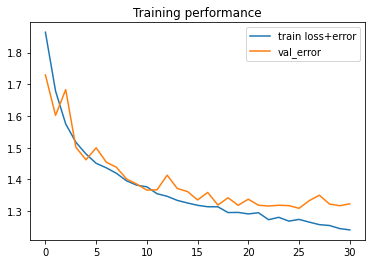

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

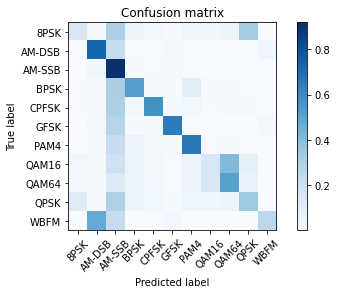

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09195402298850575


Overall Accuracy:  0.08728480821504077


Overall Accuracy:  0.10177123986790754


Overall Accuracy:  0.1296019155941335


Overall Accuracy:  0.14706757963679667


Overall Accuracy:  0.22289890377588306


Overall Accuracy:  0.3197217180883243


Overall Accuracy:  0.4351261014889091


Overall Accuracy:  0.49894482966536025


Overall Accuracy:  0.5961655508216677


Overall Accuracy:  0.6715170278637771


Overall Accuracy:  0.722155328115593


Overall Accuracy:  0.7278637770897833


Overall Accuracy:  0.7307574363692119


Overall Accuracy:  0.7474654377880184


Overall Accuracy:  0.7379081015719468


Overall Accuracy:  0.7493171471927162


Overall Accuracy:  0.7309523809523809


Overall Accuracy:  0.7437668969660559


Overall Accuracy:  0.7348993288590604


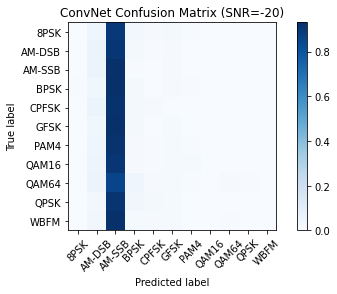

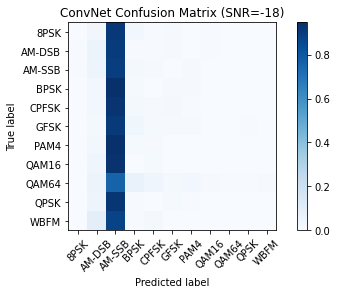

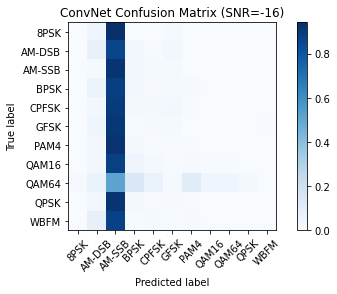

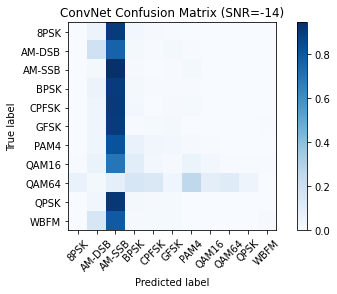

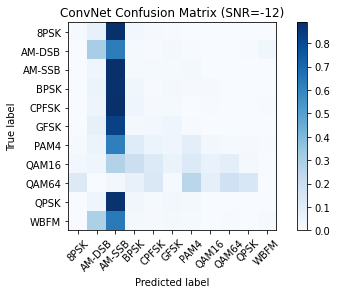

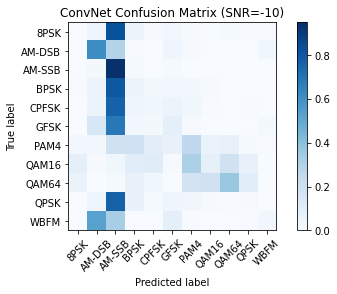

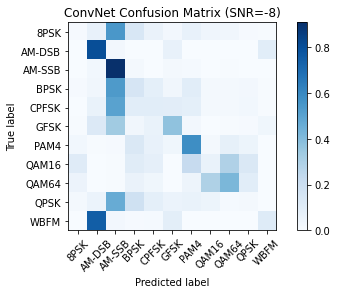

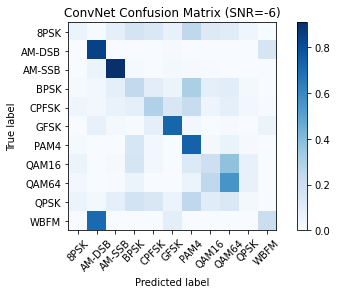

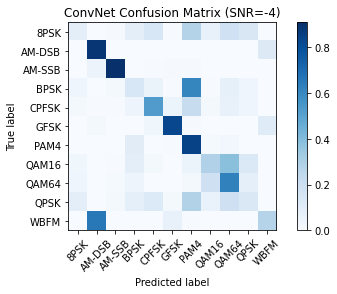

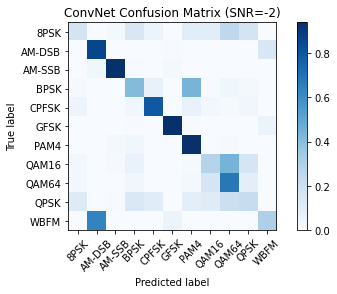

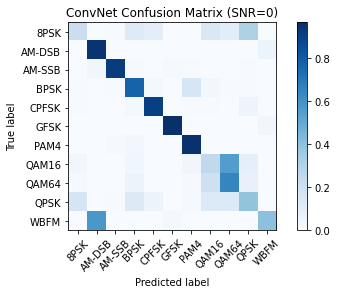

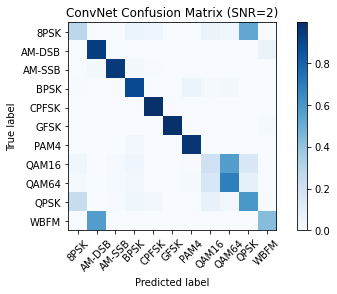

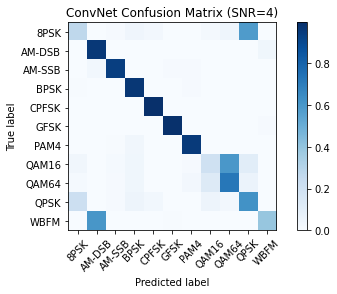

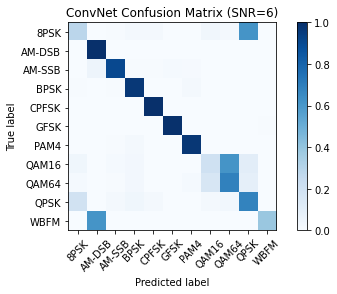

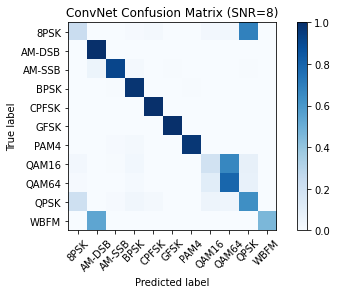

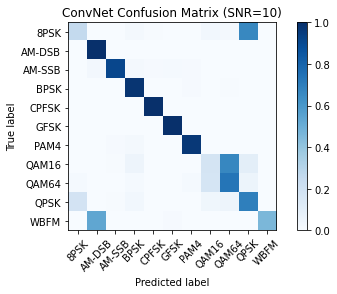

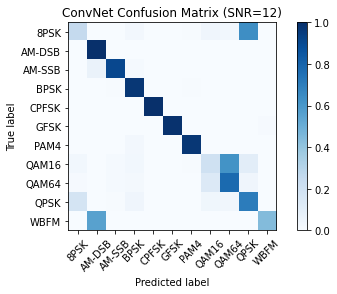

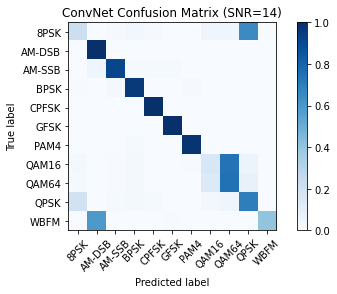

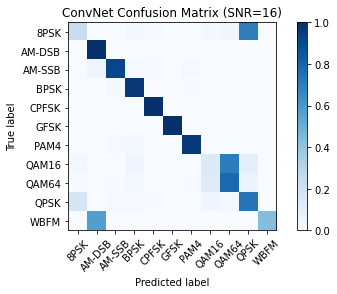

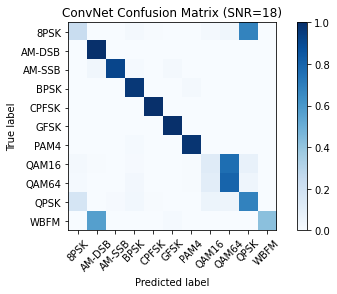

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,10,12,14,22,31,43,49,59,67,72,72,73,74,73,74,73,74,73


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

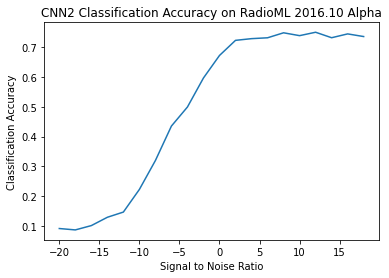

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")